<a href="https://colab.research.google.com/github/martaldsantos/newland_project/blob/master/DM_restruturado_k-means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Libraries & Packages

In [1]:
!pip install category_encoders
!pip install factor-analyzer
!pip install pyclustertend

In [2]:
import pandas as pd
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from math import ceil
from pandas_profiling import ProfileReport
import scipy.cluster.hierarchy as shc
from sklearn import datasets
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
from pyclustertend import hopkins
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")

#from factor_analyzer import FactorAnalyzer
#from factor_analyzer import calculate_bartlett_sphericity
#from factor_analyzer import calculate_kmo

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##### Functions

In [3]:
def empty_space_Value_to_binary(df, column, value):
    '''
    This function turns a binary variable with values ' ' or any given string in to 0 or 1
    It needs as input the dataframe, the column name and the string symbolizing 1
    (column name and value needs to be between '')
    '''
    df[column] = df[column].map(lambda x: 1 if x == value else 0 if (x == ' ') else x)

def from_object_to_datetime(df, column):
    
    df[column] = pd.to_datetime(df[column], infer_datetime_format=True)

def x_to_bin(df, column): #from sim/nao to binary values
    
    df[column] = df[column].map(lambda x: 1 if x == 'X' else 0)
    
def gender_treatment(df, column): #os valores de U (unknown) e todos os outros valores que n tinham significado algum, vamos por como np.nan
 
    df[column] = df[column].replace(['A', 'U', 'C', ' '], np.nan)

def pandas_profiling(df, title):
    
    profile = ProfileReport(df,
                           title = title,
                           correlations = {'pearson' : {'calculate' : True},
                                          'spearman' : {'calculate' : False},
                                          'kendall' : {'calculate' : False},
                                          'phi_k' : {'calculate' : False},
                                          'cramers' : {'calculate' : False}})
    return profile.to_notebook_iframe()

def pandas_profiling_minimal(df, title):
    
    profile = ProfileReport(df,
                           title = title,
                           minimal = True)
    return profile.to_notebook_iframe()
    
def pandas_profiling_binary(df, title):
    
    profile = ProfileReport(df,
                           title = title,
                           correlations = {'pearson' : {'calculate' : False},
                                          'spearman' : {'calculate' : True},
                                          'kendall' : {'calculate' : False},
                                          'phi_k' : {'calculate' : False},
                                          'cramers' : {'calculate' : False}})
    return profile.to_notebook_iframe()

def hist_box_maker(df,titl, num_of_rows, figx, figy):
    
    fig, axes = plt.subplots(num_of_rows, ceil((len(df.columns)*2)/num_of_rows), figsize=(figx, figy))
    temp = (list(df.columns)*2)
    temp.sort()
    # Plot data
    # Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
    i = 0 
    for ax, feat in zip(axes.flatten(), temp):
        
        if i%2 == 0:
            ax.hist(df[feat], bins = 100)
            ax.set_title(feat, y=-0.13)
            pltiswork=feat
            
        else:
            sns.boxplot(x=df[pltiswork], ax = ax)
        
        i+=1
            
    # Layout
    # Add a centered title to the figure:
    title = titl

    plt.suptitle(title)

    plt.show()# All Numeric Variables' Box Plots in one figure
    
def iqr_X(df, X): #Compute IQR

    q1 = df.quantile(.25)
    q3 = df.quantile(.75)

    iqr = (q3 - q1)

    #Compute upper and lower limits
    lower_lim = q1 - X * iqr
    upper_lim = q3 + X * iqr

    filters = []

    for metric in df.columns:
        llim = lower_lim[metric]
        ulim = upper_lim[metric]
        filters.append(df[metric].between(llim, ulim, inclusive = True))
    
    return np.all(filters, 0)

def ohe(df, column_list):
    ohc = OneHotEncoder(sparse = False)
    ohc_feat = ohc.fit_transform(df[column_list])
    ohc_feat_names = ohc.get_feature_names()
    ohc_df = pd.DataFrame(ohc_feat, index = df.index, columns = ohc_feat_names)
    return ohc_df

def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        x = x.drop(col, axis=1)
    return x
def hierarchical_ontop_of_kmeans1(df):
    %matplotlib inline
    kmeans = KMeans(n_clusters = 200, init = 'k-means++', n_init = 10, random_state = 1, n_jobs = -1)
    kmeans.fit(df)
    #Saving the labls
    centroids_descript = df.copy()
    centroids_descript['labels'] = kmeans.predict(df)
    #kmeans_labels = kmeans.predict(df)
    #Getting the centroid values for each column
    #centroids_descript = pd.concat((df, pd.Series(kmeans_labels, name='labels')), axis=1)
    centroids_descript = centroids_descript.groupby('labels').mean()
    def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
        """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
        The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
        Parameters:
        df (DataFrame): Dataset to apply clustering
        link_method (str): either "ward", "complete", "average", "single"
        max_nclus (int): maximum number of clusters to compare the methods
        min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
        dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
        Returns:
        ndarray: R2 values for the range of cluster solutions
        """
        def get_ss(df):
            ss = np.sum(df.var() * (df.count() - 1))
            return ss  # return sum of sum of squares of each df variable
    
        sst = get_ss(df)  # get total sum of squares
    
        r2 = []  # where we will store the R2 metrics for each cluster solution
    
        for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
            cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
            hclabels = cluster.fit_predict(df) #get cluster labels
            df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
            ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
            ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
            r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
        return np.array(r2)
    # Prepare input
    hc_methods = ["ward", "complete", "average", "single"]
    # Call function defined above to obtain the R2 statistic for each hc_method
    max_nclus = 20
    r2_hc_methods = np.vstack([get_r2_hc(df=centroids_descript, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
    r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

    sns.set()
    # Plot data
    fig = plt.figure(figsize=(11,5))
    sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

    # Finalize the plot
    fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
    plt.gca().invert_xaxis()  # invert x axis
    plt.legend(title="HC methods", title_fontsize=11)
    plt.xticks(range(1, max_nclus + 1))
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R2 metric", fontsize=13)

    plt.show()

def hierarchical_ontop_of_kmeans2(df, linkage):
    %matplotlib inline
    kmeans = KMeans(n_clusters = 200, init = 'k-means++', n_init = 10, random_state = 1, n_jobs = -1)
    kmeans.fit(df)
    #Saving the labls
    centroids_descript = df.copy()
    centroids_descript['labels'] = kmeans.predict(df)
    #kmeans_labels = kmeans.predict(df)
    #Getting the centroid values for each column
    #centroids_descript = pd.concat((df, pd.Series(kmeans_labels, name='labels')), axis=1)
    centroids_descript = centroids_descript.groupby('labels').mean()
    distance = 'euclidean'
    hclust1 = AgglomerativeClustering(linkage=linkage, affinity='euclidean', distance_threshold=0, n_clusters=None)
    hclust1.fit_predict(centroids_descript)
    # Adapted from:
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

    # create the counts of samples under each node (number of points being merged)
    counts = np.zeros(hclust1.children_.shape[0])
    n_samples = len(hclust1.labels_)

    # hclust.children_ contains the observation ids that are being merged together
    # At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
    for i, merge in enumerate(hclust1.children_):
        # track the number of observations in the current cluster being formed
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                # If this is True, then we are merging an observation
                current_count += 1  # leaf node
            else:
                # Otherwise, we are merging a previously formed cluster
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
    # the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
    # the counts indicate the number of points being merged (dendrogram's x-axis)
    linkage_matrix = np.column_stack(
        [hclust1.children_, hclust1.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    sns.set()
    fig = plt.figure(figsize=(11,5))
    # The Dendrogram parameters need to be tuned
    y_threshold = 100
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
    plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{distance.title()} Distance', fontsize=13)
    plt.show()

    
def hierarchical_ontop_of_kmeans3(df, numclust):
    df_with_labels = df.copy()
    #Defining the KMeans model
    kmeans = KMeans(n_clusters = numclust, init = 'k-means++', n_init = 10, random_state = 1, n_jobs = -1)
    #Fitting it to the data
    kmeans.fit(df)
    #Saving the labels
    df_with_labels['Labels'] = kmeans.predict(df)
    #Getting the centroid values for each column
    clust_descript = df_with_labels.groupby('Labels').mean()
    return df_with_labels, clust_descript

##### Drive

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1Ob8eKK0ajYN6YCwM9XTUeyevLwTn3T_F"})   # replace the id with id of file you want to access
downloaded.GetContentFile('donors.csv')
df = pd.read_csv("donors.csv")

##### Divisions

In [5]:
df = pd.read_csv("donors.csv")

In [6]:
users_data = df[['ODATEDW', 'OSOURCE', 'TCODE', 'STATE', 'ZIP',
                 'MAILCODE', 'PVASTATE', 'DOB', 'NOEXCH', 'RECINHSE', 'RECP3',
                 'RECPGVG', 'RECSWEEP', 'MDMAUD', 'DOMAIN', 'HOMEOWNR', 'CHILD03',
                 'CHILD07', 'CHILD12', 'CHILD18', 'NUMCHLD', 'INCOME', 'GENDER',
                 'WEALTH1', 'HIT', 'MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT',
                 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH',
                 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP', 'PEPSTRFL', 'GEOCODE2' ,'DATASRCE',
                  'MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV',
                  'STATEGOV', 'FEDGOV', 'SOLP3', 'SOLIH', 'MAJOR', 'WEALTH2',
                  'GEOCODE', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE',
                  'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS',
                  'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS',
                  'PLATES', 'LIFESRC', 'CONTROLN']].copy()

In [7]:
neighbourhood = df[['POP901', 'POP902', 'POP903',
                    'POP90C1', 'POP90C2', 'POP90C3', 'POP90C4', 'POP90C5', 'ETH1',
                    'ETH2', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9',
                    'ETH10', 'ETH11', 'ETH12', 'ETH13', 'ETH14', 'ETH15', 'ETH16',
                    'AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906',
                    'AGE907', 'CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3',
                    'AGEC4', 'AGEC5', 'AGEC6', 'AGEC7', 'CHILC1', 'CHILC2', 'CHILC3',
                    'CHILC4', 'CHILC5', 'HHAGE1', 'HHAGE2', 'HHAGE3', 'HHN1', 'HHN2',
                    'HHN3', 'HHN4', 'HHN5', 'HHN6', 'MARR1', 'MARR2', 'MARR3', 'MARR4',
                    'HHP1', 'HHP2', 'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'DW7',
                    'DW8', 'DW9', 'HV1', 'HV2', 'HV3', 'HV4', 'HU1', 'HU2', 'HU3',
                    'HU4', 'HU5', 'HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5', 'HHD6',
                    'HHD7', 'HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12', 'ETHC1',
                    'ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'ETHC6', 'HVP1', 'HVP2',
                    'HVP3', 'HVP4', 'HVP5', 'HVP6', 'HUR1', 'HUR2', 'RHP1', 'RHP2',
                    'RHP3', 'RHP4', 'HUPA1', 'HUPA2', 'HUPA3', 'HUPA4', 'HUPA5',
                    'HUPA6', 'HUPA7', 'RP1', 'RP2', 'RP3', 'RP4', 'MSA', 'ADI', 'DMA',
                    'IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC7', 'IC8', 'IC9',
                    'IC10', 'IC11', 'IC12', 'IC13', 'IC14', 'IC15', 'IC16', 'IC17',
                    'IC18', 'IC19', 'IC20', 'IC21', 'IC22', 'IC23', 'HHAS1', 'HHAS2',
                    'HHAS3', 'HHAS4', 'MC1', 'MC2', 'MC3', 'TPE1', 'TPE2', 'TPE3',
                    'TPE4', 'TPE5', 'TPE6', 'TPE7', 'TPE8', 'TPE9', 'PEC1', 'PEC2',
                    'TPE10', 'TPE11', 'TPE12', 'TPE13', 'LFC1', 'LFC2', 'LFC3', 'LFC4',
                    'LFC5', 'LFC6', 'LFC7', 'LFC8', 'LFC9', 'LFC10', 'OCC1', 'OCC2',
                    'OCC3', 'OCC4', 'OCC5', 'OCC6', 'OCC7', 'OCC8', 'OCC9', 'OCC10',
                    'OCC11', 'OCC12', 'OCC13', 'EIC1', 'EIC2', 'EIC3', 'EIC4', 'EIC5',
                    'EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC10', 'EIC11', 'EIC12', 'EIC13',
                    'EIC14', 'EIC15', 'EIC16', 'OEDC1', 'OEDC2', 'OEDC3', 'OEDC4',
                    'OEDC5', 'OEDC6', 'OEDC7', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5',
                    'EC6', 'EC7', 'EC8', 'SEC1', 'SEC2', 'SEC3', 'SEC4', 'SEC5', "VC1", "VC2",
                    'VC3', 'VC4', 'ANC1', 'ANC2', 'ANC3', 'ANC4', 'ANC5', 'ANC6',
                    'ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13',
                    'ANC14', 'ANC15', 'POBC1', 'POBC2', 'LSC1', 'LSC2', 'LSC3', 'LSC4',
                    'VOC1', 'VOC2', 'VOC3', 'HC1', 'HC2', 'HC3', 'HC4', 'HC5', 'HC6',
                    'HC7', 'HC8', 'HC9', 'HC10', 'HC11', 'HC12', 'HC13', 'HC14',
                    'HC15', 'HC16', 'HC17', 'HC18', 'HC19', 'HC20', 'HC21', 'MHUC1',
                    'MHUC2', 'AC1', 'AC2','AFC1','AFC2','AFC3','AFC4','AFC5','AFC6','CONTROLN']].copy()

In [8]:
rfa = df[[ 'ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5',
           'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11',
           'ADATE_12', 'ADATE_13', 'ADATE_14', 'ADATE_15', 'ADATE_16',
           'ADATE_17', 'ADATE_18', 'ADATE_19', 'ADATE_20', 'ADATE_21',
           'ADATE_22', 'ADATE_23', 'ADATE_24', 'RFA_2', 'RFA_3', 'RFA_4',
           'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_10', 'RFA_11',
           'RFA_12', 'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16', 'RFA_17',
           'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22', 'RFA_23',
           'RFA_24', 'CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12',
           'NUMPRM12', 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7',
           'RDATE_8', 'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12',
           'RDATE_13', 'RDATE_14', 'RDATE_15', 'RDATE_16', 'RDATE_17',
           'RDATE_18', 'RDATE_19', 'RDATE_20', 'RDATE_21', 'RDATE_22',
           'RDATE_23', 'RDATE_24', 'RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6',
           'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11',
           'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16',
           'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21',
           'RAMNT_22', 'RAMNT_23', 'RAMNT_24', 'RAMNTALL', 'NGIFTALL',
           'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE',
           'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG',
           'AVGGIFT', 'CONTROLN', 'HPHONE_D', 'RFA_2R', 'RFA_2F', 'RFA_2A',
           'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']].copy()

# 2. Processing

### Users Data 

###### **Descriptive Statistics**

In [9]:
users_data.describe()

,TCODE,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,CONTROLN
count,95412.000000,12386.000000,74126.000000,50680.000000,95412.000000,42558.000000,42558.000000,42558.000000,42498.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,51589.000000,95412.000000
mean,54.223117,1.527773,3.886248,5.345699,3.321438,0.152075,0.059166,1.116382,0.063932,0.448329,0.126322,0.065722,0.141806,0.145237,0.714484,0.237723,0.376239,0.005874,0.237558,1.048443,30.445332,29.702312,32.637719,6.842326,4.568566,3.110867,4.954525,95778.176959
std,953.844476,0.806861,1.854960,2.742490,9.306899,0.470023,0.262078,1.669967,0.297344,0.821010,0.380916,0.276398,0.490414,0.427822,1.249891,0.728572,0.959573,0.077942,0.878639,5.065522,11.470554,15.097752,17.709065,4.391699,5.126618,4.155168,2.802759,55284.596094
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,20.000000,21.000000,4.000000,1.000000,1.000000,3.000000,47910.750000
50%,1.000000,1.000000,4.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,29.000000,32.000000,6.000000,3.000000,2.000000,5.000000,95681.500000
75%,2.000000,2.000000,5.000000,8.000000,3.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,39.000000,43.000000,9.000000,6.000000,4.000000,7.000000,143643.500000
max,72002.000000,7.000000,7.000000,9.000000,241.000000,6.000000,4.000000,9.000000,6.000000,9.000000,5.000000,4.000000,5.000000,6.000000,9.000000,8.000000,9.000000,2.000000,9.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,87.000000,9.000000,191779.000000


General information about the data types, missing values and the shape of columns

In [10]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Data columns (total 74 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ODATEDW   95412 non-null  object 
 1   OSOURCE   95412 non-null  object 
 2   TCODE     95412 non-null  int64  
 3   STATE     95412 non-null  object 
 4   ZIP       95412 non-null  object 
 5   MAILCODE  95412 non-null  object 
 6   PVASTATE  95412 non-null  object 
 7   DOB       71529 non-null  object 
 8   NOEXCH    95412 non-null  object 
 9   RECINHSE  95412 non-null  object 
 10  RECP3     95412 non-null  object 
 11  RECPGVG   95412 non-null  object 
 12  RECSWEEP  95412 non-null  object 
 13  MDMAUD    95412 non-null  object 
 14  DOMAIN    95412 non-null  object 
 15  HOMEOWNR  95412 non-null  object 
 16  CHILD03   95412 non-null  object 
 17  CHILD07   95412 non-null  object 
 18  CHILD12   95412 non-null  object 
 19  CHILD18   95412 non-null  object 
 20  NUMCHLD   12386 non-null  fl

Now let's inspect the variable that has the unique identifier of each donor (CONTROLN). Let's check if there is more than 1 value for each identifier:

In [11]:
(users_data["CONTROLN"].value_counts()>1).sum() 

0

No, we will never have 2 lines with the same identifier, so we guarantee that the ID is unique.

***DATASRCE, LIFESRC, GEOCODE*** 

- **DATASRCE** - Indicates which third-party data source the donor matched against
- **LIFESRC** - Indicates source of the lifestyle variables listed above

These variables don't give usefull information regarding our study.

- **GEOCODE** - Geo Cluster Code indicating the level geography at which a record matches the census data.
This variable could possibly be useful, but unfortunately it has over 80% missing values and we believe that the rest of the variables that contain information about the geolocation of the donor's are more valuable.

In [12]:
(users_data['GEOCODE'][users_data['GEOCODE'] == ' '].shape[0] / users_data.shape[0]) * 100 #Percent of possible missing values

84.02297404938582

In [13]:
users_data.drop(columns = ['DATASRCE', 'LIFESRC', 'GEOCODE'], inplace = True)

In [14]:
users_data[['MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV']].describe()

,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV
count,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000
mean,1.048443,30.445332,29.702312,32.637719,6.842326,4.568566,3.110867
std,5.065522,11.470554,15.097752,17.709065,4.391699,5.126618,4.155168
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,20.000000,21.000000,4.000000,1.000000,1.000000
50%,0.000000,31.000000,29.000000,32.000000,6.000000,3.000000,2.000000
75%,0.000000,37.000000,39.000000,43.000000,9.000000,6.000000,4.000000
max,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,87.000000


***MALEMILI***, ***MALEVET***, ***VIETVETS***, ***WWIIVETS***, ***LOCALGOV***, ***STATEGOV***, ***FEDGOV***

These variable don't need any "initial" treating, however the documentation is ambiguos about what they refer to. It seems they migth refer to the donor's household or neighborhood, for now we will keep them, however, if we use them later, we will need to clearly define what we believe they indicate

***SOLP3, SOLIH***

- **SOLP3** - SOLICIT LIMITATION CODE P3 
- **SOLIH** - SOLICITATION LIMIT CODE IN HOUSE

These variables seem useful, however we can't tell the difference between one and the other. The values are categorical, however they can be easely turned in to integer values as they do have an order, except of course for the default value, which is also the most prevolant one in both variables, by a lot.

Some special transformations will be needed for these variables, however we doubt they will be usefull due to their distribuition.

Since the great majority of values are default, they don't allow us to discretize the donors that well, so we will delete them.

In [15]:
users_data['SOLP3'].value_counts()

      95232
00       80
12       72
01       18
02       10
Name: SOLP3, dtype: int64

In [16]:
users_data['SOLP3'].isna().sum()

0

In [17]:
users_data['SOLIH'].value_counts()

      89212
12     5693
00      296
01       94
02       75
03       19
04       16
06        7
Name: SOLIH, dtype: int64

In [18]:
users_data['SOLIH'].isna().sum()

0

In [19]:
users_data.drop(columns = ['SOLP3', 'SOLIH'], inplace = True)

***MAJOR*** 

Major Donor Flag

We already have this information in other variables, however it is nice to have it on a binary one. We will proceed with it, however, with special care not to repeat information. The transformation will be performed in the "Variable Transformation" section.

In [20]:
users_data['MAJOR'].value_counts()

     95118
X      294
Name: MAJOR, dtype: int64

***WEALTH2*** 

Wealth Rating Wealth rating uses median family income and population statistics from each area to index relative wealth within each state The segments are denoted 0-9, with 9 being the highest income group and zero being the lowest. Each rating has a different meaning within each state.

Since comparisons can only be made regarding individuals of the same state, the use of this variable can be dubious. But for now we will keep it since it can be an important indicator, even though it has almost 50% missing values.

If we do use it, no treatment is needed.

In [21]:
#Percent missing values
(users_data['WEALTH2'].isna().sum() / users_data.shape[0]) * 100 

45.93028130633463

In [22]:
users_data['WEALTH2'].value_counts()

9.0    6523
8.0    5975
7.0    5684
6.0    5497
5.0    5351
4.0    5074
3.0    5046
2.0    4971
1.0    4191
0.0    3277
Name: WEALTH2, dtype: int64

***COLLECT1, VETERANS, BIBLE, CATLG, HOMEE, PETS, CDPLAY, STEREO, PCOWNERS, PHOTO, CRAFTS, FISHER, GARDENIN, BOATS, WALKER, KIDSTUFF, CARDS, PLATES***

All these variables about the donors interests or hobbies don't have missing values. Since their values are all objects, we will apply a function  to turn them into binary variables in the "Variable Transformation" section.

In [23]:
users_data[['COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY',
             'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS',
             'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES']].isna().sum()

COLLECT1    0
VETERANS    0
BIBLE       0
CATLG       0
HOMEE       0
PETS        0
CDPLAY      0
STEREO      0
PCOWNERS    0
PHOTO       0
CRAFTS      0
FISHER      0
GARDENIN    0
BOATS       0
WALKER      0
KIDSTUFF    0
CARDS       0
PLATES      0
dtype: int64

###### **The 50 States**

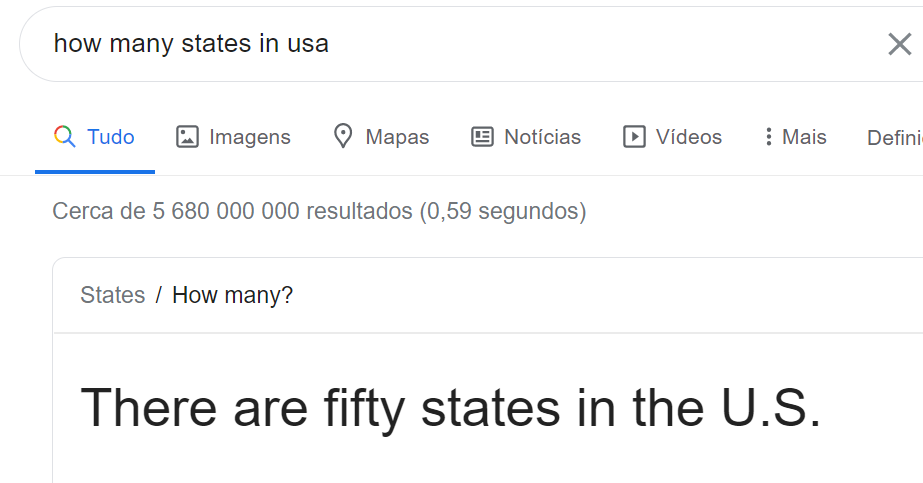

There are more values for the states than the number of states that google states exist indeed 


In [24]:
len(users_data["STATE"].unique())

57

Let's try to see the values to check what is wrong :

In [25]:
users_data["STATE"].unique()

array(['IL', 'CA', 'NC', 'FL', 'AL', 'IN', 'LA', 'IA', 'TN', 'KS', 'MN',
       'UT', 'MI', 'MO', 'TX', 'OR', 'WA', 'WI', 'GA', 'OK', 'SC', 'KY',
       'MD', 'SD', 'NV', 'NE', 'AZ', 'VA', 'ND', 'AK', 'AR', 'NM', 'MT',
       'MS', 'AP', 'CO', 'AA', 'HI', 'ME', 'WY', 'ID', 'OH', 'NJ', 'MA',
       'VT', 'NY', 'PA', 'DC', 'AE', 'CT', 'DE', 'WV', 'RI', 'GU', 'AS',
       'NH', 'VI'], dtype=object)

We have an array with the initials of the states and Washington DC, which isn't exactly  a state but due to its importance its many times counted as such

In [26]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

Now let's compare the values that were in the States list with the values in our dataset, and see which values are different:

In [27]:
users_data["STATE"].loc[(~users_data["STATE"].isin(states))].value_counts()

AP    81
AA    18
AE    15
VI     5
GU     4
AS     1
Name: STATE, dtype: int64

(https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations)

- **AP**, **AA** and **AE** are US Military Mail Codes 
- **VI** stands for Virgin Islands
- **GU** stands for Guam, an island in the pacific
-**AS** is from American Samoa

These values are called **"USA Territories"** and not exactly states.
We should consider renaming the variable for more accurate results

###### **Income Analysis**

In [28]:
users_data[['WEALTH1', "WEALTH2", "INCOME"]].isna().sum()

WEALTH1    44732
WEALTH2    43823
INCOME     21286
dtype: int64

In [29]:
(users_data[users_data['WEALTH1'].isna() & users_data['WEALTH2'].isna()].shape[0]) / users_data.shape[0]

0.22893346748836624

As we can see both wealth variables have a lot of missing values, however if we combine both, we will have 22% of observations which will need their values imputed.

- *WEALTH1* is prefered to *WEALTH2*, since *WEALTH2* is dependent on the donors state, so when we have observations with values in both, we would prefer the WEALTH1 value. We know this isn't ideal but it is better than imputing an estimated value.

- However, *WEALTH2* represents the median family income, and the metadata isn't really clear about what does *WEALTH1* refere to.

- The variable *INCOME* is interpreted as representing the total family income of each donor. The metadata isn't clear about it, but we believe it has a different bin distribuition, since it only has values between 1 and 7.

In [30]:
(users_data[users_data['WEALTH1'].isna() & users_data['WEALTH2'].isna() & users_data['INCOME'].isna()].shape[0]) / users_data.shape[0]

0.10936779440741207

If we also combine *INCOME* we will have 11% of missing values, but unfortunently, since they seem to show different bins, this isn't doable.

So let's see how many values are different between *WEALTH1* and *WEALTH2*.

In [31]:
(users_data[['WEALTH1', 'WEALTH2']][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))
                                  ].shape[0] /users_data.shape[0]) * 100

#10% of data points have different values of WEALTH1 and 2

10.57833396218505

But this percentage doesn't tell us how big is the difference between the values.

In [32]:
#Avg difference between different values of WEALTH1 and WEALTH2

(((users_data['WEALTH1'][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))] - users_data['WEALTH2'][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))])**2)**(1/2)).mean()

1.8562369959377787

In [33]:
#Std difference between different values of WEALTH1 and WEALTH2

(((users_data['WEALTH1'][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))] - users_data['WEALTH2'][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))])**2)**(1/2)).std()

1.5039385431617833

As we can see, when there is a difference between *WEALTH1*and *WEALTH2*, it is quite big (about more than one bin).

In [34]:
(users_data[users_data['INCOME'].isna()].shape[0] / users_data.shape[0]) * 100

22.30956273843961

If we use the variable *INCOME* we will have about 22% missing values, the same as the combination of *WEALTH1* and *WEALTH2*, and we don't have to combine any variables or take in to account assumptions we don't believe to be very strong.

So if we want to cluster having into account the income of the donors, we will use the total family income of each

In [35]:
users_data.drop(columns = ['WEALTH1', 'WEALTH2'], inplace = True)

###### **Variable Transformation**

We will turn the following variables that were in the string format but with binary values, in int64

In [36]:
empty_space_Value_to_binary(users_data, "MAILCODE", 'B')
empty_space_Value_to_binary(users_data, "PVASTATE", 'P')
empty_space_Value_to_binary(users_data, "HOMEOWNR", 'H')
empty_space_Value_to_binary(users_data, 'MAJOR', 'X') 

for column in ['COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY','STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS','WALKER', 'KIDSTUFF', 'CARDS', 'PLATES']:
  empty_space_Value_to_binary(users_data, column, 'Y')

users_data["PVASTATE"] = users_data["PVASTATE"].map(lambda x: 0 if x == 'E' else x)
users_data["HOMEOWNR"] = users_data["HOMEOWNR"].map(lambda x: 0 if x == 'U' else x)


users_data["PVASTATE"] = users_data["PVASTATE"].astype("int64")
users_data["HOMEOWNR"] = users_data["HOMEOWNR"].astype("int64")

As the values of MAILCODE reference a bad adress, we will rename the column to mean so.


In [37]:
users_data.rename(columns={"MAILCODE": "WRONG_ADRESS"}, inplace=True)

We can see that there are 1399 people that have no valid address, which is problematic since the gifts and promotions are sent by mail


In [38]:
users_data["WRONG_ADRESS"].value_counts()

0    94013
1     1399
Name: WRONG_ADRESS, dtype: int64

Put the following columns as binary. Special care had to be done to the variable NOEXCH which didnt have the values it should, and had values as strings and as ints. so the approach was to change everything to string and then to int, to be able to have a proper binary variable

In [39]:
for i in ["NOEXCH", "RECINHSE","RECP3","RECPGVG","RECSWEEP","PEPSTRFL"]:
    empty_space_Value_to_binary(users_data, i, 'X')

users_data["NOEXCH"] = users_data["NOEXCH"].astype('str')
users_data["NOEXCH"] = users_data["NOEXCH"].astype('int64')

Make the Variable Gender, Binary:


In [40]:
gender_treatment(users_data, "GENDER")

Use the function that automatically searches for the correct datetime to put our date variables in the right format:

In [41]:
for i in ["DOB","ODATEDW"]:
    from_object_to_datetime(users_data, i)

Some values had a strange "-" in the end which did not allow the variable to be numeric:

In [42]:
users_data["ZIP"] = users_data["ZIP"].str.replace('-', '') .astype("int64")

In this line we will put the null values that were formatted as " " in a proper format:


In [43]:
users_data[["CHILD03", "CHILD07", "CHILD12", "CHILD18", "GEOCODE2"]]= users_data[["CHILD03", "CHILD07", "CHILD12", "CHILD18","GEOCODE2"]].replace(" ", np.nan)

Put the unreadable values that were as "XXXX" in a proper format:


In [44]:
users_data["MDMAUD"] = users_data["MDMAUD"].replace("XXXX", np.nan)

We will divide the variable in GENDER in one that represents gender, and another one that represents the information in a Joint account

In [45]:
users_data['JOINT'] = np.where(users_data['GENDER']=='J', 1,0)
users_data['GENDER'] = users_data['GENDER'].replace(['J'], np.nan) #Change the values of joint acounts to unknown
users_data['FEMALE'] = users_data['GENDER'].map(lambda x: 1 if x == 'F' else 0 ) #And now we can create the variable female

 Let's turn the date of birth to a more readable variable: age of the referenced person in years.

In [46]:
users_data['AGE'] = users_data['DOB'].apply(lambda x : (pd.datetime.now().year - x.year))

The variable NUMCHLD has missing values. We decided to check whether the variable had 0s or not, and given that it doesn't, we will make the assumption that a missing value means that the person does not have a child and not the lack of information about the matter.

In [47]:
users_data["NUMCHLD"].value_counts()

1.0    7792
2.0    3110
3.0    1101
4.0     316
5.0      59
6.0       7
7.0       1
Name: NUMCHLD, dtype: int64

In [48]:
users_data["NUMCHLD"] = users_data["NUMCHLD"].replace(np.nan, 0)

In [49]:
users_data["DOMAIN"] = users_data["DOMAIN"].map(lambda x: np.nan if x ==" " else x)

In [50]:
users_data["URBANICITY"] = users_data["DOMAIN"].str[0:1]
users_data["SES"] = users_data["DOMAIN"].str[1:2]

In [51]:
users_data["SES"] = users_data["SES"].astype("float64")

In [52]:
for value in range(0,users_data.shape[0]):
  if users_data["URBANICITY"][value] == 'U':
    if users_data["SES"][value] ==3:
      users_data["SES"][value] =2
    if users_data["SES"][value] ==4:
      users_data["SES"][value] =3

We are going to drop the following variables:
- **CHILD03, CHILD07, CHILD12, CHILD18:** the variables have 98.8% of missing values and are not easy to interpret or put in a numeric format.
- **TCODE**: brings no information to the model. meaning, its impossible to encode and to even identify patterns with it.
-**OSOURCE**: No information is provided for us to be able to interpret the variables
- **GENDER**: We are going to drop this column because we have put its information in a more structured variable, FEMALE
- **DOMAIN**: We are going to drop this column because we have put its information in 2 other variables, URBANICITY, SES
- **MDMAUD**: We will remove this variable as its values are already decomposed later in the dataset and we don't want to have duplicate information


In [53]:
users_data= users_data.drop(columns = ["CHILD03", "CHILD07", "CHILD12", "CHILD18", "MDMAUD", "TCODE", "OSOURCE", "GENDER", "MDMAUD", "DOMAIN", "DOB"])

In [54]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
metric_features = users_data.select_dtypes(include=numerics)

###### **Encoding**

In [55]:
categorical = ['object']
categorical_features = users_data.select_dtypes(include=categorical)

In [56]:
categorical_features

,STATE,GEOCODE2,URBANICITY
0,IL,C,T
1,CA,A,S
2,NC,C,R
3,CA,C,R
4,FL,A,S
...,...,...,...
95407,AK,C,C
95408,TX,A,C
95409,MI,B,C
95410,CA,A,C


In [57]:
users_data["URBANICITY"].value_counts()

S    21924
R    19790
C    19689
T    19527
U    12166
Name: URBANICITY, dtype: int64

In [58]:
# create object of Ordinalencoding
encoder= ce.OrdinalEncoder(cols=['URBANICITY'],return_df=True, mapping=[{'col':'URBANICITY','mapping':{'R':0,'T':1,'S':2,'C':3,'U':4}}])

#fit and transform train data 
users_data = encoder.fit_transform(users_data)

In [59]:
users_data["URBANICITY"] = users_data["URBANICITY"].replace(-1,np.nan)

###### **Impute Missing Values**

In [60]:
missing_zero_values_table(users_data)

Your selected dataframe has 62 columns and 95412 Rows.
There are 19 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
MBCOLECT,40267,52914,55.5,93181,97.7,float64
PUBCULIN,37428,52854,55.4,90282,94.6,float64
MBGARDEN,40286,52854,55.4,93140,97.6,float64
MBBOOKS,21299,52854,55.4,74153,77.7,float64
MAGFAML,29790,52854,55.4,82644,86.6,float64
MAGFEM,37845,52854,55.4,90699,95.1,float64
MAGMALE,40036,52854,55.4,92890,97.4,float64
PUBGARDN,38388,52854,55.4,91242,95.6,float64
MBCRAFT,37707,52854,55.4,90561,94.9,float64
PUBHLTH,27309,52854,55.4,80163,84.0,float64


We decided to postpone the idea of imputing missing values in the variables that have information about the mailing promotions that the donors have responded to. So, we will proceed on doing the missing value imputation of the variables *AGE*, *INCOME*, *URBANICITY*, *SES*, *GEOCODE2*

In [61]:
metric_features2 = ["NUMCHLD", "HIT", "MALEVET", 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'FEDGOV','AGE']

In [62]:
# Age& Income - KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")
users_data[metric_features2] = imputer.fit_transform(users_data[metric_features2])

In [63]:
users_data["GEOCODE2"]= users_data["GEOCODE2"].fillna(users_data["GEOCODE2"].mode()[0])
users_data["URBANICITY"]= users_data["URBANICITY"].fillna(users_data["URBANICITY"].mode()[0])
users_data["SES"]= users_data["SES"].fillna(users_data["SES"].mode()[0])
users_data["INCOME"]= users_data["INCOME"].fillna(users_data["INCOME"].mode()[0])

###### **Coherence Checks**

In [64]:
users_data["TOTGIFT_NAN"]= users_data[['MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP']].sum(axis=1,  min_count=1)

In [65]:
users_data[["HIT", "TOTGIFT_NAN"]].loc[users_data["HIT"] < users_data["TOTGIFT_NAN"]]

,HIT,TOTGIFT_NAN
1469,0.0,1.0
2688,0.0,7.0
3909,0.0,3.0
4506,0.0,2.0
6265,0.0,4.0
...,...,...
92555,0.0,5.0
93036,0.0,1.0
93567,0.0,6.0
93830,0.0,2.0


In [66]:
users_data["HIT"][users_data["HIT"] < users_data["TOTGIFT_NAN"]] = users_data["TOTGIFT_NAN"][users_data["HIT"] < users_data["TOTGIFT_NAN"]] 

In [67]:
users_data[["HIT", "TOTGIFT_NAN"]].loc[users_data["HIT"] < users_data["TOTGIFT_NAN"]]

,HIT,TOTGIFT_NAN


###### **Outliers**

In [68]:
 hist_box_maker(metric_features, "Users Data Value Distribution", metric_features.shape[1], 30,30)

In [69]:
users_data[(users_data['FEDGOV']>55)|
            (users_data['LOCALGOV']>43)|
            (users_data['MALEMILI']>63)|
            (users_data['MALEVET']>87)|
            (users_data['STATEGOV']>63)|
            (users_data['VIETVETS']>95)]

,ODATEDW,STATE,ZIP,WRONG_ADRESS,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,HOMEOWNR,NUMCHLD,INCOME,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,PEPSTRFL,GEOCODE2,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,MAJOR,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,CONTROLN,JOINT,FEMALE,AGE,URBANICITY,SES,TOTGIFT_NAN
168,2016-01-01,GA,30905,0,0,0,0,0,0,0,0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,B,78,12.0,6.0,0.0,22.0,0,28.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,137726,0,1,55.8,1.0,2.0,NaN
762,2007-01-01,OR,97761,0,0,0,0,0,0,0,0,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,D,0,17.0,45.0,16.0,57.0,3,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,177932,0,1,55.4,0.0,2.0,NaN
887,2014-01-01,LA,70130,0,0,0,0,0,0,0,0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,B,0,23.0,99.0,0.0,4.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,108564,0,0,70.0,4.0,2.0,NaN
1278,2015-01-01,CO,80918,0,0,0,0,0,0,0,0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,B,76,18.0,16.0,0.0,3.0,2,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86308,0,1,53.6,1.0,3.0,NaN
1295,2011-01-01,AL,36360,0,0,0,1,0,0,0,0,1.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,C,13,46.0,99.0,0.0,0.0,24,0.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,14154,0,1,78.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94168,2011-01-01,TX,76522,0,0,0,1,0,0,0,1,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,C,64,26.0,32.0,4.0,10.0,13,25.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,186172,0,0,67.0,1.0,2.0,NaN
94635,2015-01-01,WA,98005,0,0,0,1,0,0,0,0,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,A,0,34.0,99.0,0.0,31.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10833,0,0,81.0,3.0,3.0,NaN
94693,2011-01-01,LA,70094,0,0,0,0,0,0,0,1,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,B,0,6.0,99.0,0.0,0.0,28,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,108257,0,1,59.0,2.0,3.0,0.0
95147,2006-01-01,CA,94035,0,0,0,1,0,0,0,1,0.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,A,98,0.0,60.0,0.0,0.0,17,15.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,6648,0,0,74.0,1.0,1.0,NaN


In [70]:
#Para ver se quisermos eliminar variáveis binárias por isto

for i in ['MAJOR', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG',
       'HOMEE', 'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS',
       'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES']:
    
    print(i, ':', users_data[i].value_counts(), '\n')

MAJOR : 0    95118
1      294
Name: MAJOR, dtype: int64 

COLLECT1 : 0    90210
1     5202
Name: COLLECT1, dtype: int64 

VETERANS : 0    84986
1    10426
Name: VETERANS, dtype: int64 

BIBLE : 0    86541
1     8871
Name: BIBLE, dtype: int64 

CATLG : 0    87547
1     7865
Name: CATLG, dtype: int64 

HOMEE : 0    94525
1      887
Name: HOMEE, dtype: int64 

PETS : 0    81086
1    14326
Name: PETS, dtype: int64 

CDPLAY : 0    83158
1    12254
Name: CDPLAY, dtype: int64 

STEREO : 0    82618
1    12794
Name: STEREO, dtype: int64 

PCOWNERS : 0    84931
1    10481
Name: PCOWNERS, dtype: int64 

PHOTO : 0    90626
1     4786
Name: PHOTO, dtype: int64 

CRAFTS : 0    87236
1     8176
Name: CRAFTS, dtype: int64 

FISHER : 0    88282
1     7130
Name: FISHER, dtype: int64 

GARDENIN : 0    82010
1    13402
Name: GARDENIN, dtype: int64 

BOATS : 0    93384
1     2028
Name: BOATS, dtype: int64 

WALKER : 0    84911
1    10501
Name: WALKER, dtype: int64 

KIDSTUFF : 0    93876
1     1536
Name: K

###### **Correlation Matrix**

In [71]:
%matplotlib inline

In [72]:
users_data = users_data.drop(columns = ['RECSWEEP', 'MBBOOKS'])

#####**PCA Users Data** 

In [73]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
metric_features = users_data.select_dtypes(include=numerics)

In [74]:
metric_features.drop(columns = ['MBCRAFT',
       'MBGARDEN', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN',
       'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP','TOTGIFT_NAN', 'ZIP', 'CONTROLN'], inplace=True)

In [75]:
oquevaisair = metric_features[["NUMCHLD", "HIT", "MALEVET", "VIETVETS", "WWIIVETS", "LOCALGOV", "AGE",'MALEMILI']]

In [76]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(oquevaisair)
scaled_feat

array([[-0.33611554, -0.35742131,  0.74579771, ...,  0.71901343,
         0.09383012, -0.20697728],
       [ 1.35861867,  1.36149244, -1.34652717, ..., -0.19180056,
        -0.90166555, -0.20697728],
       [-0.33611554, -0.14255709, -0.91062615, ..., -0.19180056,
         0.29292925, -0.20697728],
       ...,
       [-0.33611554, -0.35742131, -1.08498656, ...,  0.03590294,
         0.02746374, -0.20697728],
       [-0.33611554, -0.35742131, -0.21318453, ...,  0.49130993,
        -0.10526902, -0.20697728],
       [-0.33611554, -0.03512498,  0.22271649, ...,  0.26360644,
         1.35479129, -0.00956324]])

In [77]:
oquevaisaircolunas = oquevaisair.columns
oquevaisair = scaled_feat
oquevaisair = pd.DataFrame(oquevaisair)
oquevaisair.columns = oquevaisaircolunas
oquevaisair

,NUMCHLD,HIT,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,AGE,MALEMILI
0,-0.336116,-0.357421,0.745798,0.284659,-0.826571,0.719013,0.093830,-0.206977
1,1.358619,1.361492,-1.346527,1.675602,-1.221851,-0.191801,-0.901666,-0.206977
2,-0.336116,-0.142557,-0.910626,-0.046518,0.020458,-0.191801,0.292929,-0.206977
3,-0.336116,-0.142557,-0.649086,-1.040049,-0.092480,-0.874911,0.691128,-0.206977
4,1.358619,6.088505,-0.213185,-1.371225,1.149829,4.362269,1.222059,-0.009563
...,...,...,...,...,...,...,...,...
95407,-0.336116,-0.357421,0.484257,1.145719,-1.221851,0.035903,-1.193678,2.556819
95408,1.358619,-0.249989,0.048356,0.880777,-0.770102,-0.647208,-0.768933,-0.206977
95409,-0.336116,-0.357421,-1.084987,1.079483,-0.713634,0.035903,0.027464,-0.206977
95410,-0.336116,-0.357421,-0.213185,0.350894,-0.713634,0.491310,-0.105269,-0.206977


######**PCA Hobbies Binary** 

In [78]:
pca_ud = metric_features.copy()

In [79]:
kmo_all,kmo_model = calculate_kmo(metric_features[[ 'MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV','FEDGOV']])
kmo_model

0.468546135683037

In [80]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(pca_ud)
scaled_feat

array([[-0.12198738, -0.1243551 , -0.05801002, ...,  0.09383012,
        -0.64086653,  0.19617884],
       [-0.12198738, -0.1243551 , -0.05801002, ..., -0.90166555,
         0.12036094, -1.29670801],
       [-0.12198738, -0.1243551 , -0.05801002, ...,  0.29292925,
        -1.402094  ,  0.19617884],
       ...,
       [-0.12198738, -0.1243551 , -0.05801002, ...,  0.02746374,
         0.8815884 ,  1.68906568],
       [-0.12198738, -0.1243551 , -0.05801002, ..., -0.10526902,
         0.8815884 , -1.29670801],
       [-0.12198738, -0.1243551 , -0.05801002, ...,  1.35479129,
         0.8815884 , -1.29670801]])

In [81]:
pca_ud = scaled_feat
pca_ud = pd.DataFrame(pca_ud)
pca_ud.columns = metric_features.columns
pca_ud

,WRONG_ADRESS,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,HOMEOWNR,NUMCHLD,INCOME,HIT,PEPSTRFL,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,MAJOR,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,JOINT,FEMALE,AGE,URBANICITY,SES
0,-0.121987,-0.124355,-0.05801,-0.274885,-0.146957,-0.034587,-1.102676,-0.336116,0.509147,-0.357421,1.052458,-0.206977,0.745798,0.284659,-0.826571,0.719013,-0.501028,-0.508013,-0.055596,-0.240136,-0.350256,-0.320166,-0.299729,-0.09687,-0.420329,-0.383872,-0.393519,-0.351292,-0.229805,-0.306142,-0.28419,-0.404251,-0.147366,-0.351668,-0.127914,-0.105028,-0.076837,-0.061969,0.927749,0.093830,-0.640867,0.196179
1,-0.121987,-0.124355,-0.05801,-0.274885,-0.146957,-0.034587,0.906885,1.358619,1.097566,1.361492,-0.950157,-0.206977,-1.346527,1.675602,-1.221851,-0.191801,-0.501028,-0.508013,-0.055596,-0.240136,-0.350256,-0.320166,-0.299729,-0.09687,-0.420329,-0.383872,-0.393519,-0.351292,-0.229805,-0.306142,-0.28419,-0.404251,-0.147366,-0.351668,-0.127914,-0.105028,-0.076837,-0.061969,-1.077878,-0.901666,0.120361,-1.296708
2,-0.121987,-0.124355,-0.05801,-0.274885,-0.146957,-0.034587,-1.102676,-0.336116,-0.667692,-0.142557,1.052458,-0.206977,-0.910626,-0.046518,0.020458,-0.191801,0.669340,-0.508013,-0.055596,-0.240136,-0.350256,-0.320166,-0.299729,-0.09687,-0.420329,-0.383872,-0.393519,-0.351292,-0.229805,-0.306142,-0.28419,-0.404251,-0.147366,-0.351668,-0.127914,-0.105028,-0.076837,-0.061969,-1.077878,0.292929,-1.402094,0.196179
3,-0.121987,-0.124355,-0.05801,-0.274885,-0.146957,-0.034587,-1.102676,-0.336116,-1.844530,-0.142557,1.052458,-0.206977,-0.649086,-1.040049,-0.092480,-0.874911,-0.891151,-0.026682,-0.055596,-0.240136,-0.350256,-0.320166,-0.299729,-0.09687,-0.420329,-0.383872,-0.393519,-0.351292,-0.229805,-0.306142,-0.28419,-0.404251,-0.147366,-0.351668,-0.127914,-0.105028,-0.076837,-0.061969,0.927749,0.691128,-1.402094,0.196179
4,-0.121987,-0.124355,-0.05801,3.637887,6.804698,-0.034587,0.906885,1.358619,-0.667692,6.088505,-0.950157,-0.009563,-0.213185,-1.371225,1.149829,4.362269,-0.305967,-0.267347,-0.055596,-0.240136,-0.350256,3.123379,3.336347,-0.09687,-0.420329,-0.383872,2.541173,-0.351292,-0.229805,3.266461,-0.28419,2.473709,-0.147366,2.843588,-0.127914,9.521249,-0.076837,-0.061969,0.927749,1.222059,0.120361,0.196179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,-0.121987,-0.124355,-0.05801,-0.274885,-0.146957,-0.034587,-1.102676,-0.336116,0.509147,-0.357421,-0.950157,2.556819,0.484257,1.145719,-1.221851,0.035903,0.669340,2.379972,-0.055596,-0.240136,-0.350256,-0.320166,-0.299729,-0.09687,-0.420329,-0.383872,-0.393519,-0.351292,-0.229805,-0.306142,-0.28419,-0.404251,-0.147366,-0.351668,-0.127914,-0.105028,-0.076837,-0.061969,-1.077878,-1.193678,0.881588,0.196179
95408,-0.121987,-0.124355,-0.05801,-0.274885,-0.146957,-0.034587,0.906885,1.358619,1.685985,-0.249989,-0.950157,-0.206977,0.048356,0.880777,-0.770102,-0.647208,-0.696089,-0.748678,-0.055596,-0.240136,-0.350256,-0.320166,-0.299729,-0.09687,-0.420329,-0.383872,-0.393519,-0.351292,-0.229805,-0.306142,-0.28419,-0.404251,-0.147366,-0.351668,-0.127914,-0.105028,-0.076837,-0.061969,-1.077878,-0.768933,0.881588,-1.296708
95409,-0.121987,-0.124355,-0.05801,-0.274885,6.804698,-0.034587,-1.102676,-0.336116,0.509147,-0.357421,1.052458,-0.206977,-1.084987,1.079483,-0.713634,0.035903,3.595261,-0.748678,-0.055596,-0.240136,-0.350256,-0.320166,-0.299729,-0.09687,-0.420329,-0.383872,-0.393519,-0.351292,-0.229805,-0.306142,-0.28419,-0.404251,-0.147366,-0.351668,-0.127914,-0.105028,-0.076837,-0.061969,-1.077878,0.027464,0.881588,1.689066
95410,-0.121987,-0.124355,-0.05801,3.637887,-0.146957,-0.034587,0.906885,-0.336116,1.685985,-0.357421,1.052458,-0.206977,-0.213185,0.350894,-0.713634,0.491310,-0.696089,-0.508013,-0.055596,-0.240136,-0.350256,-0.3

In [82]:
pca = PCA()
pca_feat = pca.fit_transform(pca_ud[['COLLECT1','VETERANS', 'BIBLE', 'CATLG', 'PETS', 'CDPLAY', 'STEREO','PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'WALKER']])
pca_feat  

array([[-1.21458808, -0.04591465,  0.06314172, ...,  0.00359388,
        -0.00559747,  0.0113834 ],
       [-1.21458808, -0.04591465,  0.06314172, ...,  0.00359388,
        -0.00559747,  0.0113834 ],
       [-1.21458808, -0.04591465,  0.06314172, ...,  0.00359388,
        -0.00559747,  0.0113834 ],
       ...,
       [-1.21458808, -0.04591465,  0.06314172, ...,  0.00359388,
        -0.00559747,  0.0113834 ],
       [-1.21458808, -0.04591465,  0.06314172, ...,  0.00359388,
        -0.00559747,  0.0113834 ],
       [-1.21458808, -0.04591465,  0.06314172, ...,  0.00359388,
        -0.00559747,  0.0113834 ]])

In [83]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)).head(20)

,Eigenvalue,Difference,Proportion,Cumulative
1,4.457133,0.000000,0.342853,0.342853
2,1.039808,-3.417325,0.079984,0.422837
3,0.881247,-0.158561,0.067788,0.490625
4,0.845946,-0.035301,0.065072,0.555697
5,0.836166,-0.009780,0.064320,0.620017
6,0.798283,-0.037883,0.061406,0.681422
7,0.719035,-0.079248,0.055310,0.736732
8,0.716706,-0.002328,0.055131,0.791863
9,0.673616,-0.043090,0.051816,0.843679
10,0.584059,-0.089557,0.044927,0.888606


In [84]:
%matplotlib inline

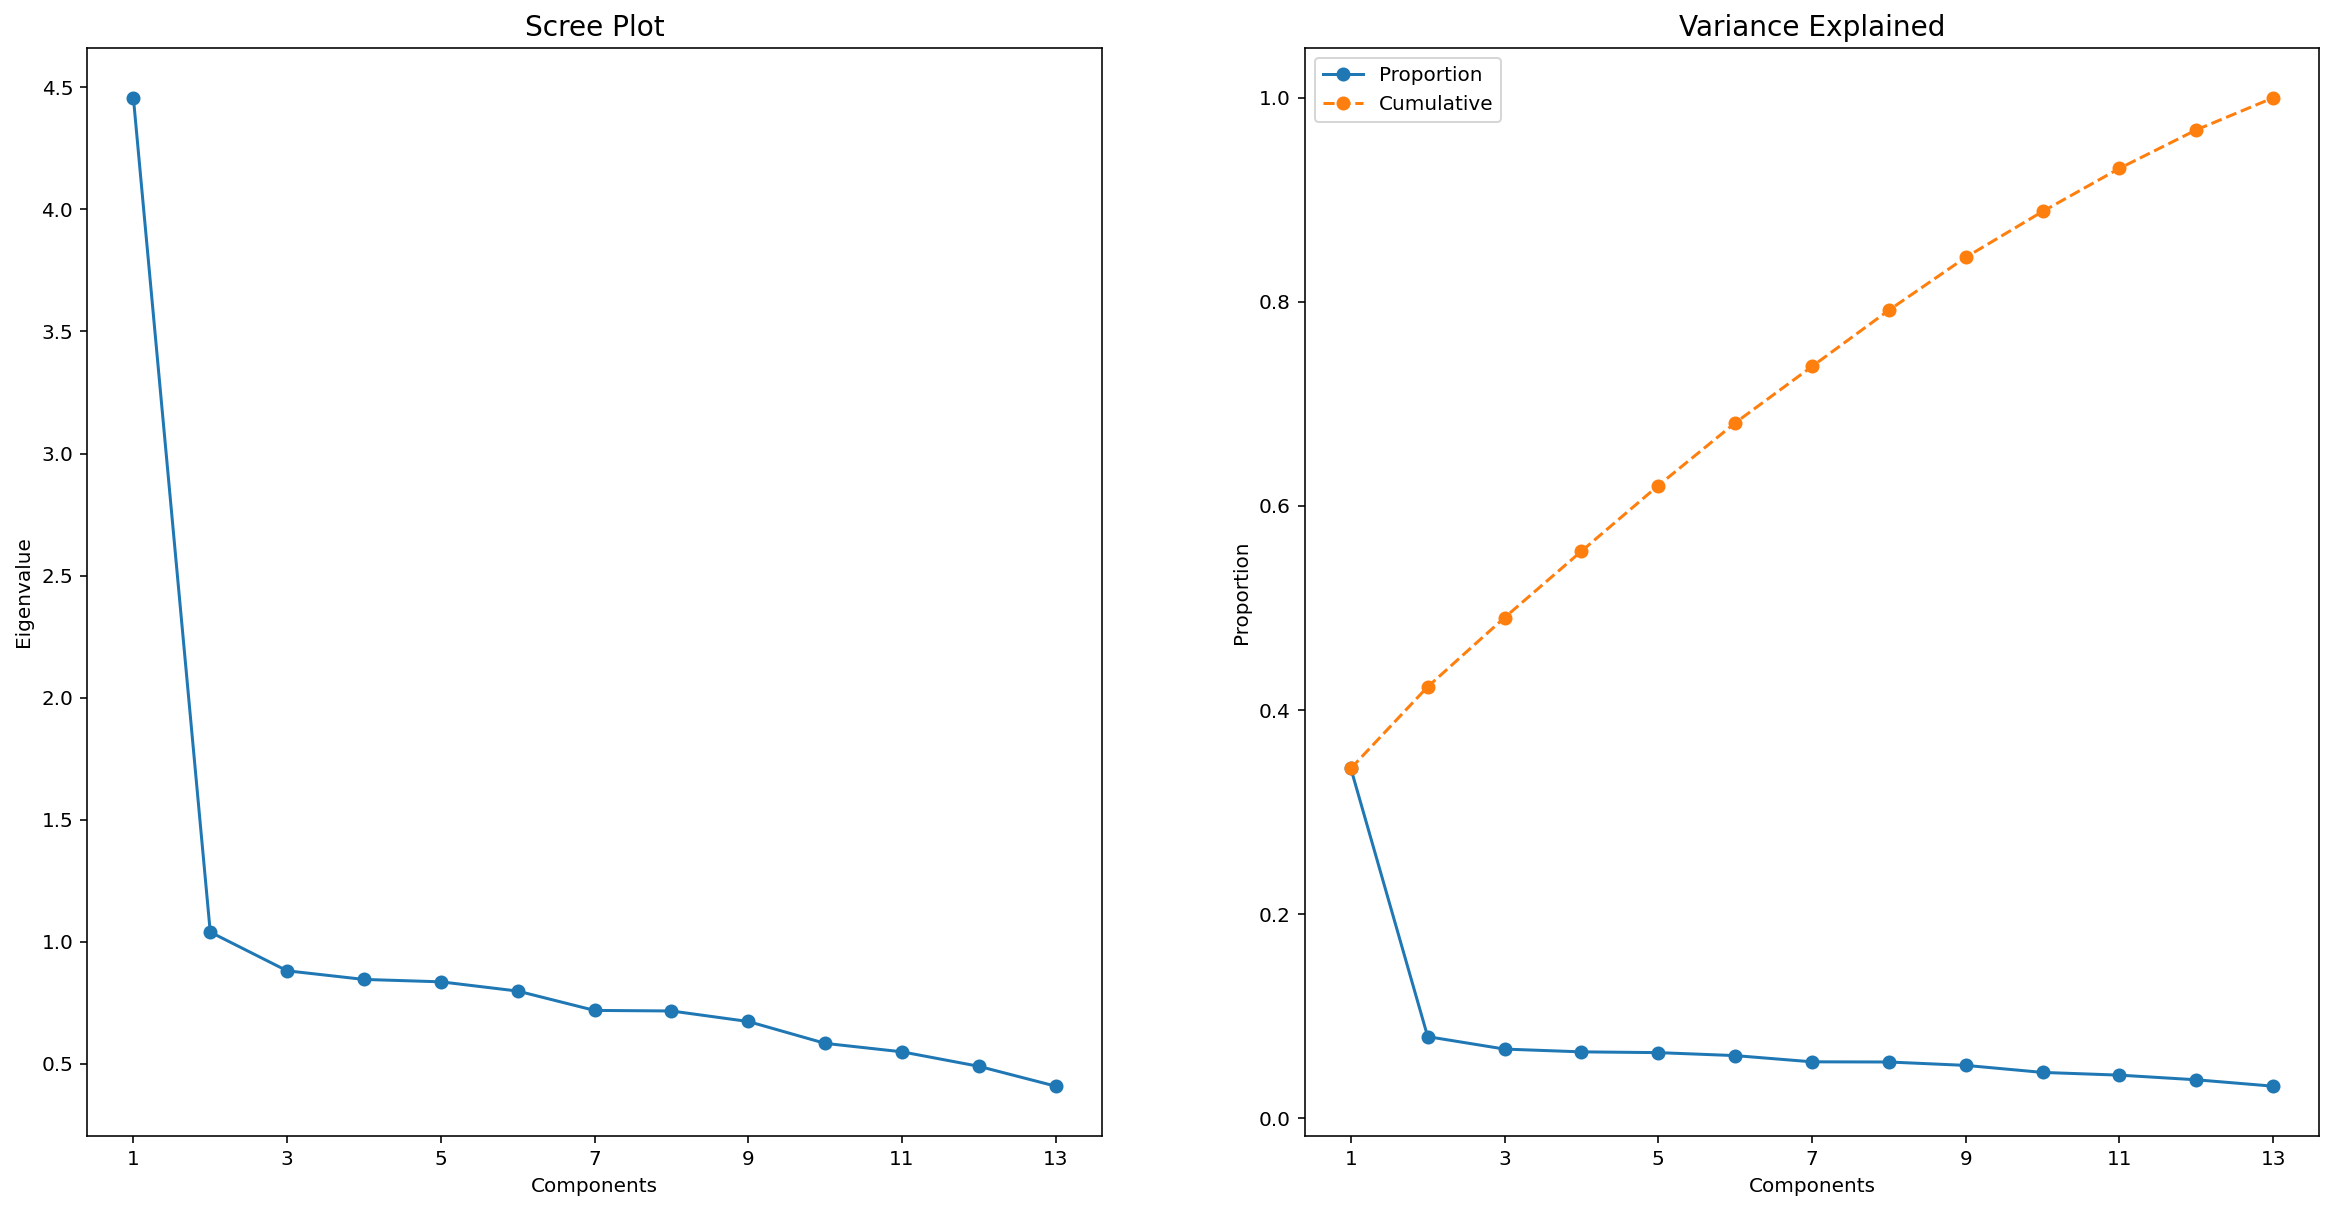

In [85]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")


ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [86]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=8)
pca_feat = pca.fit_transform(pca_ud[['COLLECT1','VETERANS', 'BIBLE', 'CATLG', 'PETS', 'CDPLAY', 'STEREO','PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'WALKER']])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=metric_features.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-1.214588,-0.045915,0.063142,-0.061699,0.056722,-0.014294,-0.020237,0.003539
1,-1.214588,-0.045915,0.063142,-0.061699,0.056722,-0.014294,-0.020237,0.003539
2,-1.214588,-0.045915,0.063142,-0.061699,0.056722,-0.014294,-0.020237,0.003539
3,-1.214588,-0.045915,0.063142,-0.061699,0.056722,-0.014294,-0.020237,0.003539
4,4.315706,2.210940,-0.594956,-2.293720,-1.842954,-3.069048,-2.673961,0.773180
...,...,...,...,...,...,...,...,...
95407,-1.214588,-0.045915,0.063142,-0.061699,0.056722,-0.014294,-0.020237,0.003539
95408,-1.214588,-0.045915,0.063142,-0.061699,0.056722,-0.014294,-0.020237,0.003539
95409,-1.214588,-0.045915,0.063142,-0.061699,0.056722,-0.014294,-0.020237,0.003539
95410,-1.214588,-0.045915,0.063142,-0.061699,0.056722,-0.014294,-0.020237,0.003539


In [87]:
df_pca = pd.concat([metric_features, pca_df], axis=1)

In [88]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[list((pca_ud[['COLLECT1','VETERANS', 'BIBLE', 'CATLG', 'PETS', 'CDPLAY', 'STEREO','PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'WALKER']]).columns) + pca_feat_names].corr().loc[list((pca_ud[['COLLECT1','VETERANS', 'BIBLE', 'CATLG', 'PETS', 'CDPLAY', 'STEREO','PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'WALKER']]).columns), pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
COLLECT1,0.422546,0.287080,0.659211,0.439922,-0.000453,-0.146895,0.168522,-0.005624
VETERANS,0.466901,0.200527,-0.260518,0.575589,-0.184947,0.484320,-0.179323,0.005524
BIBLE,0.468500,0.422180,-0.130294,-0.216637,-0.503397,-0.141766,0.348753,0.331192
CATLG,0.554166,-0.253709,-0.027645,0.111377,-0.021547,-0.318595,-0.464431,0.519509
PETS,0.707048,-0.143463,-0.123559,0.099912,0.134869,-0.119925,0.105683,-0.108328
CDPLAY,0.699185,-0.439141,-0.022108,0.049865,-0.080336,0.024467,0.114499,-0.077823
STEREO,0.717354,-0.162893,0.115851,-0.145740,-0.098935,0.020508,-0.002846,0.022225
PCOWNERS,0.608994,-0.469653,-0.008629,0.039572,-0.106353,0.024777,0.315972,-0.145024
PHOTO,0.493020,-0.003914,0.420317,-0.401388,0.111593,0.559564,-0.112536,0.187695
CRAFTS,0.573969,0.257357,0.132407,-0.091191,0.214692,-0.287730,-0.198473,-0.258144


######**PCA Hobbies Normal** 

In [89]:
users_data.columns

Index(['ODATEDW', 'STATE', 'ZIP', 'WRONG_ADRESS', 'PVASTATE', 'NOEXCH',
       'RECINHSE', 'RECP3', 'RECPGVG', 'HOMEOWNR', 'NUMCHLD', 'INCOME', 'HIT',
       'MBCRAFT', 'MBGARDEN', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE',
       'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO',
       'PUBOPP', 'PEPSTRFL', 'GEOCODE2', 'MALEMILI', 'MALEVET', 'VIETVETS',
       'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV', 'MAJOR', 'COLLECT1',
       'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY', 'STEREO',
       'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS', 'WALKER',
       'KIDSTUFF', 'CARDS', 'PLATES', 'CONTROLN', 'JOINT', 'FEMALE', 'AGE',
       'URBANICITY', 'SES', 'TOTGIFT_NAN'],
      dtype='object')

In [90]:
hobbies = users_data[['MBCRAFT',
       'MBGARDEN', 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN',
       'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN',  'PUBOPP']].dropna()

In [91]:
hobbies

,MBCRAFT,MBGARDEN,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBOPP
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,4.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
95400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95406,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
95408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
kmo_all,kmo_model = calculate_kmo(hobbies)
kmo_model 

0.756492388811248

In [93]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(hobbies)
scaled_feat

array([[-0.32355123, -0.22576119,  0.67194919, ..., -0.32628974,
         2.73433204, -0.27037375],
       [-0.32355123, -0.22576119, -0.54607677, ..., -0.32628974,
        -0.39209511, -0.27037375],
       [-0.32355123, -0.22576119, -0.54607677, ..., -0.32628974,
        -0.39209511,  0.86776335],
       ...,
       [-0.32355123, -0.22576119, -0.54607677, ..., -0.32628974,
        -0.39209511,  2.00590045],
       [-0.32355123, -0.22576119, -0.54607677, ..., -0.32628974,
        -0.39209511, -0.27037375],
       [-0.32355123, -0.22576119,  0.67194919, ..., -0.32628974,
        -0.39209511,  0.86776335]])

In [94]:
columns = hobbies.columns
hobbies = scaled_feat
hobbies = pd.DataFrame(hobbies)
hobbies.columns = columns
hobbies

,MBCRAFT,MBGARDEN,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBOPP
0,-0.323551,-0.225761,0.671949,2.293651,-0.237783,-0.28916,-0.339484,1.028515,-0.32629,2.734332,-0.270374
1,-0.323551,-0.225761,-0.546077,-0.331630,-0.237783,-0.28916,-0.339484,0.228436,-0.32629,-0.392095,-0.270374
2,-0.323551,-0.225761,-0.546077,-0.331630,-0.237783,-0.28916,-0.339484,-0.571644,-0.32629,-0.392095,0.867763
3,1.804028,-0.225761,4.326027,2.293651,-0.237783,-0.28916,-0.339484,2.628674,-0.32629,0.650047,0.867763
4,-0.323551,-0.225761,-0.546077,-0.331630,-0.237783,-0.28916,-0.339484,-0.571644,-0.32629,-0.392095,-0.270374
...,...,...,...,...,...,...,...,...,...,...,...
42553,-0.323551,-0.225761,-0.546077,-0.331630,-0.237783,-0.28916,-0.339484,-0.571644,-0.32629,-0.392095,-0.270374
42554,-0.323551,-0.225761,-0.546077,-0.331630,-0.237783,-0.28916,-0.339484,-0.571644,-0.32629,-0.392095,-0.270374
42555,-0.323551,-0.225761,-0.546077,-0.331630,-0.237783,-0.28916,1.997963,-0.571644,-0.32629,-0.392095,2.005900
42556,-0.323551,-0.225761,-0.546077,-0.331630,-0.237783,-0.28916,-0.339484,-0.571644,-0.32629,-0.392095,-0.270374


In [95]:
pca = PCA()
pca_feat = pca.fit_transform(hobbies)
pca_feat  

array([[ 1.45515521, -2.12236652, -0.50941771, ..., -1.78431181,
         0.42769941, -0.09235111],
       [-0.89079425,  0.14973781, -0.3776203 , ..., -0.19094709,
        -0.2908299 , -0.00913074],
       [-0.95404496, -0.12181428,  0.24571182, ...,  0.08954807,
         0.08921475, -0.02746435],
       ...,
       [ 0.12511766, -0.46036617, -0.32976556, ...,  1.64335011,
         1.02182311,  0.05778951],
       [-1.17602781,  0.2336087 , -0.04509779, ...,  0.02284333,
         0.17284259,  0.01114895],
       [-0.53774123, -0.48704674,  0.54960769, ...,  0.65514986,
        -0.4957296 ,  0.06191   ]])

In [96]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)).head(20)

,Eigenvalue,Difference,Proportion,Cumulative
1,3.159881,0.000000,0.287255,0.287255
2,1.326427,-1.833453,0.120581,0.407837
3,1.061058,-0.265369,0.096458,0.504294
4,0.981679,-0.079380,0.089241,0.593536
5,0.935443,-0.046236,0.085038,0.678574
6,0.752854,-0.182589,0.068440,0.747014
7,0.717316,-0.035538,0.065209,0.812223
8,0.702445,-0.014871,0.063857,0.876080
9,0.580869,-0.121576,0.052805,0.928885
10,0.472735,-0.108134,0.042975,0.971860


In [97]:
%matplotlib inline

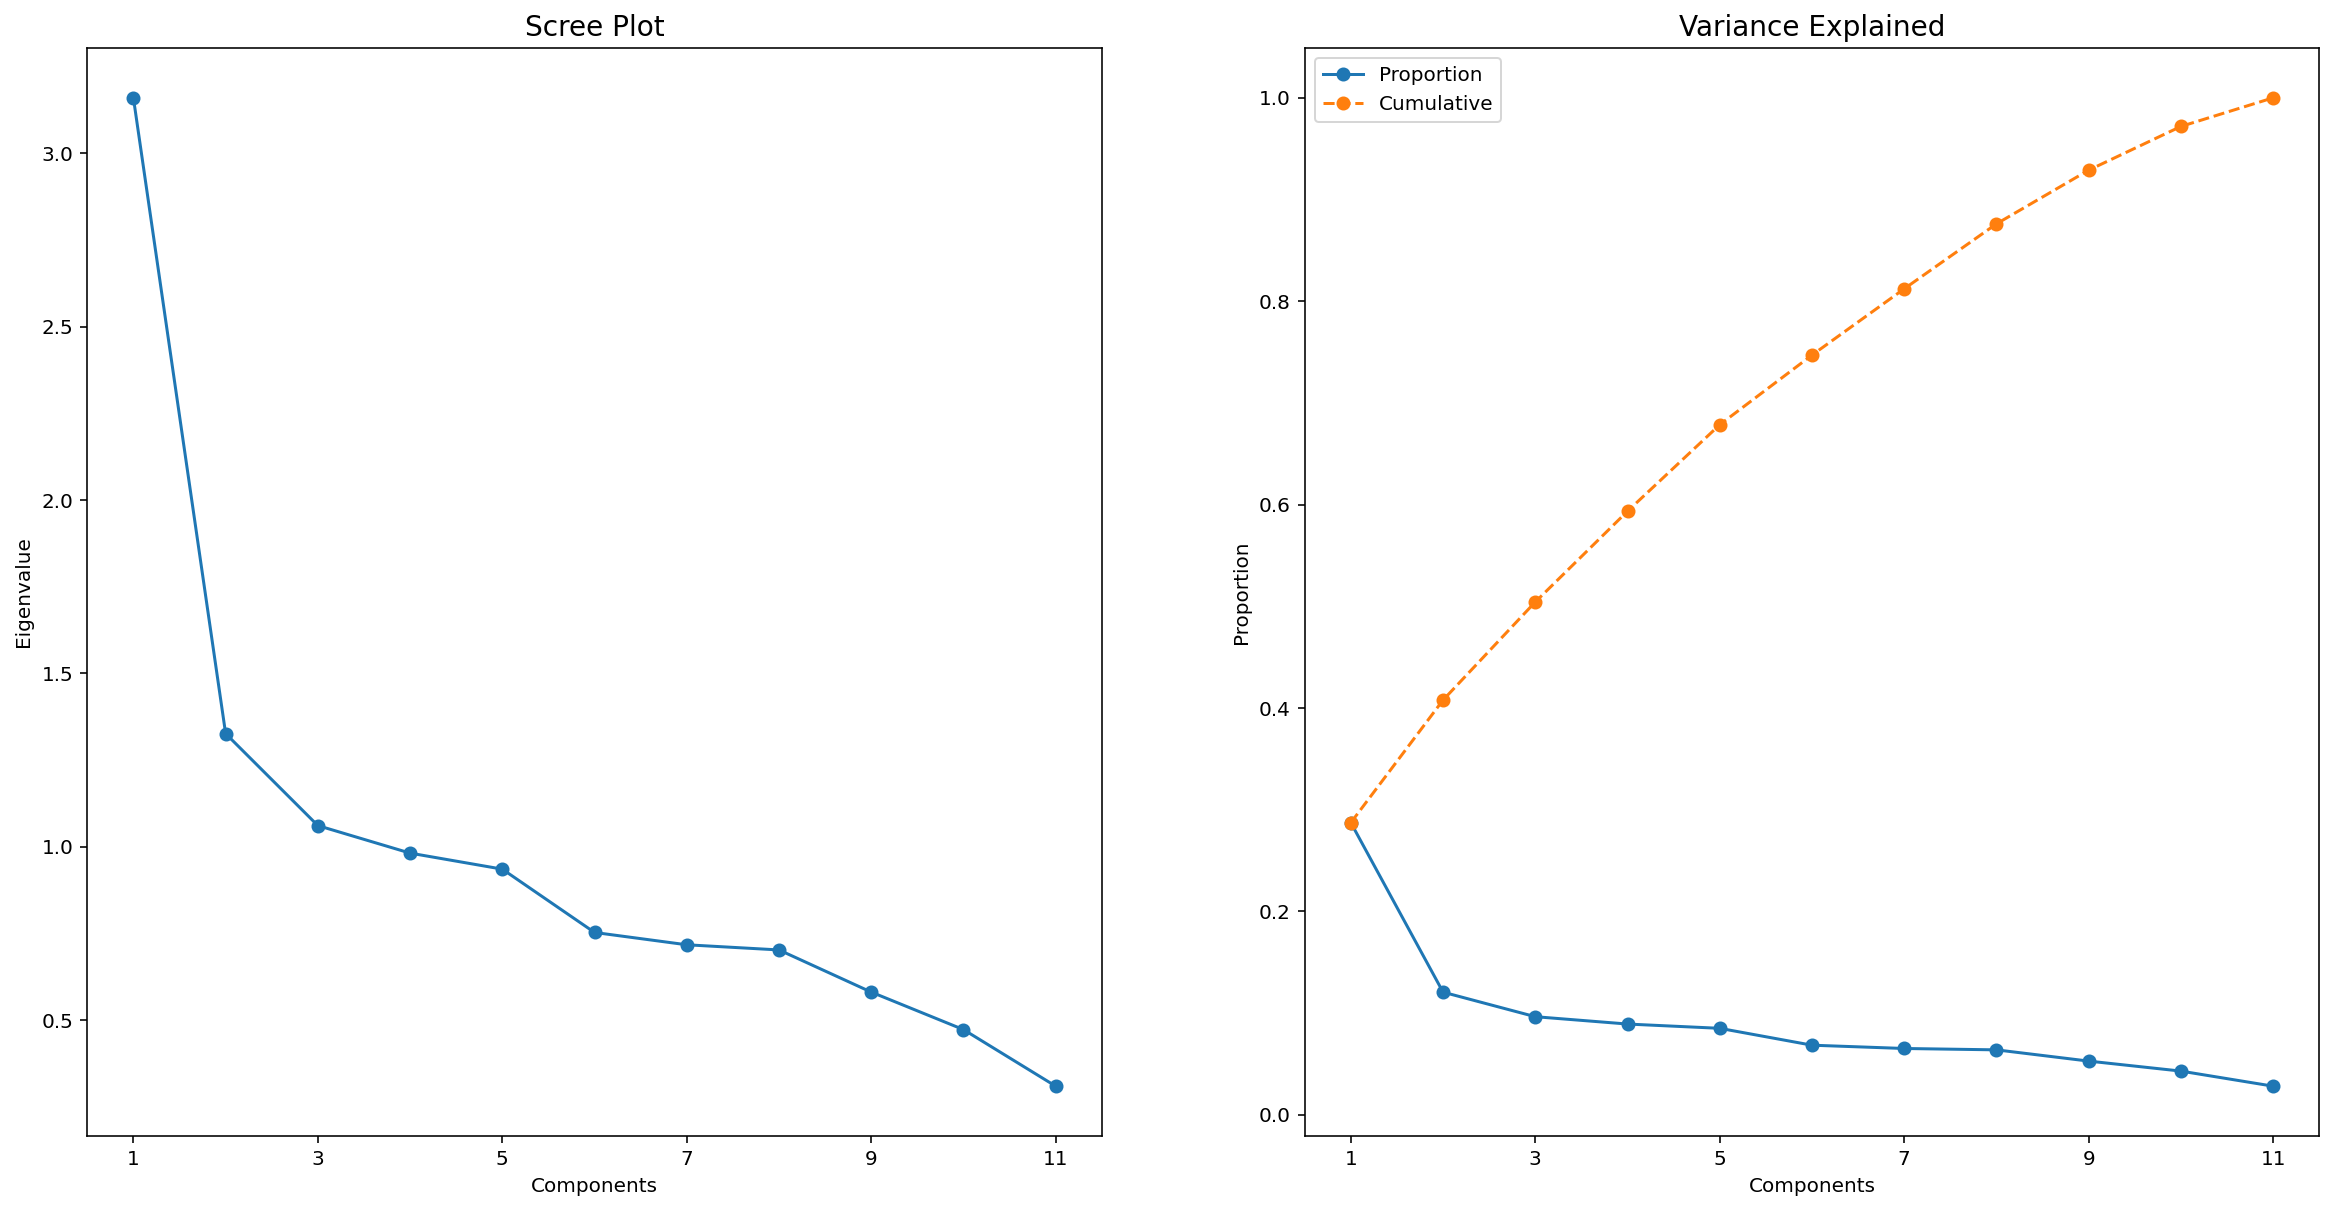

In [98]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")


ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [99]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=5)
pca_feat = pca.fit_transform(hobbies)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=hobbies.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2,PC3,PC4
0,1.455155,-2.122367,-0.509418,-0.515394,-0.966630
1,-0.890794,0.149738,-0.377620,0.037695,-0.011904
2,-0.954045,-0.121814,0.245712,0.707654,-0.358076
3,3.391684,-2.916987,1.049809,-2.004003,-0.912031
4,-1.176028,0.233609,-0.045098,0.035184,-0.020269
...,...,...,...,...,...
42553,-1.176028,0.233609,-0.045098,0.035184,-0.020269
42554,-1.176028,0.233609,-0.045098,0.035184,-0.020269
42555,0.125118,-0.460366,-0.329766,1.045723,-1.046497
42556,-1.176028,0.233609,-0.045098,0.035184,-0.020269


In [100]:
df_pca = pd.concat([hobbies, pca_df], axis=1)

In [101]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[list((hobbies).columns) + pca_feat_names].corr().loc[list((hobbies).columns), pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3,PC4
MBCRAFT,0.432793,0.054399,0.547894,-0.328185,-0.040061
MBGARDEN,0.409914,0.423122,0.481013,-0.038800,0.046103
MAGFAML,0.607553,-0.345342,0.257000,-0.195274,0.048831
MAGFEM,0.480846,-0.323484,-0.105156,-0.538670,-0.223112
MAGMALE,0.296248,-0.325574,0.004616,0.060511,0.867376
PUBGARDN,0.636407,0.492017,-0.226044,0.154470,0.039731
PUBCULIN,0.651869,0.008313,-0.381755,-0.141744,-0.145074
PUBHLTH,0.633721,-0.120730,-0.428107,0.003109,0.010112
PUBDOITY,0.694592,0.518165,0.003842,0.172302,0.072484
PUBNEWFN,0.531189,-0.399914,0.054308,0.352328,-0.129611


#####**Clustering Users Data** 

In [102]:
%matplotlib inline

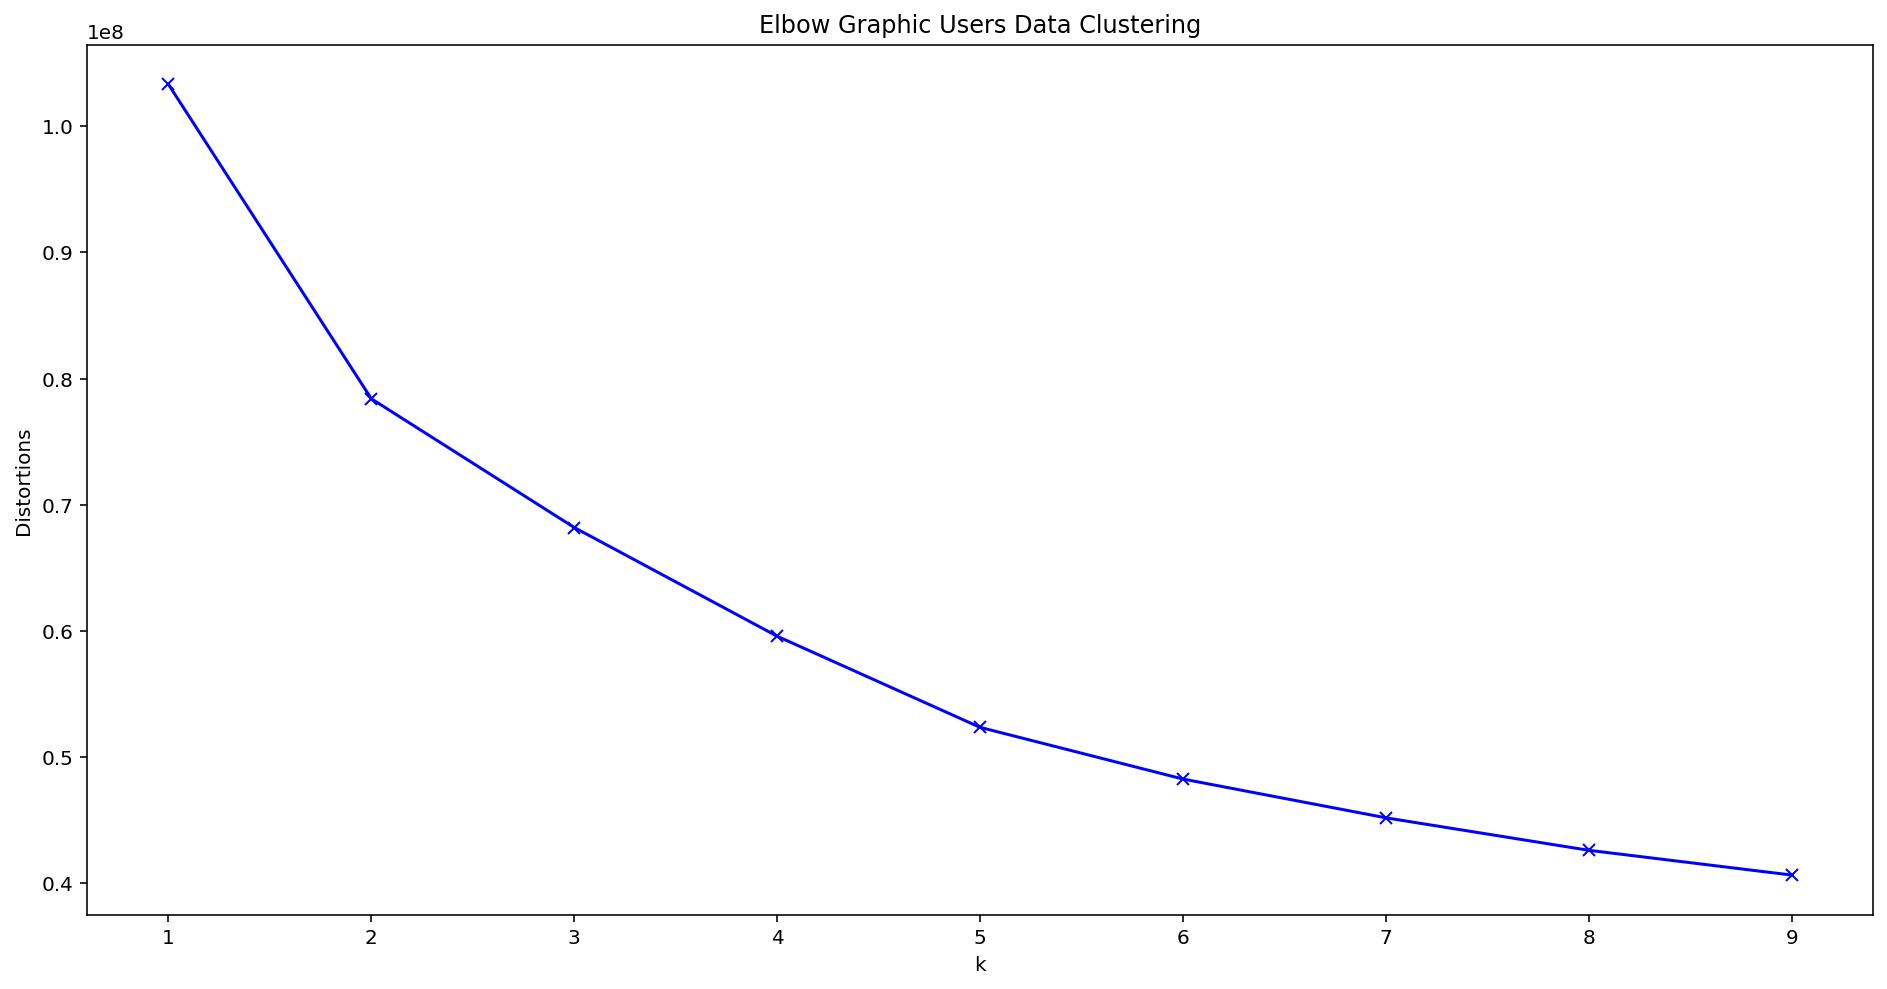

In [103]:
distortions = []
for k in range(1, 10):
    kmeanModel = KMeans(n_clusters=k).fit(metric_features)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(range(1, 10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Graphic Users Data Clustering')
plt.show()

In [104]:
kmclust = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=1)
# the fit method
kmclust.fit(metric_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [105]:
kmclust.predict(metric_features)

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

In [106]:
inertia = []
for n_clus in range(1, 11):  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=10, random_state=1)
    kmclust.fit(metric_features)
    inertia.append(kmclust.inertia_)  

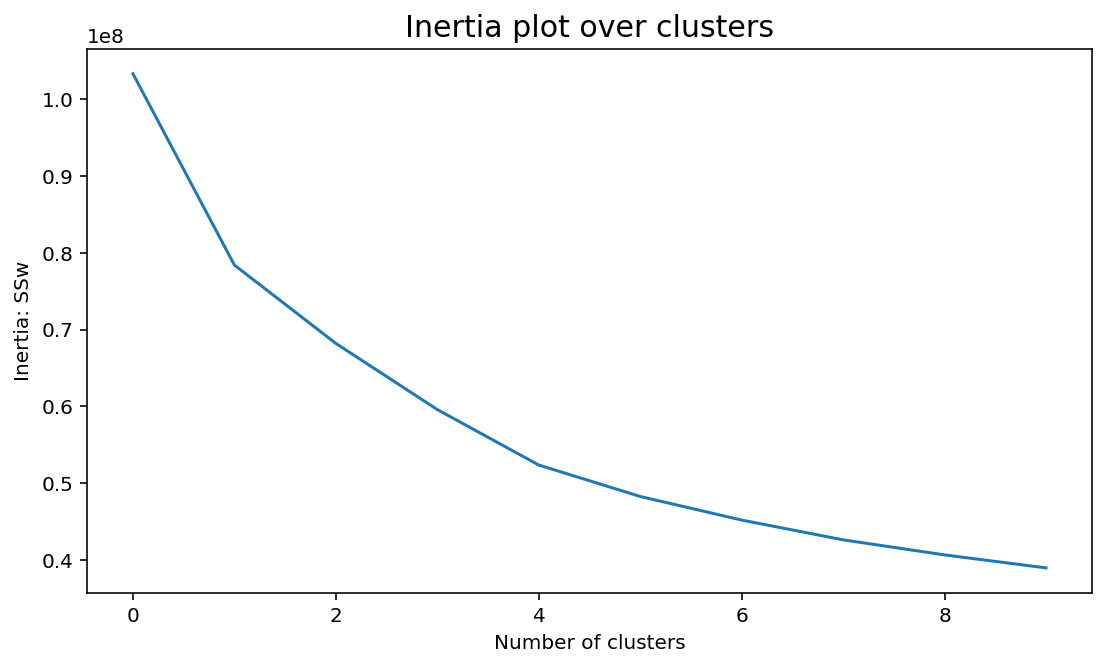

In [107]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [108]:
# final cluster solution
number_clusters = 2
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(metric_features)
km_labels

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

In [109]:
# Characterizing the final clusters
df_concat = pd.concat((metric_features, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,WRONG_ADRESS,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,HOMEOWNR,NUMCHLD,INCOME,HIT,PEPSTRFL,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,MAJOR,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,JOINT,FEMALE,AGE,URBANICITY,SES
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.014318,0.014785,0.003308,0.06387,0.021888,0.001271,0.553300,0.252416,4.273332,2.778258,0.451859,1.555898,27.288660,36.164526,21.127498,6.407148,4.496589,3.487542,0.003159,0.058151,0.107535,0.095198,0.085030,0.010505,0.166153,0.140862,0.141947,0.127049,0.051926,0.088787,0.080001,0.142582,0.023608,0.105198,0.018748,0.011813,0.006187,0.003757,0.539449,57.175084,1.796220,1.851362
1,0.015103,0.015795,0.003412,0.07840,0.020185,0.001098,0.542863,0.129292,3.957794,4.027318,0.503304,0.400711,34.474602,21.453749,47.329707,7.397800,4.660439,2.630067,0.002982,0.049889,0.111493,0.090139,0.079116,0.007754,0.129721,0.112567,0.124067,0.087896,0.047909,0.081741,0.067998,0.137762,0.018252,0.116265,0.012717,0.009758,0.005464,0.003913,0.534846,67.216634,1.900174,1.890583


### RFA


When it comes to the promotions sent and gifts received, we can divide the data in to 6 groups.
- ADATE_X's,
- RFA_X's,

Aggregations or derivates of the above two groups,
- RDATE_X's,
- RAMNT_X's,

Aggregations or derivates of the above two groups. Let's first take care of the aggregations or derivatives variables, as these will probably be the ones we will work with the most, since the other ones are to specific, which is great to do some coherence checks or create other variables, but not to cluster with.

In [110]:
#Typecast all of the date variables to their correct dtype
for i in ['ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7',
       'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13',
       'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17', 'ADATE_18', 'ADATE_19',
       'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24', "MAXADATE", 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24', "MINRDATE", "MAXRDATE", "LASTDATE", "FISTDATE", "NEXTDATE"]:
    rfa[i] =  pd.to_datetime(rfa[i], infer_datetime_format=True)

In [111]:
rfa[['CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12']].head() #The values seem fine

,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12
0,27,2017-02-01,74,6,14
1,12,2017-02-01,32,6,13
2,26,2017-02-01,63,6,14
3,27,2017-02-01,66,6,14
4,43,2017-02-01,113,10,25


In [112]:
rfa[['CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12']].isna().sum() #No missing values

CARDPROM    0
MAXADATE    0
NUMPROM     0
CARDPM12    0
NUMPRM12    0
dtype: int64

No incoherences of the type number of promotions received in the last 12 months being higher than in the lifetime.

In [113]:
rfa[(rfa['CARDPROM'] < rfa['CARDPM12']) | (rfa['NUMPROM'] < rfa['NUMPRM12'])].shape[0]

0

Nothing seems out of the ordinary, looking at the mean, std and min and max values maybe some outliers, but we will check this better later.

Most important is that there are no negative values

In [114]:
rfa[['CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12']].describe()

,CARDPROM,NUMPROM,CARDPM12,NUMPRM12
count,95412.000000,95412.000000,95412.000000,95412.000000
mean,18.435144,46.973347,5.348939,12.856936
std,8.583794,22.970378,1.219785,4.544033
min,1.000000,4.000000,0.000000,1.000000
25%,11.000000,27.000000,5.000000,11.000000
50%,18.000000,47.000000,6.000000,12.000000
75%,25.000000,64.000000,6.000000,13.000000
max,61.000000,195.000000,19.000000,78.000000


All of the types are correct

In [115]:
rfa[['CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12']].dtypes

CARDPROM             int64
MAXADATE    datetime64[ns]
NUMPROM              int64
CARDPM12             int64
NUMPRM12             int64
dtype: object

In [116]:
rfa[['RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']].head()

,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT
0,240.0,31,14,5.0,2012-08-01,12.0,2014-02-01,10.0,2015-12-01,2009-11-01,2010-03-01,4.0,7.741935
1,47.0,3,1,10.0,2013-10-01,25.0,2015-12-01,25.0,2015-12-01,2013-10-01,2015-04-01,18.0,15.666667
2,202.0,27,14,2.0,2011-11-01,16.0,2012-07-01,5.0,2015-12-01,2010-01-01,2011-01-01,12.0,7.481481
3,109.0,16,7,2.0,2007-11-01,11.0,2014-11-01,10.0,2015-12-01,2007-02-01,2007-11-01,9.0,6.812500
4,254.0,37,8,3.0,2013-10-01,15.0,2016-01-01,15.0,2016-01-01,1999-03-01,2000-05-01,14.0,6.864865


All of the dtypes seem to be correct except the TIMELAG one, it should be int since the variable corresponds to the number of months between the first and second gift

In [117]:
rfa[['RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']].dtypes

RAMNTALL           float64
NGIFTALL             int64
CARDGIFT             int64
MINRAMNT           float64
MINRDATE    datetime64[ns]
MAXRAMNT           float64
MAXRDATE    datetime64[ns]
LASTGIFT           float64
LASTDATE    datetime64[ns]
FISTDATE    datetime64[ns]
NEXTDATE    datetime64[ns]
TIMELAG            float64
AVGGIFT            float64
dtype: object

As we can see this is because of missing values.

But are these actual missing values or observations were a donor simply gave just one gift?

In [118]:
rfa['TIMELAG'].isna().sum()

9973

As we can see all of the TIMELAG missing values are observations where a donor simply gave on gift.

So we can't just impute these missing values, we have to change them into something if we want to use this variable.

**Ainda nada foi feito quanto a isto**

In [119]:
rfa[(rfa['TIMELAG'].isna()) & (rfa['NGIFTALL'] == 1)].shape[0]

9973

However there are some observations were only one gift was donated but a value for TIMELAG exists

In [120]:
rfa[rfa['NGIFTALL'] == 1 & ~(rfa['TIMELAG'].isna())].shape[0]

35

When this value is zero, this means that just one donation was made but there is a value for NEXTDATE and it is the same as the FISTDATE. We could leave them , we just have to be carefull when interpreting zeros in this variable, as they can mean both someone who just donated once or someone who made the first two donations on the same day. If we leave these two interpretations open we can also change the missing values of TIMELAG, wich all correspond to someone who made just one gift, to zero.

Or we can delete all of these observations, making sure that there isn't any possibility of a wrong assumption being made.

The bigger problem is when someone made just one donation but the TIMELAG isn't zero. These values for sure need to be deleted.

In [121]:
(rfa['TIMELAG'][rfa['NGIFTALL'] == 1 & ~(rfa['TIMELAG'].isna())] == 0).value_counts()

False    28
True      7
Name: TIMELAG, dtype: int64

Since there are so few values that have this problem we will just delete all of them to be sure we aren't doing any assumption that jeperdizes our analysis.

In [122]:
#############################################################

rfa = rfa[~(rfa['NGIFTALL'] == 1 & ~(rfa['TIMELAG'].isna()))]

There are also some observations were the TIMELAG is zero but more than one gift was given.

In [123]:
rfa[(rfa['TIMELAG'] == 0) & (rfa['NGIFTALL'] > 1)].shape[0]

897

There are now 897 observations were supposedly the first gift was given in the same date as the second.

In [124]:
rfa[rfa['FISTDATE'] == rfa['NEXTDATE']].shape[0]

897

And all of these dates have a TIMELAG of zero.

So we can assume that all of the observations were a donor gave more than one gift but the TIMELAG is zero are correct values, since, at least the first and second gift could be given on the same day.

In [125]:
rfa[(rfa['FISTDATE'] == rfa['NEXTDATE']) & (rfa['TIMELAG'] == 0)].shape[0]

897

All of the other variables don't have any missing values, except FISTDATE, wich we will take care of later.

In [126]:
rfa[['RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']].isna().sum()

RAMNTALL       0
NGIFTALL       0
CARDGIFT       0
MINRAMNT       0
MINRDATE       0
MAXRAMNT       0
MAXRDATE       0
LASTGIFT       0
LASTDATE       0
FISTDATE       2
NEXTDATE    9973
TIMELAG     9973
AVGGIFT        0
dtype: int64

And no incoherences seem to exist, at least of the type total number of promotions received being smaller than total number of card promotions, date of the first gift being more recent than date of the second gift and smallest donation done being more expensive than highest donation.

And through the describe function we can see that there are no weird negative values, and that some outlier detection migth be needed.

In [127]:
rfa[(rfa['NGIFTALL'] < rfa['CARDGIFT']) | (rfa['FISTDATE'] > rfa['NEXTDATE']) | (rfa['MINRAMNT'] > rfa['MAXRAMNT'])].shape[0]

0

In [128]:
rfa[['RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']].describe().T

,count,mean,std,min,25%,50%,75%,max
RAMNTALL,95377.0,104.518867,118.591786,13.000000,40.000000,78.000000,131.000000,9485.0
NGIFTALL,95377.0,9.605188,8.554323,1.000000,3.000000,7.000000,13.000000,237.0
CARDGIFT,95377.0,5.059805,4.526739,0.000000,2.000000,4.000000,7.000000,41.0
MINRAMNT,95377.0,7.936567,8.784527,0.000000,3.000000,5.000000,10.000000,1000.0
MAXRAMNT,95377.0,19.998301,25.070689,5.000000,14.000000,17.000000,23.000000,5000.0
LASTGIFT,95377.0,17.316880,13.955852,0.000000,10.000000,15.000000,20.000000,1000.0
TIMELAG,85404.0,8.094012,8.213794,0.000000,4.000000,6.000000,11.000000,1088.0
AVGGIFT,95377.0,13.343856,10.766446,1.285714,8.384615,11.634146,15.458333,1000.0


As we can see both observations with missing values on FISTDATE have given a lot of gifts, have both values of the second gift given and have a clearly wrong value for TIMELAG. 1044 months is equivelent to 87 years, so it is safe to assume that we can drop these two records.

In [129]:
rfa[['NGIFTALL', 'NEXTDATE', 'TIMELAG']][rfa['FISTDATE'].isna()]

,NGIFTALL,NEXTDATE,TIMELAG
83217,26,2006-12-01,1044.0
93811,48,2010-08-01,1088.0


In [130]:
#####################################

rfa = rfa[~(rfa['FISTDATE'].isna())]

FISTDATE and ODATEDW supposedly have the same information, however in most observations this isn't the case, possibly due to the source of this variables being different.

Since we are not going to use directly any of this variables, and FISTDATE comes from the same source as all of the corresponding promotion and gifts variables, we will drop ODATEDW. Even though we wil also later drop or not use FISTDATE.

In [131]:
rfa['FISTDATE'].isna().sum()

0

In [132]:
users_data['ODATEDW'].isna().sum()

0

In [133]:
users_data['ODATEDW'] = pd.to_datetime(users_data['ODATEDW'], infer_datetime_format=True)

In [134]:
##########################É preciso por ODATEDW no rfa no início do notebook e alterar aqui######

#(users_data['ODATEDW'] != rfa['FISTDATE']).sum()

In [135]:
#############Aqui tmb!!!!!!!!!!!!!!!!!!!!!!####################

#users_data.drop(columns = ['ODATEDW'], inplace = True)

Lastly we can see if the timelag value is correct.

And as we can see it is.

In [136]:
((((rfa['NEXTDATE'].apply(lambda x: x.year) - rfa['FISTDATE'].apply(lambda x: x.year)) * 12 + rfa['NEXTDATE'].apply(lambda x: x.month) - rfa['FISTDATE'].apply(lambda x: x.month)) != rfa['TIMELAG']) & ~(rfa['TIMELAG'].isna()) & ~(rfa['NEXTDATE'].isna()) & ~(rfa['FISTDATE'].isna())).value_counts()

False    95375
dtype: int64

**ADATE_X, RDATE_X and LASTDATE Treatment**

As we can see we have a lot of missing values in most of these variables., which most likely correspond to promotions or gifts that weren't sent.

In [137]:
rfa[['ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7',
       'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13',
       'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17', 'ADATE_18', 'ADATE_19',
       'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24', 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24']].isna().sum()

ADATE_2         0
ADATE_3      1947
ADATE_4      2188
ADATE_5     33554
ADATE_6      3552
ADATE_7      8873
ADATE_8      3511
ADATE_9     11217
ADATE_10    32717
ADATE_11    10399
ADATE_12     8900
ADATE_13    40184
ADATE_14    18839
ADATE_15    65441
ADATE_16    20329
ADATE_17    27615
ADATE_18    21228
ADATE_19    24445
ADATE_20    50163
ADATE_21    35176
ADATE_22    25613
ADATE_23    56235
ADATE_24    36938
RDATE_3     95134
RDATE_4     95095
RDATE_5     95366
RDATE_6     94599
RDATE_7     86483
RDATE_8     73922
RDATE_9     78641
RDATE_10    84914
RDATE_11    80638
RDATE_12    69681
RDATE_13    83126
RDATE_14    72063
RDATE_15    88113
RDATE_16    68381
RDATE_17    85975
RDATE_18    75598
RDATE_19    79499
RDATE_20    87488
RDATE_21    85862
RDATE_22    74503
RDATE_23    87516
RDATE_24    77638
dtype: int64

**Coherence Checks for the date variables**

The recency code, for the most recent promotion date, tells us every donor was a lapsed donor at the date the promotion was sent

The promotion was sent on 2017, either on the first of june or first of april. 

To see if this information is correct we can try and see if any donor's gift had been received less than 13 months prior to this donation being sent, and as we can see this didn't happen.

**However there are still some donors who sent a gift after receiving this promotion, should we delete them?**

In [138]:
rfa['RFA_2R'].value_counts()

L    95375
Name: RFA_2R, dtype: int64

In [139]:
rfa['ADATE_2'].value_counts()

2017-06-01    95362
2017-04-01       13
Name: ADATE_2, dtype: int64

In [140]:
for i in ['RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24']:
    

    print(i, ((((rfa['ADATE_2'].apply(lambda x: x.year) - rfa[i].apply(lambda x: x.year)) * 12 + rfa['ADATE_2'].apply(lambda x: x.month) - rfa[i].apply(lambda x: x.month)) < 13) &(
    ((rfa['ADATE_2'].apply(lambda x: x.year) - rfa[i].apply(lambda x: x.year)) * 12 + rfa['ADATE_2'].apply(lambda x: x.month) - rfa[i].apply(lambda x: x.month)) > 0)).sum())

RDATE_3 227
RDATE_4 94
RDATE_5 4
RDATE_6 15
RDATE_7 4
RDATE_8 13
RDATE_9 2
RDATE_10 0
RDATE_11 2
RDATE_12 1
RDATE_13 0
RDATE_14 0
RDATE_15 0
RDATE_16 0
RDATE_17 0
RDATE_18 0
RDATE_19 0
RDATE_20 0
RDATE_21 0
RDATE_22 0
RDATE_23 0
RDATE_24 0


In [141]:
rfa['LASTDATE'].isna().sum() #All donors have a LASTDATE

0

We can check wether there are any observations were the LASTDATE isn't more recent than RDATE_X.

In [142]:
(rfa[(rfa['LASTDATE'] < rfa['RDATE_3']) |
     (rfa['LASTDATE'] < rfa['RDATE_4']) |
     (rfa['LASTDATE'] < rfa['RDATE_5']) |
     (rfa['LASTDATE'] < rfa['RDATE_6']) |
     (rfa['LASTDATE'] < rfa['RDATE_7']) |
     (rfa['LASTDATE'] < rfa['RDATE_8']) |
     (rfa['LASTDATE'] < rfa['RDATE_9']) |
     (rfa['LASTDATE'] < rfa['RDATE_10']) |
     (rfa['LASTDATE'] < rfa['RDATE_11']) |
     (rfa['LASTDATE'] < rfa['RDATE_12']) |
     (rfa['LASTDATE'] < rfa['RDATE_13']) |
     (rfa['LASTDATE'] < rfa['RDATE_14']) |
     (rfa['LASTDATE'] < rfa['RDATE_15']) |
     (rfa['LASTDATE'] < rfa['RDATE_16']) |
     (rfa['LASTDATE'] < rfa['RDATE_17']) |
     (rfa['LASTDATE'] < rfa['RDATE_18']) |
     (rfa['LASTDATE'] < rfa['RDATE_19']) |
     (rfa['LASTDATE'] < rfa['RDATE_20']) |
     (rfa['LASTDATE'] < rfa['RDATE_21']) |
     (rfa['LASTDATE'] < rfa['RDATE_22']) |
     (rfa['LASTDATE'] < rfa['RDATE_23']) |
     (rfa['LASTDATE'] < rfa['RDATE_24']) ].shape[0] / rfa.shape[0]) * 100

0.08283093053735256

Only 0.08% of observations have this problem, we can just change the value of LASTDATE, guarantying that this is infact the last known date a donor gave a gift.

In [143]:
rfa['LASTDATE'][(rfa['LASTDATE'] < rfa['RDATE_3']) |
     (rfa['LASTDATE'] < rfa['RDATE_4']) |
     (rfa['LASTDATE'] < rfa['RDATE_5']) |
     (rfa['LASTDATE'] < rfa['RDATE_6']) |
     (rfa['LASTDATE'] < rfa['RDATE_7']) |
     (rfa['LASTDATE'] < rfa['RDATE_8']) |
     (rfa['LASTDATE'] < rfa['RDATE_9']) |
     (rfa['LASTDATE'] < rfa['RDATE_10']) |
     (rfa['LASTDATE'] < rfa['RDATE_11']) |
     (rfa['LASTDATE'] < rfa['RDATE_12']) |
     (rfa['LASTDATE'] < rfa['RDATE_13']) |
     (rfa['LASTDATE'] < rfa['RDATE_14']) |
     (rfa['LASTDATE'] < rfa['RDATE_15']) |
     (rfa['LASTDATE'] < rfa['RDATE_16']) |
     (rfa['LASTDATE'] < rfa['RDATE_17']) |
     (rfa['LASTDATE'] < rfa['RDATE_18']) |
     (rfa['LASTDATE'] < rfa['RDATE_19']) |
     (rfa['LASTDATE'] < rfa['RDATE_20']) |
     (rfa['LASTDATE'] < rfa['RDATE_21']) |
     (rfa['LASTDATE'] < rfa['RDATE_22']) |
     (rfa['LASTDATE'] < rfa['RDATE_23']) |
     (rfa['LASTDATE'] < rfa['RDATE_24']) ] = rfa[['RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
                                                  'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14', 'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20', 'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24']][
    (rfa['LASTDATE'] < rfa['RDATE_3']) |
     (rfa['LASTDATE'] < rfa['RDATE_4']) |
     (rfa['LASTDATE'] < rfa['RDATE_5']) |
     (rfa['LASTDATE'] < rfa['RDATE_6']) |
     (rfa['LASTDATE'] < rfa['RDATE_7']) |
     (rfa['LASTDATE'] < rfa['RDATE_8']) |
     (rfa['LASTDATE'] < rfa['RDATE_9']) |
     (rfa['LASTDATE'] < rfa['RDATE_10']) |
     (rfa['LASTDATE'] < rfa['RDATE_11']) |
     (rfa['LASTDATE'] < rfa['RDATE_12']) |
     (rfa['LASTDATE'] < rfa['RDATE_13']) |
     (rfa['LASTDATE'] < rfa['RDATE_14']) |
     (rfa['LASTDATE'] < rfa['RDATE_15']) |
     (rfa['LASTDATE'] < rfa['RDATE_16']) |
     (rfa['LASTDATE'] < rfa['RDATE_17']) |
     (rfa['LASTDATE'] < rfa['RDATE_18']) |
     (rfa['LASTDATE'] < rfa['RDATE_19']) |
     (rfa['LASTDATE'] < rfa['RDATE_20']) |
     (rfa['LASTDATE'] < rfa['RDATE_21']) |
     (rfa['LASTDATE'] < rfa['RDATE_22']) |
     (rfa['LASTDATE'] < rfa['RDATE_23']) |
     (rfa['LASTDATE'] < rfa['RDATE_24']) ].max(axis = 1)

In theory, the LASTDATE should be one of the values of RDATE_X, however for 13% of observations this isn't the case.
But there is always the possibility that the last gift didn't correspond to any of the promotions we have on our dataset.

Since there are so many observations where this happens, we think the problem is in our initial assumption and not on the data itself.

In [144]:
(rfa[(rfa['LASTDATE'] != rfa['RDATE_3']) &
     (rfa['LASTDATE'] != rfa['RDATE_4']) &
     (rfa['LASTDATE'] != rfa['RDATE_5']) &
     (rfa['LASTDATE'] != rfa['RDATE_6']) &
     (rfa['LASTDATE'] != rfa['RDATE_7']) &
     (rfa['LASTDATE'] != rfa['RDATE_8']) &
     (rfa['LASTDATE'] != rfa['RDATE_9']) &
     (rfa['LASTDATE'] != rfa['RDATE_10']) &
     (rfa['LASTDATE'] != rfa['RDATE_11']) &
     (rfa['LASTDATE'] != rfa['RDATE_12']) &
     (rfa['LASTDATE'] != rfa['RDATE_13']) &
     (rfa['LASTDATE'] != rfa['RDATE_14']) &
     (rfa['LASTDATE'] != rfa['RDATE_15']) &
     (rfa['LASTDATE'] != rfa['RDATE_16']) &
     (rfa['LASTDATE'] != rfa['RDATE_17']) &
     (rfa['LASTDATE'] != rfa['RDATE_18']) &
     (rfa['LASTDATE'] != rfa['RDATE_19']) &
     (rfa['LASTDATE'] != rfa['RDATE_20']) &
     (rfa['LASTDATE'] != rfa['RDATE_21']) &
     (rfa['LASTDATE'] != rfa['RDATE_22']) &
     (rfa['LASTDATE'] != rfa['RDATE_23']) &
     (rfa['LASTDATE'] != rfa['RDATE_24']) ].shape[0] / rfa.shape[0]) * 100

13.299082568807338

It doesn't make sense for a donor to give a gift regarding a promotion he hasn't received yet.

In [145]:
(rfa[(rfa['RDATE_3'] < rfa['ADATE_3']) |
     (rfa['RDATE_4'] < rfa['ADATE_4']) |
     (rfa['RDATE_5'] < rfa['ADATE_5']) |
     (rfa['RDATE_6'] < rfa['ADATE_6']) |
     (rfa['RDATE_7'] < rfa['ADATE_7']) |
     (rfa['RDATE_8'] < rfa['ADATE_8']) |
     (rfa['RDATE_9'] < rfa['ADATE_9']) |
     (rfa['RDATE_10'] < rfa['ADATE_10']) |
     (rfa['RDATE_11'] < rfa['ADATE_11']) |
     (rfa['RDATE_12'] < rfa['ADATE_12']) |
     (rfa['RDATE_13'] < rfa['ADATE_13']) |
     (rfa['RDATE_14'] < rfa['ADATE_14']) |
     (rfa['RDATE_15'] < rfa['ADATE_15']) |
     (rfa['RDATE_16'] < rfa['ADATE_16']) |
     (rfa['RDATE_17'] < rfa['ADATE_17']) |
     (rfa['RDATE_18'] < rfa['ADATE_18']) |
     (rfa['RDATE_19'] < rfa['ADATE_19']) |
     (rfa['RDATE_20'] < rfa['ADATE_20']) |
     (rfa['RDATE_21'] < rfa['ADATE_21']) |
     (rfa['RDATE_22'] < rfa['ADATE_22']) |
     (rfa['RDATE_23'] < rfa['ADATE_23']) |
     (rfa['RDATE_24'] < rfa['ADATE_24']) ].shape[0] / rfa.shape[0]) * 100

0.8566186107470511

0.8% of data points have this issue, so we will delete them.

In [146]:
rfa = rfa[~((rfa['RDATE_3'] < rfa['ADATE_3']) |
     (rfa['RDATE_4'] < rfa['ADATE_4']) |
     (rfa['RDATE_5'] < rfa['ADATE_5']) |
     (rfa['RDATE_6'] < rfa['ADATE_6']) |
     (rfa['RDATE_7'] < rfa['ADATE_7']) |
     (rfa['RDATE_8'] < rfa['ADATE_8']) |
     (rfa['RDATE_9'] < rfa['ADATE_9']) |
     (rfa['RDATE_10'] < rfa['ADATE_10']) |
     (rfa['RDATE_11'] < rfa['ADATE_11']) |
     (rfa['RDATE_12'] < rfa['ADATE_12']) |
     (rfa['RDATE_13'] < rfa['ADATE_13']) |
     (rfa['RDATE_14'] < rfa['ADATE_14']) |
     (rfa['RDATE_15'] < rfa['ADATE_15']) |
     (rfa['RDATE_16'] < rfa['ADATE_16']) |
     (rfa['RDATE_17'] < rfa['ADATE_17']) |
     (rfa['RDATE_18'] < rfa['ADATE_18']) |
     (rfa['RDATE_19'] < rfa['ADATE_19']) |
     (rfa['RDATE_20'] < rfa['ADATE_20']) |
     (rfa['RDATE_21'] < rfa['ADATE_21']) |
     (rfa['RDATE_22'] < rfa['ADATE_22']) |
     (rfa['RDATE_23'] < rfa['ADATE_23']) |
     (rfa['RDATE_24'] < rfa['ADATE_24']))]

**RFA_x and RAMNT_X Treatment**

Descobrir coherence checks para estas variáveis ou então uma boa desculpa para n os fazermos!!!!!!!!!!!!!!!!!!!

In [147]:
#separar todos os primeiros bytes de rfa e fazer colunas com numero de vezes em cada categoria

#falar que so vamos utilizar o ultimo estado total

All variables have the correct dtype.

No negative values, some outliers for sure, but if we are not going to use these variables, since the outliers seem to be correct values, just extreme, there is no point in removing the records.

There is one record were the value of the smallest donation is higher than one of the gifts given in one of the various promotions and 23 records were the highest donation is smaller than one of the gifts of the various promotions. So we will correct these values.

In [148]:
rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']].dtypes

RAMNT_3     float64
RAMNT_4     float64
RAMNT_5     float64
RAMNT_6     float64
RAMNT_7     float64
RAMNT_8     float64
RAMNT_9     float64
RAMNT_10    float64
RAMNT_11    float64
RAMNT_12    float64
RAMNT_13    float64
RAMNT_14    float64
RAMNT_15    float64
RAMNT_16    float64
RAMNT_17    float64
RAMNT_18    float64
RAMNT_19    float64
RAMNT_20    float64
RAMNT_21    float64
RAMNT_22    float64
RAMNT_23    float64
RAMNT_24    float64
dtype: object

In [149]:
rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']].describe().T

,count,mean,std,min,25%,50%,75%,max
RAMNT_3,205.0,12.375610,9.502342,2.00,6.0,10.0,15.0,50.0
RAMNT_4,147.0,16.328367,16.944711,1.00,9.0,11.0,17.0,100.0
RAMNT_5,9.0,17.000000,14.908052,4.00,8.0,12.0,20.0,50.0
RAMNT_6,629.0,14.297075,10.116250,1.00,8.0,12.0,19.0,100.0
RAMNT_7,8786.0,15.108312,11.014661,1.00,10.0,15.0,20.0,250.0
RAMNT_8,21208.0,15.681145,12.167803,1.00,10.0,15.0,20.0,500.0
RAMNT_9,16526.0,15.115355,13.014389,1.00,10.0,14.0,20.0,1000.0
RAMNT_10,10387.0,15.421686,12.371237,0.30,10.0,14.0,20.0,500.0
RAMNT_11,14594.0,14.594437,10.731090,1.00,9.0,12.0,20.0,300.0
RAMNT_12,25409.0,14.884724,10.874716,1.00,10.0,13.0,20.0,300.0


In [150]:
rfa[(rfa['MINRAMNT'] > rfa['RAMNT_3']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_4']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_5']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_6']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_7']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_8']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_9']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_10']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_11']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_12']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_13']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_14']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_15']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_16']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_17']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_18']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_19']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_20']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_21']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_22']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_23']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_24'])].shape[0]

1

In [151]:
#Pvf n apagar, dps explico

rfa['MINRAMNT'][(rfa['MINRAMNT'] > rfa['RAMNT_3']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_4']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_5']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_6']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_7']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_8']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_9']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_10']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_11']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_12']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_13']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_14']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_15']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_16']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_17']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_18']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_19']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_20']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_21']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_22']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_23']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_24'])] = rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']][(rfa['MINRAMNT'] > rfa['RAMNT_3']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_4']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_5']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_6']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_7']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_8']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_9']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_10']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_11']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_12']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_13']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_14']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_15']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_16']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_17']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_18']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_19']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_20']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_21']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_22']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_23']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_24'])].min(axis=1)

In [152]:
rfa[(rfa['MAXRAMNT'] < rfa['RAMNT_3']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_4']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_5']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_6']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_7']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_8']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_9']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_10']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_11']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_12']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_13']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_14']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_15']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_16']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_17']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_18']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_19']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_20']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_21']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_22']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_23']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_24'])].shape[0]

23

In [153]:
#Pvf n apagar, dps explico

rfa['MAXRAMNT'][(rfa['MAXRAMNT'] < rfa['RAMNT_3']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_4']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_5']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_6']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_7']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_8']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_9']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_10']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_11']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_12']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_13']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_14']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_15']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_16']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_17']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_18']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_19']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_20']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_21']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_22']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_23']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_24'])] = rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']][(rfa['MAXRAMNT'] < rfa['RAMNT_3']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_4']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_5']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_6']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_7']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_8']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_9']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_10']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_11']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_12']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_13']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_14']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_15']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_16']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_17']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_18']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_19']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_20']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_21']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_22']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_23']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_24'])].max(axis=1)

Lets sum all of the values of all the gifts given, and check whether the total dollar amount of gifts given is smaller than this.

A smaller value of total dollar amount of gifts given regarding the promotions than RAMNTALL is comprehensible, other donations regarding different promotions migth have been given, however a higher value is clearly wrong, we will delete the 16 records that have this problem.

In [154]:
rfa['TOTL_GIFTS_AMOUNT'] = rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']].sum(axis = 1)

In [155]:
(rfa['TOTL_GIFTS_AMOUNT'] > rfa['RAMNTALL']).sum()

16

In [156]:
################################N eliminar, trocar

rfa = rfa[~(rfa['TOTL_GIFTS_AMOUNT'] > rfa['RAMNTALL'])]

We have the total amount of donations given, but we can also calculate the total amount of card donations given.

Card donations being the ones of the promotions FS, GK, TK, SK, NK, XK, UF, UU, just like defined on the metadata.

And the total amount of notepad donations, X1, G1.

And promotions with only labels or stickers, LL, WL, CC.

In [157]:
rfa['TOTL_CARDGIFTS_AMOUNT'] = rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_8', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_18', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']].sum(axis = 1)

In [158]:
(rfa['TOTL_CARDGIFTS_AMOUNT'] > rfa['RAMNTALL']).sum()

0

In [159]:
rfa['TOTL_NTPADGIFTS_AMOUNT'] = rfa[['RAMNT_7', 'RAMNT_11', 'RAMNT_17', 'RAMNT_21']].sum(axis = 1)

In [160]:
rfa['TOTL_LBLSTCKGIFTS_AMOUNT'] = rfa[['RAMNT_6', 'RAMNT_9', 'RAMNT_10', 'RAMNT_16', 'RAMNT_19', 'RAMNT_20']].sum(axis =1)

TUDO O Q ESTA ABAIXO AINDA N FOI TRABALHADO

In [161]:
rfa.shape[0] / users_data.shape[0]

0.9908816501069048

In [162]:
#rfa.iloc[:,23:46] = rfa.iloc[:,23:46].replace(" ", np.nan)

#Pus so a comentario pq ainda n trabalhamos esta parte

In [163]:
#####################################################################################################################
#################Ainda n mexi nestas colunas##################################################

rfa.iloc[:,110:116]

,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A
0,L,4,E,X,X,X
1,L,2,G,X,X,X
2,L,4,E,X,X,X
3,L,4,E,X,X,X
4,L,2,F,X,X,X
...,...,...,...,...,...,...
95406,L,4,D,X,X,X
95407,L,1,G,X,X,X
95408,L,1,F,X,X,X
95409,L,3,E,X,X,X


Feature selection of rfa trough correlation matrix

In [164]:
rfa_metric_feat = rfa.drop(columns = ['ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7',
       'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13',
       'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17', 'ADATE_18', 'ADATE_19',
       'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24', "MAXADATE", 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24', "MINRDATE", "MAXRDATE", "LASTDATE", "FISTDATE", "NEXTDATE",
                   'RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24',
                   'RFA_2', 'RFA_3', 'RFA_4', 'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_10', 'RFA_11', 'RFA_12',
                   'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16', 'RFA_17', 'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22',
                   'RFA_23', 'RFA_24', 'RFA_2R', 'RFA_2F', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']).columns.to_list()

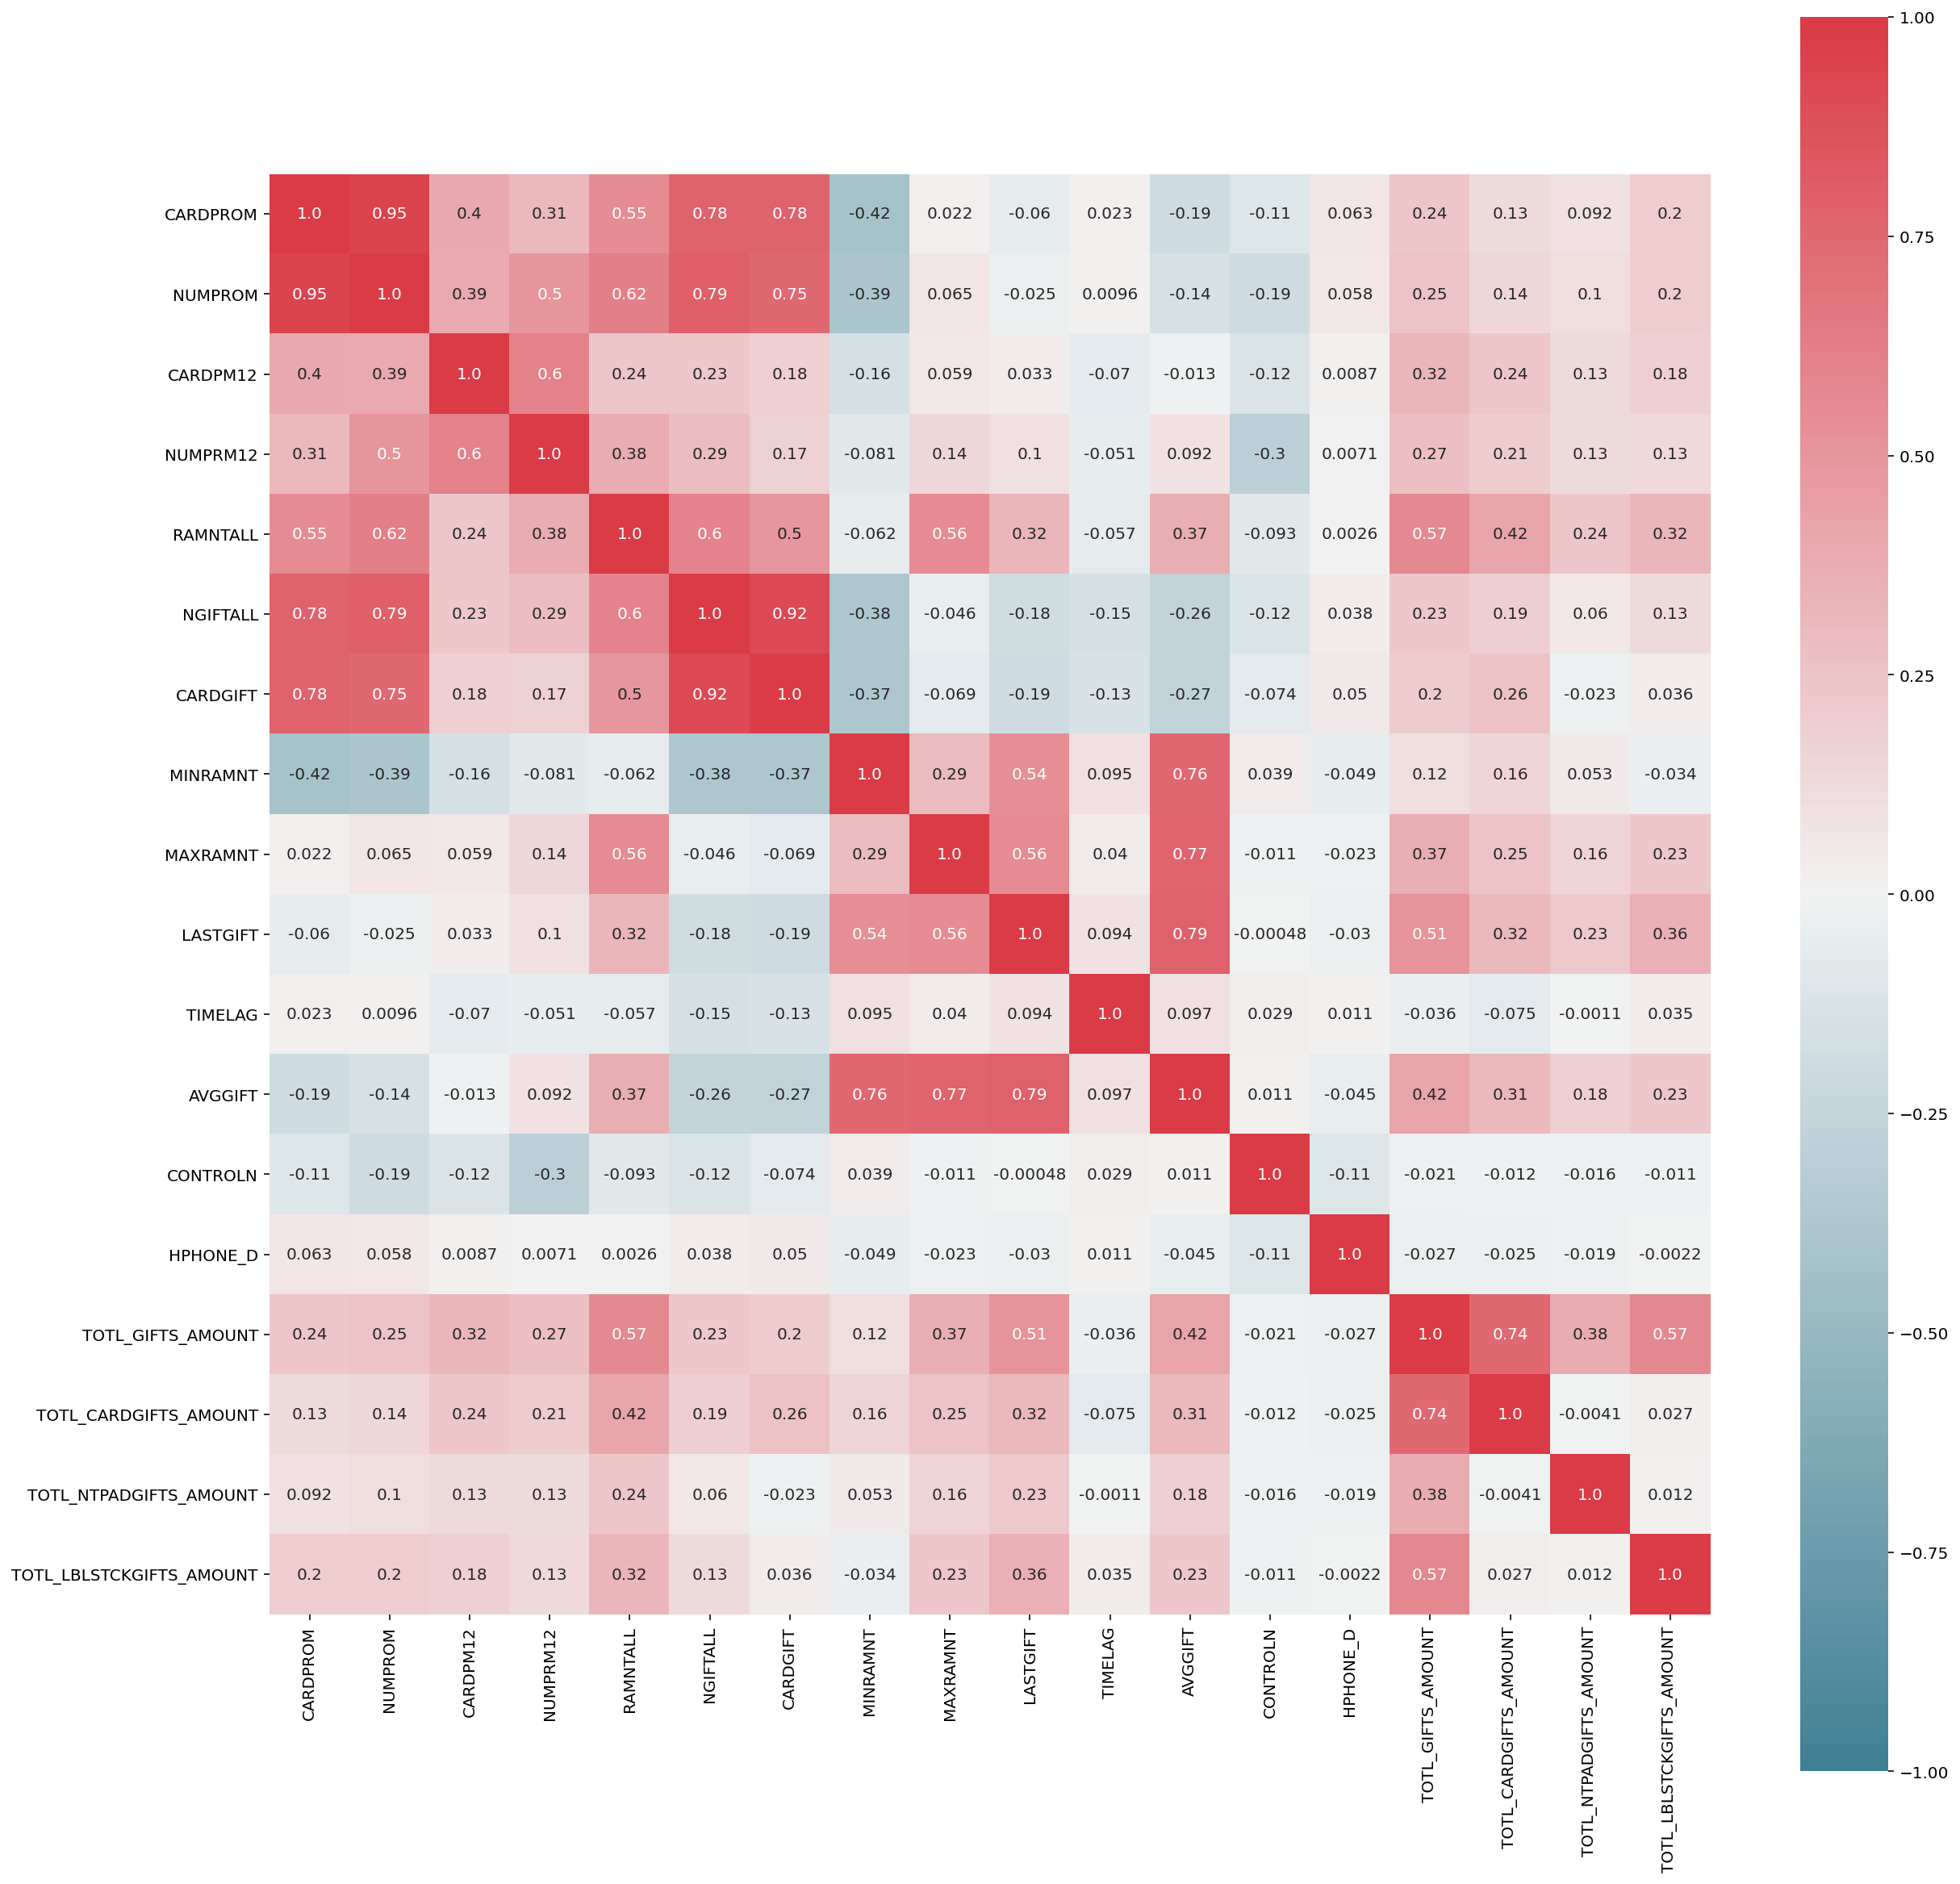

In [165]:
rfa_corr = rfa[rfa_metric_feat].corr(method = "pearson")
plt.figure(figsize=(20,20))
sns.heatmap(data = rfa_corr, annot = True, cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt='.2',  vmin=-1, vmax=1, center=0,square=True )

Very high correlations between CARDPROM, NUMPROM, NGIFTALL and CARDGIFT, wich is very interesting!!
We will keep NGIFTALL for simplicity.
Between AVGGIFT and MINRAMNT, MAXRAMNT and LASTGIFT, we will keep AVGGIFT since it is highly correlated with the other three.
Between TOTL_CARDGIFTS_AMOUNT and TOTL_GIFTS_AMOUNT, we will drop TOTL_GIFTS_AMOUNT since we already have this information.

In [166]:
rfa_after_treatment = rfa[rfa_metric_feat].drop(columns = ['CARDPROM', 'NUMPROM', 'CARDGIFT', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'TOTL_GIFTS_AMOUNT'])

Outliers

In [167]:
rfa_after_treatment.columns

Index(['CARDPM12', 'NUMPRM12', 'RAMNTALL', 'NGIFTALL', 'TIMELAG', 'AVGGIFT',
       'CONTROLN', 'HPHONE_D', 'TOTL_CARDGIFTS_AMOUNT',
       'TOTL_NTPADGIFTS_AMOUNT', 'TOTL_LBLSTCKGIFTS_AMOUNT'],
      dtype='object')

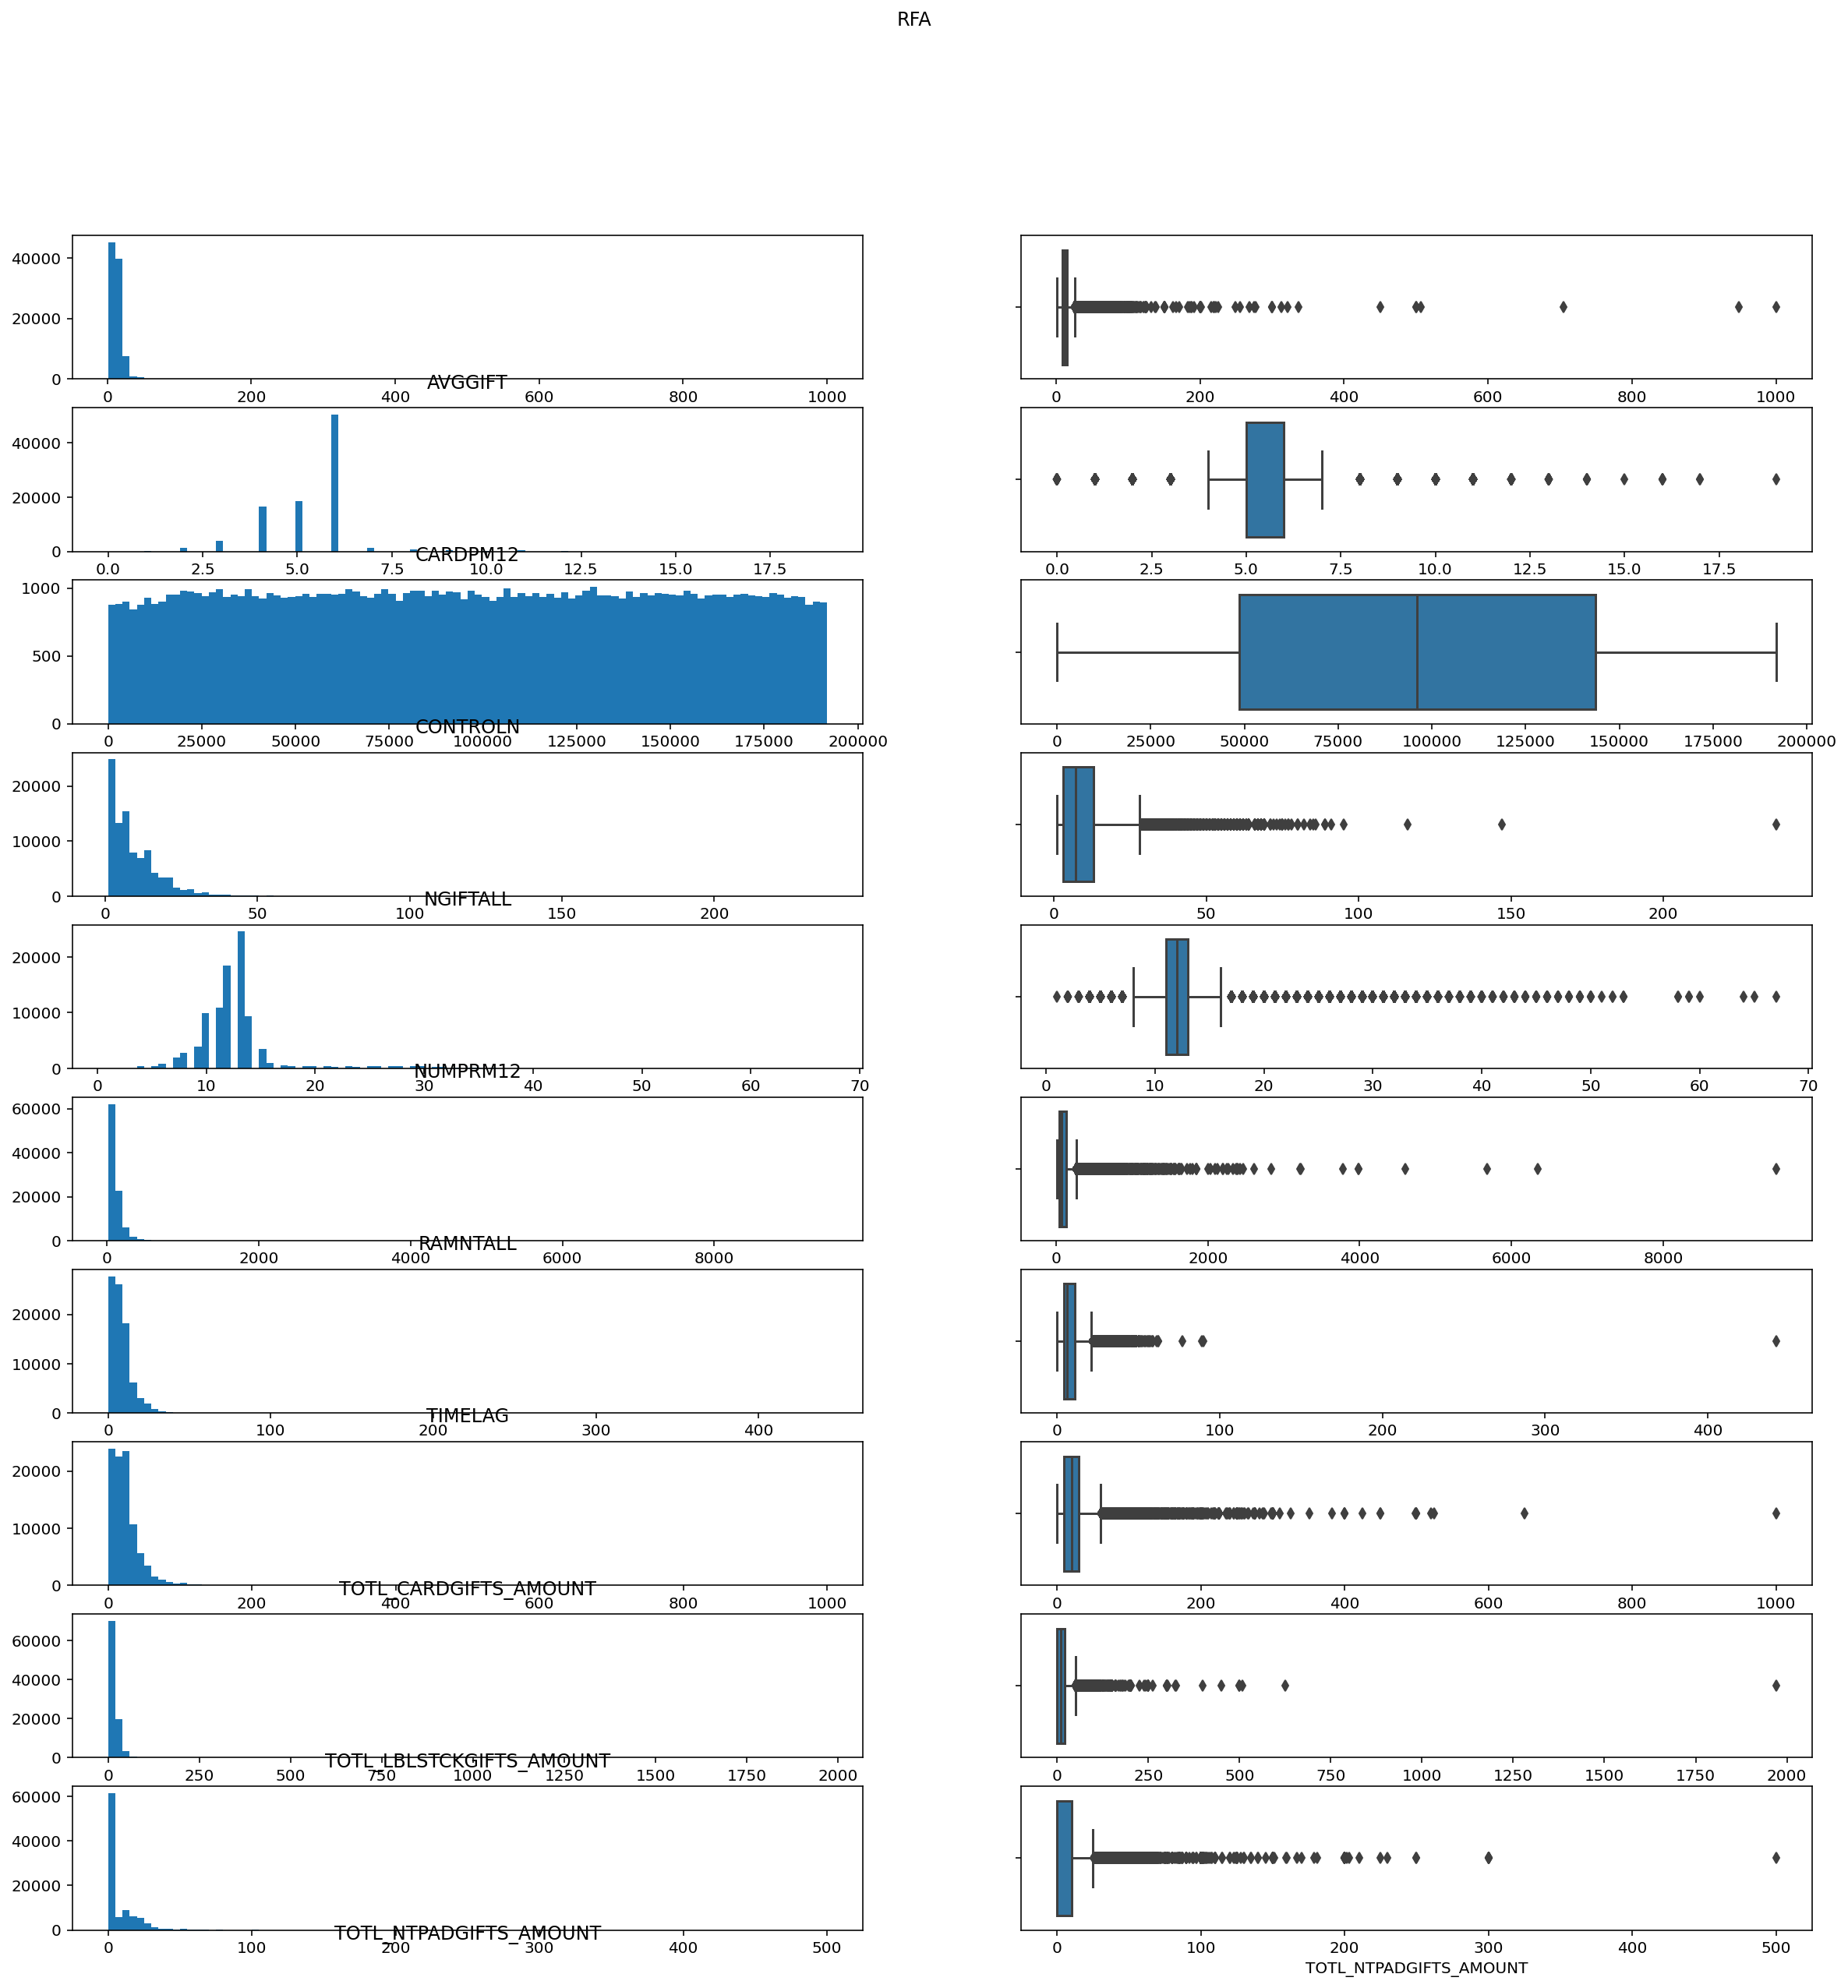

In [168]:
hist_box_maker(rfa_after_treatment.drop(columns = ['HPHONE_D']),'RFA', 10, 20, 20)

In [169]:
rfa_after_treatment[(rfa_after_treatment['AVGGIFT'] > 400) | (rfa_after_treatment['NGIFTALL'] > 100) | (rfa_after_treatment['NUMPRM12'] > 55) | (rfa_after_treatment['RAMNTALL'] > 3000) | (rfa_after_treatment['TIMELAG'] > 75) | (rfa_after_treatment['TOTL_CARDGIFTS_AMOUNT'] > 350) | (rfa_after_treatment['TOTL_LBLSTCKGIFTS_AMOUNT'] > 300) | (rfa_after_treatment['TOTL_NTPADGIFTS_AMOUNT'] > 200)]

,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,TOTL_CARDGIFTS_AMOUNT,TOTL_NTPADGIFTS_AMOUNT,TOTL_LBLSTCKGIFTS_AMOUNT
1858,6,19,622.00,9,4.0,69.111111,105188,0,525.0,0.0,0.0
2242,6,29,800.00,4,8.0,200.000000,13048,0,300.0,250.0,0.0
2857,6,36,1725.00,8,5.0,215.625000,185562,0,105.0,13.0,507.0
8483,6,12,55.00,3,90.0,18.333333,75445,1,20.0,0.0,0.0
14430,5,11,1000.00,1,NaN,1000.000000,99837,0,1000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
90193,6,34,2097.54,28,12.0,74.912143,185082,0,298.0,300.0,0.0
90715,4,28,1765.00,28,5.0,63.035714,12573,0,499.0,100.0,0.0
90955,6,34,1172.00,21,2.0,55.809524,185118,0,325.0,210.0,0.0
93114,6,41,3985.00,16,15.0,249.062500,7916,0,100.0,0.0,0.0


### Neighbourhood Data

###### **Introduction**

Since the neighborhood data has a lot of variables, the treatment had to be done in a different way.
First, we will start by checking how many columns have missing values

In [170]:
#Number of variables with missing values
(neighbourhood.isna().sum()>0).sum()

3

In [171]:
missing_zero_values_table(neighbourhood)

Your selected dataframe has 287 columns and 95412 Rows.
There are 3 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
MSA,21333,132,0.1,21465,22.5,float64
ADI,843,132,0.1,975,1.0,float64
DMA,187,132,0.1,319,0.3,float64



We can see that there are 3 columns 
These columns are  MSA code, ADI code and DMA code 
They have about 13% missing values, although this is a high value it is not enough to eliminate them fully since this percentage can be imputed, so instead lets see what these codes mean.


The MSA code is a core-based statistical area is a U.S. geographic area defined by the Office of Management and Budget that consists of one or more counties anchored by an urban center of at least 10,000 people plus adjacent counties that are socioeconomically tied to the urban center by commuting, since we already have better geographical variables we will not use this one.
The ADI code is the code of practice for approved driving instructors (ADI) is a professional code of conduct that driving instructors should abide by and also information that can be obtained for learner drivers who wish to find out what their driving instructor has agreed to, since this code also does not appear to be interesting or that it will add to our analysis anyways we are also not going to use it for now.
Finally the DMA code is  a Designated Market Area (DMA), meaning  a group of states in the United States that are covered by a specific group of television stations, this code also does not seem to be very good for our analysis, since it is very specific and cryptic
After deleting these variables we needed to divide the data frame so that we could do the outlier analysis.


In [172]:
neighbourhood.drop(columns = ["MSA", "ADI", "DMA"], inplace=True)

###### **Descriptive Statistics**

The data frame was divided by its innate subdivisions like population information, ethnicity divisions so on and so forth.

**EXPLICAR UM CADITE MELHORAR**


In [173]:
neighbourhoodpop=neighbourhood[['POP901', 'POP902', 'POP903','POP90C1', 'POP90C2', 'POP90C3', 'POP90C4', 'POP90C5']].copy() #no missing values, very high on zeros check that
neighbourhoodeth=neighbourhood[['ETH1','ETH2', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9','ETH10', 'ETH11', 'ETH12', 'ETH13', 'ETH14', 'ETH15', 'ETH16',]].copy() #no missing values, check very high correlations, hispanic and mexican btter not to make assumptions
neighbourhoodage=neighbourhood[['AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906','AGE907', 'CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3','AGEC4', 'AGEC5', 'AGEC6', 'AGEC7', 'CHILC1', 'CHILC2', 'CHILC3','CHILC4', 'CHILC5', 'HHAGE1', 'HHAGE2', 'HHAGE3']].copy() #no missing values, check high correlations, check duplicates
neighbourhoodHH=neighbourhood[['HHN1', 'HHN2','HHN3', 'HHN4', 'HHN5', 'HHN6']].copy() # high correlations
neighbourhoodMStatus=neighbourhood[['MARR1', 'MARR2', 'MARR3', 'MARR4']].copy() #no missing values
neighbourhoodHHstats=neighbourhood[['HHP1', 'HHP2']].copy() #average and median nthing to point out
neighbourhoodUnitstruct=neighbourhood[[ 'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'DW7','DW8', 'DW9']].copy() #check high correlations
neighbourhoodHV=neighbourhood[[ 'HV1', 'HV2', 'HV3', 'HV4']].copy() #no missing values check high correlation
neighbourhoodHU=neighbourhood[[  'HU1', 'HU2', 'HU3','HU4', 'HU5']].copy()#1 high correlation
neighbourhoodHHDesc=neighbourhood[['HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5', 'HHD6','HHD7', 'HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12']].copy() # a lot of high correlations
neighbourhoodETbin=neighbourhood[['ETHC1','ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'ETHC6',]].copy() #1 high correlation
neighbourhoodHvalue=neighbourhood[['HVP1', 'HVP2','HVP3', 'HVP4', 'HVP5', 'HVP6']].copy() #2 high correlations
neighbourhoodRSats=neighbourhood[['RHP1', 'RHP2', 'RHP3', 'RHP4']].copy() # high correlations but its expected
neighbourhoodHUPA=neighbourhood[['HUPA1', 'HUPA2', 'HUPA3', 'HUPA4', 'HUPA5','HUPA6', 'HUPA7']].copy() #nothing to report, no missing values
neighbourhoodRP=neighbourhood[['RP1', 'RP2', 'RP3', 'RP4']].copy()#1 high correlation
neighbourhoodIC=neighbourhood[['IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC7', 'IC8', 'IC9','IC10', 'IC11', 'IC12', 'IC13', 'IC14', 'IC15', 'IC16', 'IC17', 'IC18', 'IC19', 'IC20', 'IC21', 'IC22', 'IC23']].copy() #high correlations
neighbourhoodHHAS=neighbourhood[['HHAS1', 'HHAS2','HHAS3', 'HHAS4']].copy() #nothing to point out
neighbourhoodMC=neighbourhood[[ 'MC1', 'MC2', 'MC3']].copy()#nothing to point out
neighbourhoodTPE=neighbourhood[[ 'TPE1', 'TPE2', 'TPE3','TPE4', 'TPE5', 'TPE6', 'TPE7', 'TPE8', 'TPE9']].copy()#high correlations
neighbourhoodTPEstats=neighbourhood[['TPE10', 'TPE11', 'TPE12', 'TPE13']].copy()#usual stuff its just stats
neighbourhoodLFC=neighbourhood[['LFC1', 'LFC2', 'LFC3', 'LFC4','LFC5', 'LFC6', 'LFC7', 'LFC8', 'LFC9', 'LFC10']].copy()#high correlations
neighbourhoodOCC=neighbourhood[['OCC1', 'OCC2','OCC3', 'OCC4', 'OCC5', 'OCC6', 'OCC7', 'OCC8', 'OCC9', 'OCC10','OCC11', 'OCC12', 'OCC13']].copy() #nothing to report
neighbourhoodEIC=neighbourhood[['EIC1', 'EIC2', 'EIC3', 'EIC4', 'EIC5','EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC10', 'EIC11', 'EIC12', 'EIC13','EIC14', 'EIC15', 'EIC16']].copy()#nothing to report
neighbourhoodOEDC=neighbourhood[[ 'OEDC1', 'OEDC2', 'OEDC3', 'OEDC4','OEDC5', 'OEDC6', 'OEDC7',]].copy() #nothing to report
neighbourhoodEC=neighbourhood[[ 'EC1', 'EC2', 'EC3', 'EC4', 'EC5','EC6', 'EC7', 'EC8']].copy()#nothing to report
neighbourhoodSEC=neighbourhood[['SEC1', 'SEC2', 'SEC3', 'SEC4', 'SEC5']].copy()#nothing to report
neighbourhoodHC=neighbourhood[['HC1', 'HC2', 'HC3', 'HC4', 'HC5', 'HC6', 'HC7', 'HC8', 'HC9', 'HC10', 'HC11', 'HC12', 'HC13', 'HC14','HC15', 'HC16', 'HC17', 'HC18', 'HC19', 'HC20', 'HC21']].copy() #2 correlations 
neighbourhoodLSC=neighbourhood[['LSC1', 'LSC2', 'LSC3', 'LSC4',]].copy()#nothing to report
neighbourhoodVOC=neighbourhood[['VOC1', 'VOC2', 'VOC3']].copy()#nothing to report
neighbourhoodPOBC=neighbourhood[['POBC1', 'POBC2']].copy()#nothing to report
neighbourhoodVC=neighbourhood[['VC1', 'VC2','VC3','VC4']].copy()#nothing to report
neighbourhoodMHUC=neighbourhood[['MHUC1','MHUC2']].copy()#nothing to report
neighbourhoodAC=neighbourhood[['AC1', 'AC2']].copy()#nothing to report
neighbourhoodHUR=neighbourhood[[ 'HUR1', 'HUR2']].copy()#nothing to report
neighbourhoodPEC=neighbourhood[['PEC1', 'PEC2']].copy()#nothing to report
neighbourhoodACS=neighbourhood[['ANC1', 'ANC2', 'ANC3', 'ANC4', 'ANC5', 'ANC6','ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13','ANC14', 'ANC15']].copy() #nothing to report


After this subdivision we proceeded to the outlier analysis , this was made using the hist_box_maker function which returns the box plots and histograms of the  provided columns , and by analyzing these we can get a clear view of the distribution of the data and which cutoffs should be made in order to minimize outlier impact in our posterior analysis.

###### **Outliers**

Filter of the records that are outliers in at least one variable

In [174]:
filters_neighbourhood_1 = (
(neighbourhood['HHN1'] > 90) |
(neighbourhood['HHN2'] > 90) | 
(neighbourhood['HHN3'] > 95) |
(neighbourhood['HHN4'] > 90) |
(neighbourhood['HHN5'] > 65) |
(neighbourhood['HHN6'] > 95) |
(neighbourhood['DW3'] > 65) |
(neighbourhood['DW8'] > 75) |
(neighbourhood['DW9'] > 80) |
(neighbourhood['HU3'] < 10) |
(neighbourhood['HU4'] > 90) |
(neighbourhood['HHD1'] > 95) |
(neighbourhood['HHD10'] > 90) |
(neighbourhood['HHD11'] > 90) |
(neighbourhood['HHD12'] > 80) |
(neighbourhood['HHD4'] > 90) |
(neighbourhood['HHD7'] > 70) |
(neighbourhood['HHD8'] > 20) |
(neighbourhood['HHD9'] > 70) |
(neighbourhood['RHP1'] < 5) |
(neighbourhood['RHP3'] < 10) |
(neighbourhood['RHP3'] > 40) |
(neighbourhood['RHP4']  > 25) |
(neighbourhood['HUPA1'] > 95) |
(neighbourhood['HUPA5'] > 75) |
(neighbourhood['HUPA7'] > 55) |
(neighbourhood['HHAS2'] > 65) |
(neighbourhood['HHAS3'] > 95) |
(neighbourhood['HHAS4'] > 90) |
(neighbourhood['TPE2'] > 59) |
(neighbourhood['TPE3'] > 70) |
(neighbourhood['TPE4'] > 70) |
(neighbourhood['TPE5'] > 47) |
(neighbourhood['TPE6'] > 20) |
(neighbourhood['TPE7'] > 15) |
(neighbourhood['TPE8'] > 82) |
(neighbourhood['TPE9'] > 70) |
(neighbourhood['TPE10'] > 70) |
(neighbourhood['TPE11'] > 67) |
(neighbourhood['TPE12'] > 60) |
(neighbourhood['EC1'] < 75) |
(neighbourhood['SEC1'] > 75) |
(neighbourhood['SEC2'] > 80) |
(neighbourhood['SEC3'] > 15) |
(neighbourhood['SEC4'] > 55) |
(neighbourhood['SEC5'] > 78) |
(neighbourhood['HC10'] > 58) |
(neighbourhood['HC12'] > 96) |
(neighbourhood['HC15'] > 15) |
(neighbourhood['HC16'] > 96) |
(neighbourhood['HC20'] < 30) |
(neighbourhood['HC21'] < 27) |
(neighbourhood['HC3'] > 90) |
(neighbourhood['HC9'] > 85) |
(neighbourhood['VOC1'] < 5) |
(neighbourhood['VOC3'] > 75) |
(neighbourhood['HUR1'] > 84) 
)

Our filtration of the outliers of the values will follow the rule of thumb of the 3% (we hope)

In [175]:
neighbourhood[(~(filters_neighbourhood_1))].shape[0] / neighbourhood.shape[0]

0.9865530541231711

In [176]:
neighbourhood = neighbourhood[~filters_neighbourhood_1]

In [177]:
# neighbourhood=neighbourhood.drop(columns=['AGE903','AGE902','AGE901','AGE906','CHIL1','CHIL2','CHIL3','AGEC1','AGEC2','AGEC1', 'AGEC2', 
#'AGEC3','AGEC4', 'AGEC5', 'AGEC6', 'AGEC7', 'CHILC1', 'CHILC2', 'CHILC3','CHILC4', 'CHILC5','HHAGE2','HHAGE3','HHN4','HHN5','HHN6','HHP1',
#'HV1','HV3','HHD1','HHD2','HHD3','HHD4','HHD5','HHD6','HHD7','HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12','HVP1','HVP2','HVP3','HVP4','HVP5','RHP1',
#'RHP3','HUPA1', 'HUPA2', 'HUPA3', 'HUPA4', 'HUPA5','HUPA6', 'HUPA7','RP4','RP2','RP3','IC2','IC1','IC15', 'IC16', 'IC17','IC18', 'IC19', 'IC20', 
#'IC21', 'IC22', 'IC23','MC1','MC2','MC3','TPE1', 'TPE2', 'TPE3','TPE4', 'TPE5', 'TPE6', 'TPE7', 'TPE8', 'TPE9','PEC1','PEC2','TPE10','TPE13','TPE12','LFC4','LFC5','LFC6','OCC1',
#  'OCC2',
#  'OCC3',
#  'OCC4',
#  'OCC5',
#                                           'OCC6',
#                                           'OCC7',
#  'OCC8',
#                                           'OCC9',
#  'OCC10',
#  'OCC11',
#  'OCC12',
#  'OCC13',
#                                           'ETH7',"ETH13"
#  'ETHC3',
#  'ETH8',
#  'ETH9',
#  'ETH10',
#  'ETH11',
#  'ETH12',
#  'ETH14',
#  'ETH15',
#  'ETH16','EC1','POP90C5', 'OEDC1', 'OEDC2', 'OEDC3', 'OEDC4','OEDC5', 'OEDC6', 'OEDC7','SEC2','SEC3','ANC1', 'ANC2', 'ANC3', 'ANC4', 'ANC5', 'ANC6','ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13','ANC14', 'ANC15','VOC1','VOC2','MHUC1','MHUC2','AC1','AC2'])

###### **Feature Engineering**

In [178]:
neighbourhood.shape

(94129, 284)

In [179]:
neighbourhood['ICCHEAP'] = neighbourhood[['IC6','IC7','IC8','IC9']].sum(axis = 1)
neighbourhood['ICMEDIUM'] = neighbourhood[['IC10','IC11']].sum(axis = 1)
neighbourhood['ICEXPENSIVE'] = neighbourhood[['IC12','IC13']].sum(axis = 1)

In [180]:
neighbourhood.drop(columns = ['IC6','IC7','IC8','IC9','IC10','IC11','IC12','IC13'], inplace = True)

In [181]:
neighbourhood.drop(columns = ['MARR2','MARR3','MARR4'], inplace = True)

In [182]:
neighbourhood['1stSECTOR'] = neighbourhood[['EIC1', 'EIC2', 'EIC3']].sum(axis = 1)
neighbourhood['2ndSECTOR'] = neighbourhood[['EIC4']].sum(axis = 1)
neighbourhood['3rdSECTOR'] = neighbourhood[['EIC5','EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC11', 'EIC12', 'EIC13', 'EIC15', 'EIC16','EIC10','EIC14']].sum(axis = 1)

In [183]:
neighbourhood['Less_Educated'] = neighbourhood[['EC2', 'EC3']].sum(axis = 1)
neighbourhood['High_School'] = neighbourhood[['EC4', 'EC5']].sum(axis = 1)
neighbourhood['University'] = neighbourhood[['EC6','EC7','EC8']].sum(axis = 1)

In [184]:
neighbourhood.drop(columns = ['EIC1', 'EIC2', 'EIC3', 'EIC4', 'EIC5','EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC10', 'EIC11', 'EIC12', 'EIC13','EIC14', 'EIC15', 'EIC16'], inplace = True)

In [185]:
neighbourhood.drop(columns = ['EC2', 'EC3', 'EC4', 'EC5','EC6', 'EC7', 'EC8'], inplace = True)

In [186]:
for column in ['ICCHEAP','ICMEDIUM', 'ICEXPENSIVE', '1stSECTOR','2ndSECTOR','3rdSECTOR']:
  print(column)
  print((neighbourhood[column] > 100).sum())

ICCHEAP
165
ICMEDIUM
0
ICEXPENSIVE
0
1stSECTOR
0
2ndSECTOR
0
3rdSECTOR
63


In [187]:
neighbourhood['Other_ETH']=neighbourhood[['ETH3','ETH4','ETH6']].sum(axis=1)

In [188]:
neighbourhood.drop(columns = ['ETH3','ETH4','ETH6'], inplace = True)

In [189]:
neighbourhood.reset_index(inplace=True,drop=True)

###### **PCA Etnhicity** 

**Bartlett’s Test**

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, we should not employ a factor analysis.

**Interpretability:** Small values *(less than 0.05)* of the significance level indicate that a factor analysis may be useful with your data


In [190]:
neighbourhood_eth = neighbourhood.copy()

In [191]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(neighbourhood_eth)
scaled_feat

array([[-0.39851444, -0.41732486, -0.42415535, ...,  0.97392032,
        -0.81104691, -0.4936435 ],
       [ 0.05532717,  0.04420598, -0.11193866, ..., -1.65263977,
         1.7650284 ,  3.93292247],
       [ 0.64277393,  0.79521771,  0.67141581, ..., -0.58255973,
        -0.87238204, -0.4936435 ],
       ...,
       [-0.47476122, -0.508129  , -0.48369216, ...,  2.33584037,
        -0.62704153, -0.36717018],
       [-0.26785519, -0.30262488, -0.34164764, ...,  0.4875203 ,
         0.23165024,  0.26519638],
       [ 0.11147252,  0.21625594,  0.04932641, ..., -0.48527973,
         1.33568252, -0.36717018]])

In [192]:

neighbourhood_eth = pd.DataFrame(scaled_feat)
neighbourhood_eth.columns = neighbourhood.columns
neighbourhood_eth

,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH5,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,...,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,CONTROLN,ICCHEAP,ICMEDIUM,ICEXPENSIVE,1stSECTOR,2ndSECTOR,3rdSECTOR,Less_Educated,High_School,University,Other_ETH
0,-0.398514,-0.417325,-0.424155,-1.248073,0.677184,0.961345,-0.505065,0.504836,0.326126,-0.389271,0.253605,-0.178914,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,0.514259,-0.236072,-0.102497,-0.453063,0.552570,0.788638,0.792845,0.588410,0.881556,1.082027,0.033170,-1.239120,0.639347,1.099206,-0.222012,-1.123765,-0.485686,0.688552,0.260710,0.062006,1.094168,-0.904786,-1.618324,...,0.450058,0.090174,-0.372200,-0.486003,-0.289291,0.304570,-0.360044,-0.389300,1.061382,-0.575141,-0.718174,-0.476344,-0.167552,-0.513084,-1.832769,1.853298,-0.929042,0.275068,0.666475,-0.638479,-0.426374,1.481241,0.304225,-0.190379,-0.218517,-0.140854,0.453316,0.742416,-0.789459,-0.001373,0.461439,-0.416111,-0.666863,-0.580652,2.374466,-1.643436,0.303420,0.97392,-0.811047,-0.493643
1,0.055327,0.044206,-0.111939,0.843770,-0.439140,-0.657564,0.445348,-0.445552,-0.956216,-0.449157,-0.108970,0.717767,2.134531,1.485303,13.642978,-0.200177,-0.0583,-0.279361,-0.236072,0.207267,0.738417,-0.098791,-0.174966,-0.357974,-0.655226,-0.552821,-0.625826,1.018744,-0.962174,1.422909,-0.035877,0.131723,-1.123765,2.074830,2.162053,-0.497708,-1.124087,-0.861844,-1.114075,-0.090241,...,-0.100675,0.801016,1.389616,1.588327,1.151003,-1.171981,-0.360044,-0.389300,1.230669,-0.575141,-0.933042,-0.476344,-0.167552,-0.513084,0.568871,-0.571650,0.753738,0.275068,0.666475,3.426939,1.967264,0.041236,-0.328177,-0.190379,-0.218517,-0.140854,-1.537576,-1.658287,-0.789459,0.958382,-3.031018,0.523540,4.162885,-0.448016,-0.413938,0.635445,-0.852294,-1.65264,1.765028,3.932922
2,0.642774,0.795218,0.671416,-1.248073,-0.375350,1.783253,0.128544,-0.128756,0.531300,-0.329384,-0.399030,-0.178914,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,-0.279361,-0.236072,-0.102497,-0.453063,0.031481,0.100349,0.073584,0.122046,-0.014930,0.133220,-0.248422,-0.685227,0.247566,0.720845,0.131723,-0.318800,-0.314985,0.442968,0.260710,-0.107436,0.040930,-0.276917,-0.701474,...,0.082902,-0.028300,0.005332,0.111153,0.190807,-0.176914,-0.360044,-0.389300,-1.477915,-0.078737,0.177111,4.083996,-0.167552,0.927086,-2.233042,2.300980,-1.585040,-0.789149,-0.594265,0.232682,-0.426374,0.041236,-0.328177,-0.190379,-0.218517,-0.140854,-1.139398,-1.058112,-0.789459,-1.457422,0.617818,-0.560673,-0.666863,0.878338,1.577779,-1.896645,1.459135,-0.58256,-0.872382,-0.493643
3,-0.459512,-0.488330,-0.477129,-1.248073,-0.183980,1.633815,1.712566,-1.712736,-1.263979,-0.449157,1.776421,0.717767,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,2.277860,-0.236072,-0.102497,-0.155193,-0.359335,-0.312623,-0.214121,-0.344317,-0.373524,-0.246303,0.033170,0.699506,-0.731887,-0.225057,0.485458,0.352005,-0.656387,0.688552,0.007904,-0.615761,-0.109532,0.769530,0.215375,...,-0.467831,-0.146773,-0.162460,-0.234569,-0.577349,0.593461,-0.360044,-0.389300,-0.208266,1.245008,-0.467494,-0.476344,-0.167552,1.023098,-2.196654,2.300980,-1.442432,-2.917584,-1.134583,2.265391,-0.426374,0.041236,-0.011976,-0.190379,-0.218517,-0.140854,-0.542130,-0.858053,-0.789459,1.393204,-0.216202,0.378978,-0.666863,4.990038,-1.409797,-2.149854,1.314670,-0.87440,-0.627042,1.656403
4,-0.133730,-0.169491,-0.223043,0.843770,-0.439140,-0.657564,-0.821869,0.821632,-4.290306,5.419734,-0.471545,-0.178914,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,-0.455721,-0.236072,-0.102497,-0.453063,-0.229063,0.375665,0.648993,-0.033408,0.164367,0.322981,0.314763,-0.823700,0.835238,0.342484,0.308590,-0.184639,-1.339192,0.197385,2.030353,0.231448,-0.410457,-0.695496,-0.395858,...,-0.46

In [193]:
chi_square_value,p_value = calculate_bartlett_sphericity(neighbourhood_eth[[ 'ETH1',
 'ETH2',
#  'ETH3',
#  'ETH4',
 'ETH5',
#  'ETH6',
 'ETHC1',
 'ETHC2',
#  'ETHC3',
 'ETHC4',
 'ETHC5',
 'ETHC6',
 'LSC1',
 'LSC2',
#  'LSC3',
#  'LSC4',
'POBC1',	'POBC2'
]])
chi_square_value,p_value

(1895023.9246022576, 0.0)

**Kaiser-Meyer-Olkin (KMO) Test**

It's a statistic that indicates the proportion of variance in our variables that might be caused by underlying factors. High values (close to 1.0) generally indicate that a factor analysis may be useful with our data. 

**Interpretability:** If the value is *less than 0.60*, the results of the factor analysis probably won’t be very useful.


In [194]:
kmo_all,kmo_model = calculate_kmo(neighbourhood_eth[[ 'ETH1',
 'ETH2',
#  'ETH3',
#  'ETH4',
 'ETH5',
#  'ETH6',
 'ETHC1',
 'ETHC2',
#  'ETHC3',
 'ETHC4',
 'ETHC5',
 'ETHC6',
 'LSC1',
 'LSC2',
#  'LSC3',
#  'LSC4',
'POBC1',	'POBC2'
]])
kmo_model

0.6847652704099357

In [195]:
pca = PCA()
pca_feat = pca.fit_transform(neighbourhood_eth[[ 'ETH1',
 'ETH2',
#  'ETH3',
#  'ETH4',
 'ETH5',
#  'ETH6',
 'ETHC1',
 'ETHC2',
#  'ETHC3',
 'ETHC4',
 'ETHC5',
 'ETHC6',
 'LSC1',
 'LSC2',
#  'LSC3',
#  'LSC4',
'POBC1',	'POBC2'
]])
pca_feat  

array([[-0.69304832,  0.13247507,  0.64146836, ...,  0.02162587,
         0.06245361, -0.04411115],
       [ 0.67235409,  3.38864766, -1.02234566, ...,  0.14241602,
         0.02964238,  0.00602934],
       [-1.18528062, -0.82957809,  0.70917575, ...,  0.0398869 ,
        -0.10499378, -0.04417099],
       ...,
       [ 0.63663146, -0.7052358 ,  1.19336778, ..., -0.52954678,
         0.08899469,  0.04860119],
       [-0.78155149,  0.91310936, -0.24033831, ...,  0.00338959,
        -0.04375315, -0.04384901],
       [-0.15268674, -1.09043222, -0.26934794, ...,  0.07071202,
        -0.08294294,  0.0050634 ]])

In [196]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)).head(20)

,Eigenvalue,Difference,Proportion,Cumulative
1,5.421417,0.000000,0.451780,0.451780
2,3.723390,-1.698028,0.310279,0.762059
3,1.141533,-2.581857,0.095127,0.857186
4,0.501304,-0.640229,0.041775,0.898961
5,0.361137,-0.140167,0.030094,0.929055
6,0.320938,-0.040199,0.026745,0.955800
7,0.286518,-0.034420,0.023876,0.979676
8,0.107593,-0.178924,0.008966,0.988642
9,0.055346,-0.052247,0.004612,0.993254
10,0.053381,-0.001965,0.004448,0.997703


In [197]:
%matplotlib inline

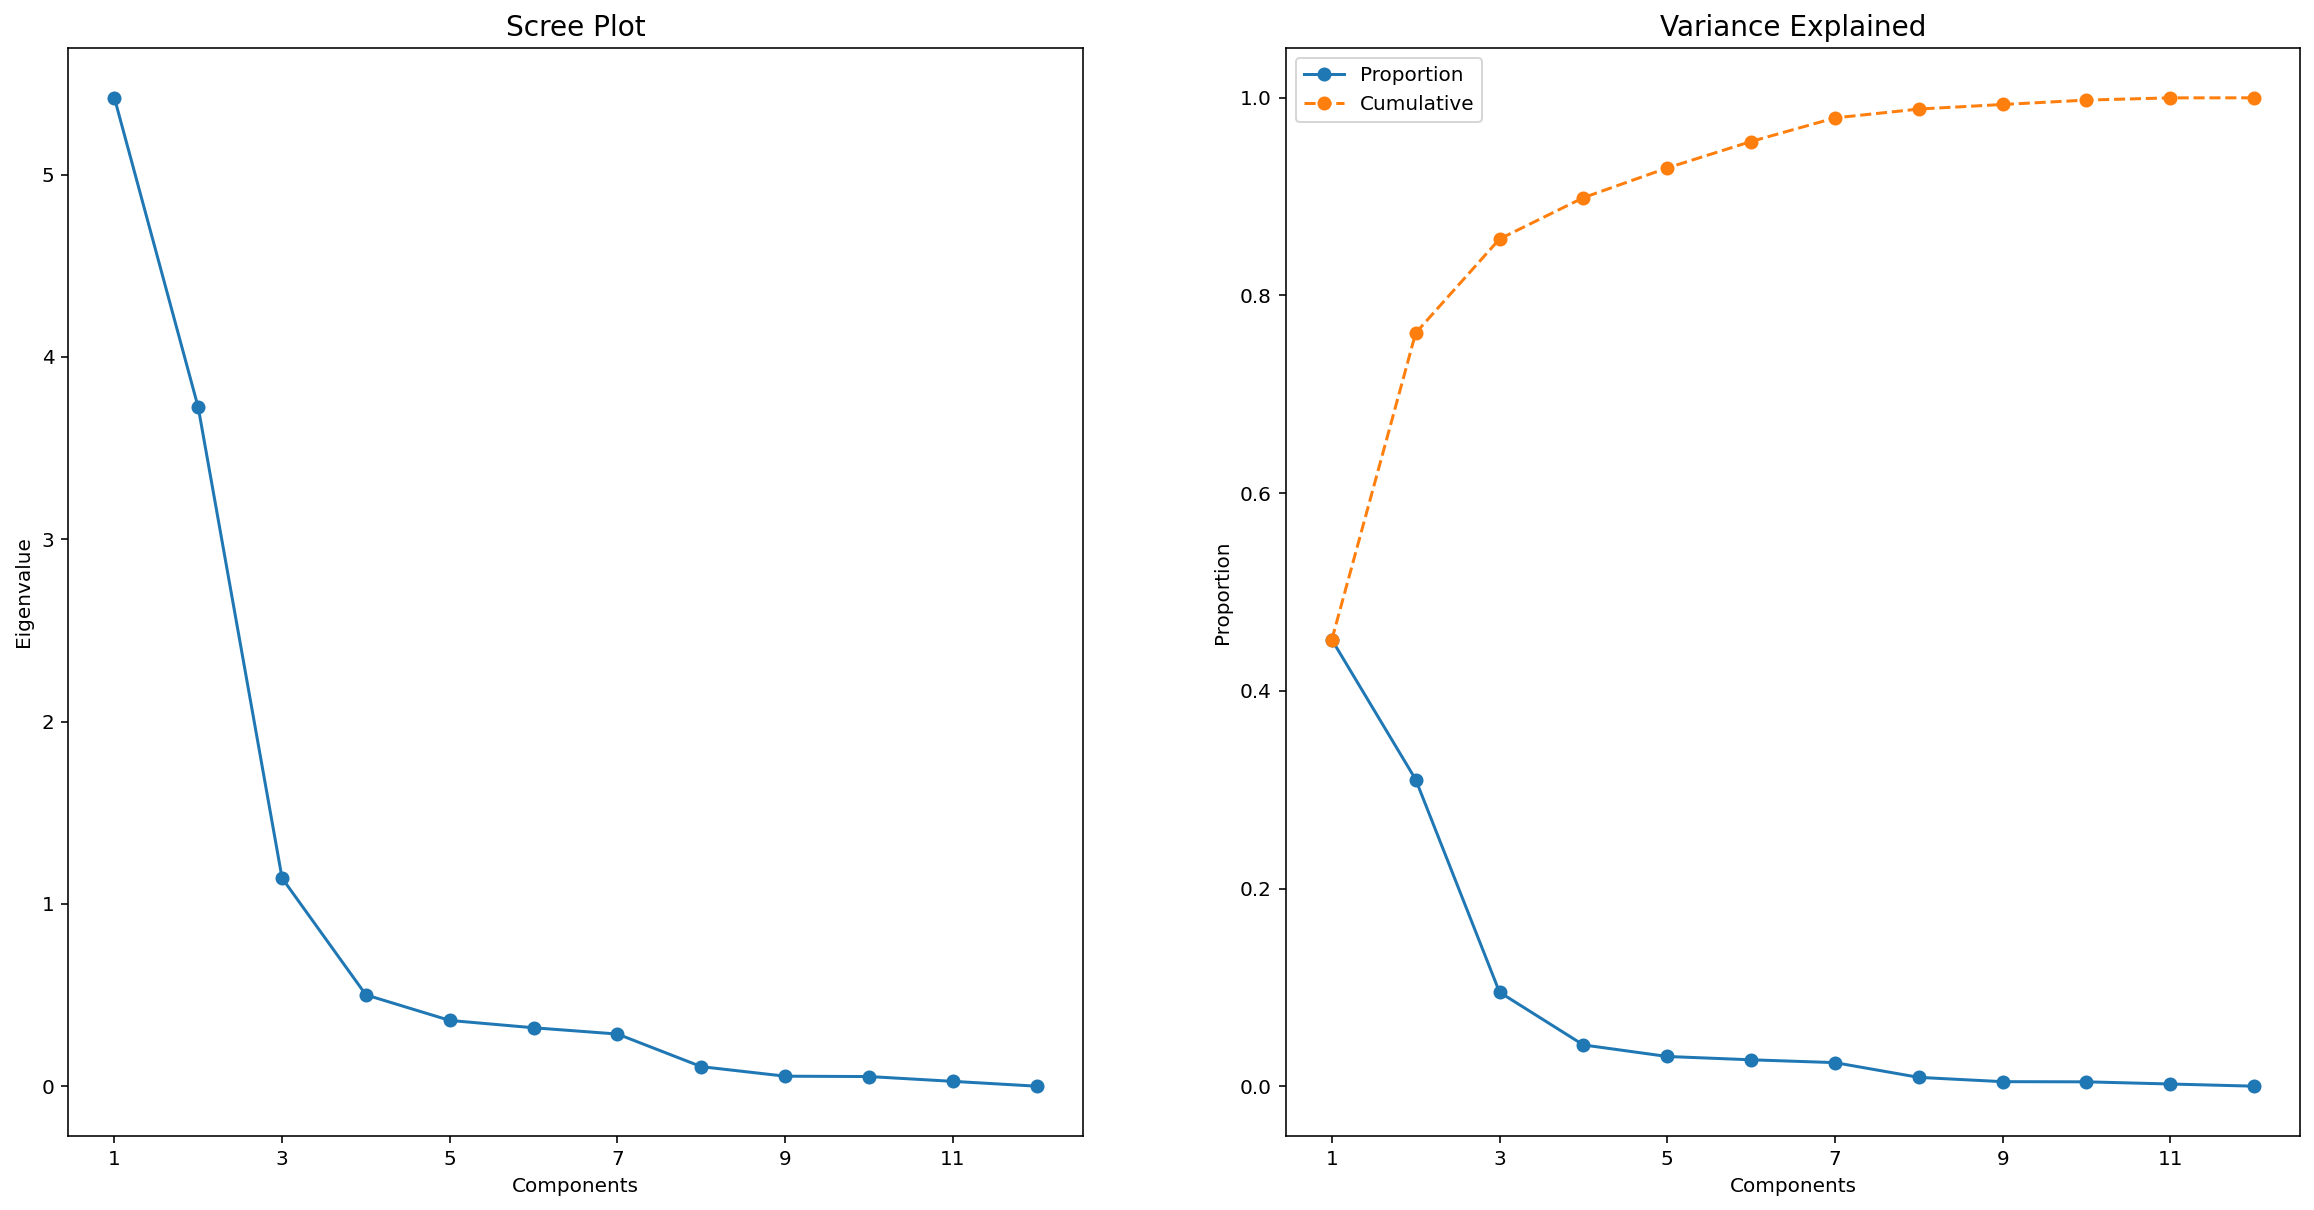

In [198]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")


ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [199]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=3)
pca_feat = pca.fit_transform(neighbourhood_eth[[ 'ETH1',
 'ETH2',
#  'ETH3',
#  'ETH4',
 'ETH5',
#  'ETH6',
 'ETHC1',
 'ETHC2',
#  'ETHC3',
 'ETHC4',
 'ETHC5',
 'ETHC6',
 'LSC1',
 'LSC2',
#  'LSC3',
#  'LSC4',
'POBC1',	'POBC2'
]])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=neighbourhood.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2
0,-0.693048,0.132475,0.641468
1,0.672354,3.388648,-1.022346
2,-1.185281,-0.829578,0.709176
3,1.548527,4.511502,1.099522
4,11.415458,-4.347455,0.123778
...,...,...,...
94124,-0.027590,-0.145804,-1.001243
94125,-1.218453,-0.455662,0.476396
94126,0.636631,-0.705236,1.193368
94127,-0.781551,0.913109,-0.240338


In [200]:
df_pca = pd.concat([neighbourhood, pca_df], axis=1)

In [201]:
pca_df

,PC0,PC1,PC2
0,-0.693048,0.132475,0.641468
1,0.672354,3.388648,-1.022346
2,-1.185281,-0.829578,0.709176
3,1.548527,4.511502,1.099522
4,11.415458,-4.347455,0.123778
...,...,...,...
94124,-0.027590,-0.145804,-1.001243
94125,-1.218453,-0.455662,0.476396
94126,0.636631,-0.705236,1.193368
94127,-0.781551,0.913109,-0.240338


In [202]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[list((neighbourhood_eth[[ 'ETH1',
 'ETH2',
#  'ETH3',
#  'ETH4',
 'ETH5',
#  'ETH6',
 'ETHC1',
 'ETHC2',
#  'ETHC3',
 'ETHC4',
 'ETHC5',
 'ETHC6',
 'LSC1',
 'LSC2',
#  'LSC3',
#  'LSC4',
'POBC1',	'POBC2'
]]).columns) + pca_feat_names].corr().loc[list((neighbourhood_eth[[ 'ETH1',
 'ETH2',
#  'ETH3',
#  'ETH4',
 'ETH5',
#  'ETH6',
 'ETHC1',
 'ETHC2',
#  'ETHC3',
 'ETHC4',
 'ETHC5',
 'ETHC6',
 'LSC1',
 'LSC2',
#  'LSC3',
#  'LSC4',
'POBC1',	'POBC2'
]]).columns), pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2
ETH1,-0.946375,-0.089159,-0.065540
ETH2,0.919169,-0.344613,0.062241
ETH5,0.257210,0.875476,0.298937
ETHC1,-0.678436,-0.096024,0.506798
ETHC2,-0.846265,-0.073351,0.087497
ETHC4,0.875715,-0.332571,0.087318
ETHC5,0.908204,-0.329512,0.045867
ETHC6,0.786251,-0.334320,0.067610
LSC1,-0.293164,-0.921048,-0.102969
LSC2,0.270679,0.868708,0.307625


In [203]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(pca_df)
scaled_feat

array([[-0.29765241,  0.06865422,  0.60038983],
       [ 0.28876459,  1.7561414 , -0.9568764 ],
       [-0.50905777, -0.42992266,  0.66376135],
       ...,
       [ 0.27342233, -0.3654832 ,  1.11694657],
       [-0.33566301,  0.47321212, -0.22494746],
       [-0.06557634, -0.56510837, -0.25209936]])

In [204]:
pca_df = scaled_feat
pca_df = pd.DataFrame(pca_df)
pca_names=['Black Communities','Hispanic Communities', 'Native white kids']
pca_df.columns = pca_names
pca_df

,Black Communities,Hispanic Communities,Native white kids
0,-0.297652,0.068654,0.600390
1,0.288765,1.756141,-0.956876
2,-0.509058,-0.429923,0.663761
3,0.665066,2.338052,1.029111
4,4.902744,-2.253036,0.115851
...,...,...,...
94124,-0.011849,-0.075562,-0.937125
94125,-0.523305,-0.236143,0.445888
94126,0.273422,-0.365483,1.116947
94127,-0.335663,0.473212,-0.224947


In [205]:
neighbourhood.drop(columns=['ETH1',
 'ETH2',
#  'ETH3',
#  'ETH4',
 'ETH5',
#  'ETH6',
 'ETHC1',
 'ETHC2',
#  'ETHC3',
 'ETHC4',
 'ETHC5',
 'ETHC6',
 'LSC1',
 'LSC2',
#  'LSC3',
#  'LSC4',
'POBC1',	'POBC2'], inplace=True)

In [206]:
neighbourhood = pd.concat([neighbourhood, pca_df], axis=1)

In [207]:
neighbourhood.head()

,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,...,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,CONTROLN,ICCHEAP,ICMEDIUM,ICEXPENSIVE,1stSECTOR,2ndSECTOR,3rdSECTOR,Less_Educated,High_School,University,Other_ETH,Black Communities,Hispanic Communities,Native white kids
0,992,264,332,0,35,65,47,53,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,...,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,0,0,0,18,39,0,95515,82,16,0,6,41,53,26,60,15,0,-0.297652,0.068654,0.600390
1,3611,940,998,99,0,0,50,50,2,6,4,14,0,0,2,0,1,4,34,41,43,32,42,45,32,33,46,21,13,14,33,23,10,4,2,11,16,36,22,15,...,97,99,0,0,0,96,0,4,0,0,0,99,0,99,99,99,20,4,6,5,0,0,0,8,15,0,148535,15,29,23,7,13,80,10,33,57,35,0.288765,1.756141,-0.956876
2,7001,2040,2669,0,2,98,49,51,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15,14,30,22,19,...,50,69,31,0,0,0,6,35,44,0,15,22,77,17,97,92,9,2,6,5,0,0,0,10,21,0,15078,85,14,0,17,33,50,42,44,14,0,-0.509058,-0.429923,0.663761
3,640,160,219,0,8,92,54,46,2,0,0,0,0,0,31,0,0,1,32,40,44,34,43,47,25,45,35,20,15,25,17,17,12,7,7,20,17,30,14,19,...,39,45,55,0,0,45,22,17,0,0,16,23,77,22,93,89,16,2,6,6,0,0,0,13,23,0,172556,69,27,0,48,3,47,40,41,18,17,0.665066,2.338052,1.029111
4,2520,627,761,99,0,0,46,54,0,0,0,0,0,0,0,0,0,0,33,45,50,36,46,50,27,34,43,23,14,21,13,15,20,12,5,13,15,34,19,19,...,6,33,67,0,0,9,14,72,3,0,0,99,1,21,99,96,6,2,7,11,1,1,1,15,28,4,7112,89,8,0,8,1,91,36,43,20,0,4.902744,-2.253036,0.115851


###### **PCA Family Neighbourhood** 

In [208]:
neighbourhood_fam = neighbourhood.copy()

In [209]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(neighbourhood_fam)
scaled_feat

array([[-0.39851444, -0.41732486, -0.42415535, ..., -0.29765241,
         0.06865422,  0.60038983],
       [ 0.05532717,  0.04420598, -0.11193866, ...,  0.28876459,
         1.7561414 , -0.9568764 ],
       [ 0.64277393,  0.79521771,  0.67141581, ..., -0.50905777,
        -0.42992266,  0.66376135],
       ...,
       [-0.47476122, -0.508129  , -0.48369216, ...,  0.27342233,
        -0.3654832 ,  1.11694657],
       [-0.26785519, -0.30262488, -0.34164764, ..., -0.33566301,
         0.47321212, -0.22494746],
       [ 0.11147252,  0.21625594,  0.04932641, ..., -0.06557634,
        -0.56510837, -0.25209936]])

In [210]:

neighbourhood_fam = pd.DataFrame(scaled_feat)
neighbourhood_fam.columns = neighbourhood.columns
neighbourhood_fam

,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,...,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,CONTROLN,ICCHEAP,ICMEDIUM,ICEXPENSIVE,1stSECTOR,2ndSECTOR,3rdSECTOR,Less_Educated,High_School,University,Other_ETH,Black Communities,Hispanic Communities,Native white kids
0,-0.398514,-0.417325,-0.424155,-1.248073,0.677184,0.961345,-0.505065,0.504836,-0.178914,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,0.514259,-0.236072,-0.102497,-0.453063,0.552570,0.788638,0.792845,0.588410,0.881556,1.082027,0.033170,-1.239120,0.639347,1.099206,-0.222012,-1.123765,-0.485686,0.688552,0.260710,0.062006,1.094168,-0.904786,-1.618324,0.475185,1.237677,0.527792,...,-0.486003,-0.289291,0.304570,-0.360044,-0.389300,1.061382,-0.575141,-0.718174,-0.476344,-0.167552,-0.513084,-1.832769,1.853298,-0.929042,0.275068,0.666475,-0.638479,-0.426374,1.481241,0.304225,-0.190379,-0.218517,-0.140854,0.453316,0.742416,-0.789459,-0.001373,0.461439,-0.416111,-0.666863,-0.580652,2.374466,-1.643436,0.303420,0.97392,-0.811047,-0.493643,-0.297652,0.068654,0.600390
1,0.055327,0.044206,-0.111939,0.843770,-0.439140,-0.657564,0.445348,-0.445552,0.717767,2.134531,1.485303,13.642978,-0.200177,-0.0583,-0.279361,-0.236072,0.207267,0.738417,-0.098791,-0.174966,-0.357974,-0.655226,-0.552821,-0.625826,1.018744,-0.962174,1.422909,-0.035877,0.131723,-1.123765,2.074830,2.162053,-0.497708,-1.124087,-0.861844,-1.114075,-0.090241,0.939817,0.501568,-0.067698,...,1.588327,1.151003,-1.171981,-0.360044,-0.389300,1.230669,-0.575141,-0.933042,-0.476344,-0.167552,-0.513084,0.568871,-0.571650,0.753738,0.275068,0.666475,3.426939,1.967264,0.041236,-0.328177,-0.190379,-0.218517,-0.140854,-1.537576,-1.658287,-0.789459,0.958382,-3.031018,0.523540,4.162885,-0.448016,-0.413938,0.635445,-0.852294,-1.65264,1.765028,3.932922,0.288765,1.756141,-0.956876
2,0.642774,0.795218,0.671416,-1.248073,-0.375350,1.783253,0.128544,-0.128756,-0.178914,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,-0.279361,-0.236072,-0.102497,-0.453063,0.031481,0.100349,0.073584,0.122046,-0.014930,0.133220,-0.248422,-0.685227,0.247566,0.720845,0.131723,-0.318800,-0.314985,0.442968,0.260710,-0.107436,0.040930,-0.276917,-0.701474,-0.454079,0.501568,0.726288,...,0.111153,0.190807,-0.176914,-0.360044,-0.389300,-1.477915,-0.078737,0.177111,4.083996,-0.167552,0.927086,-2.233042,2.300980,-1.585040,-0.789149,-0.594265,0.232682,-0.426374,0.041236,-0.328177,-0.190379,-0.218517,-0.140854,-1.139398,-1.058112,-0.789459,-1.457422,0.617818,-0.560673,-0.666863,0.878338,1.577779,-1.896645,1.459135,-0.58256,-0.872382,-0.493643,-0.509058,-0.429923,0.663761
3,-0.459512,-0.488330,-0.477129,-1.248073,-0.183980,1.633815,1.712566,-1.712736,0.717767,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,2.277860,-0.236072,-0.102497,-0.155193,-0.359335,-0.312623,-0.214121,-0.344317,-0.373524,-0.246303,0.033170,0.699506,-0.731887,-0.225057,0.485458,0.352005,-0.656387,0.688552,0.007904,-0.615761,-0.109532,0.769530,0.215375,-0.454079,-1.461390,0.726288,...,-0.234569,-0.577349,0.593461,-0.360044,-0.389300,-0.208266,1.245008,-0.467494,-0.476344,-0.167552,1.023098,-2.196654,2.300980,-1.442432,-2.917584,-1.134583,2.265391,-0.426374,0.041236,-0.011976,-0.190379,-0.218517,-0.140854,-0.542130,-0.858053,-0.789459,1.393204,-0.216202,0.378978,-0.666863,4.990038,-1.409797,-2.149854,1.314670,-0.87440,-0.627042,1.656403,0.665066,2.338052,1.029111
4,-0.133730,-0.169491,-0.223043,0.843770,-0.439140,-0.657564,-0.821869,0.821632,-0.178914,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,-0.455721,-0.236072,-0.102497,-0.453063,-0.229063,0.375665,0.648993,-0.033408,0.164367,0.322981,0.314763,-0.823700,0.835238,0.342484,0.308590,-0.184639,-1.339192,0.197385,2.030353,0.231448,-0.410457,-0.695496,-0.

**Bartlett’s Test**

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, we should not employ a factor analysis.

**Interpretability:** Small values *(less than 0.05)* of the significance level indicate that a factor analysis may be useful with your data


In [211]:
chi_square_value,p_value = calculate_bartlett_sphericity(neighbourhood_fam[['AGE904', 'AGE907', 'HHN1', 'HHN2', 'HHN3','MARR1','LFC7', 'VOC3', 'RHP2','RHP4']])
chi_square_value,p_value

(1226868.1078205637, 0.0)

**Kaiser-Meyer-Olkin (KMO) Test**

It's a statistic that indicates the proportion of variance in our variables that might be caused by underlying factors. High values (close to 1.0) generally indicate that a factor analysis may be useful with our data. 

**Interpretability:** If the value is *less than 0.60*, the results of the factor analysis probably won’t be very useful.


In [212]:
neighbourhood_fam.isna().sum()

POP901                  0
POP902                  0
POP903                  0
POP90C1                 0
POP90C2                 0
                       ..
University              0
Other_ETH               0
Black Communities       0
Hispanic Communities    0
Native white kids       0
Length: 248, dtype: int64

In [213]:
kmo_all,kmo_model = calculate_kmo(neighbourhood_fam[['AGE904', 'AGE907', 'HHN1', 'HHN2', 'HHN3','MARR1', 'VOC3', 'RHP2','RHP4','HHAGE2','HHAGE3','HHN4','HHN5','HHN6','HHP1',
                                                    'HHD1','HHD2','HHD3','HHD4','HHD5','HHD6','HHD7','HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12']])
kmo_model

0.8881778657874785

In [214]:
pca = PCA()
pca_feat = pca.fit_transform(neighbourhood_fam[['AGE904', 'AGE907', 'HHN1', 'HHN2', 'HHN3','MARR1', 'VOC3', 'RHP2','RHP4','HHAGE2','HHAGE3','HHN4','HHN5','HHN6','HHP1',
                                                    'HHD1','HHD2','HHD3','HHD4','HHD5','HHD6','HHD7','HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12']])
pca_feat  

array([[-1.11201987e+00, -9.96796552e-01, -4.06052860e-01, ...,
         2.95642923e-03, -4.75755268e-03,  8.63456394e-06],
       [-7.87559013e+00, -8.27295899e-01,  1.06119913e+00, ...,
         3.49128089e-03,  3.11654948e-02,  6.50236667e-06],
       [-3.12987256e-01, -8.33176904e-01, -1.02501118e-01, ...,
        -6.80927457e-03, -4.33202907e-02, -1.26087012e-05],
       ...,
       [ 3.22945526e-01,  3.41314564e+00,  2.56909636e-01, ...,
        -8.45495577e-04,  1.46789824e-03,  3.02592482e-05],
       [-3.77251040e+00,  1.80993112e-01,  7.10802353e-01, ...,
         2.88787778e-03, -4.95549341e-04,  1.52348858e-05],
       [-3.97050993e+00, -2.14358942e+00,  7.97221705e-01, ...,
         7.39315833e-03,  4.53488476e-02, -4.91637880e-05]])

In [215]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
      "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)).head(20)

,Eigenvalue,Difference,Proportion,Cumulative
1,13.895103,0.000000,0.514628,0.514628
2,5.805431,-8.089673,0.215014,0.729642
3,2.217327,-3.588104,0.082122,0.811764
4,1.295292,-0.922035,0.047973,0.859737
5,0.994646,-0.300645,0.036838,0.896576
6,0.628299,-0.366347,0.023270,0.919846
7,0.521412,-0.106887,0.019311,0.939157
8,0.358855,-0.162557,0.013291,0.952448
9,0.323373,-0.035482,0.011977,0.964424
10,0.250858,-0.072515,0.009291,0.973715


In [216]:
%matplotlib inline

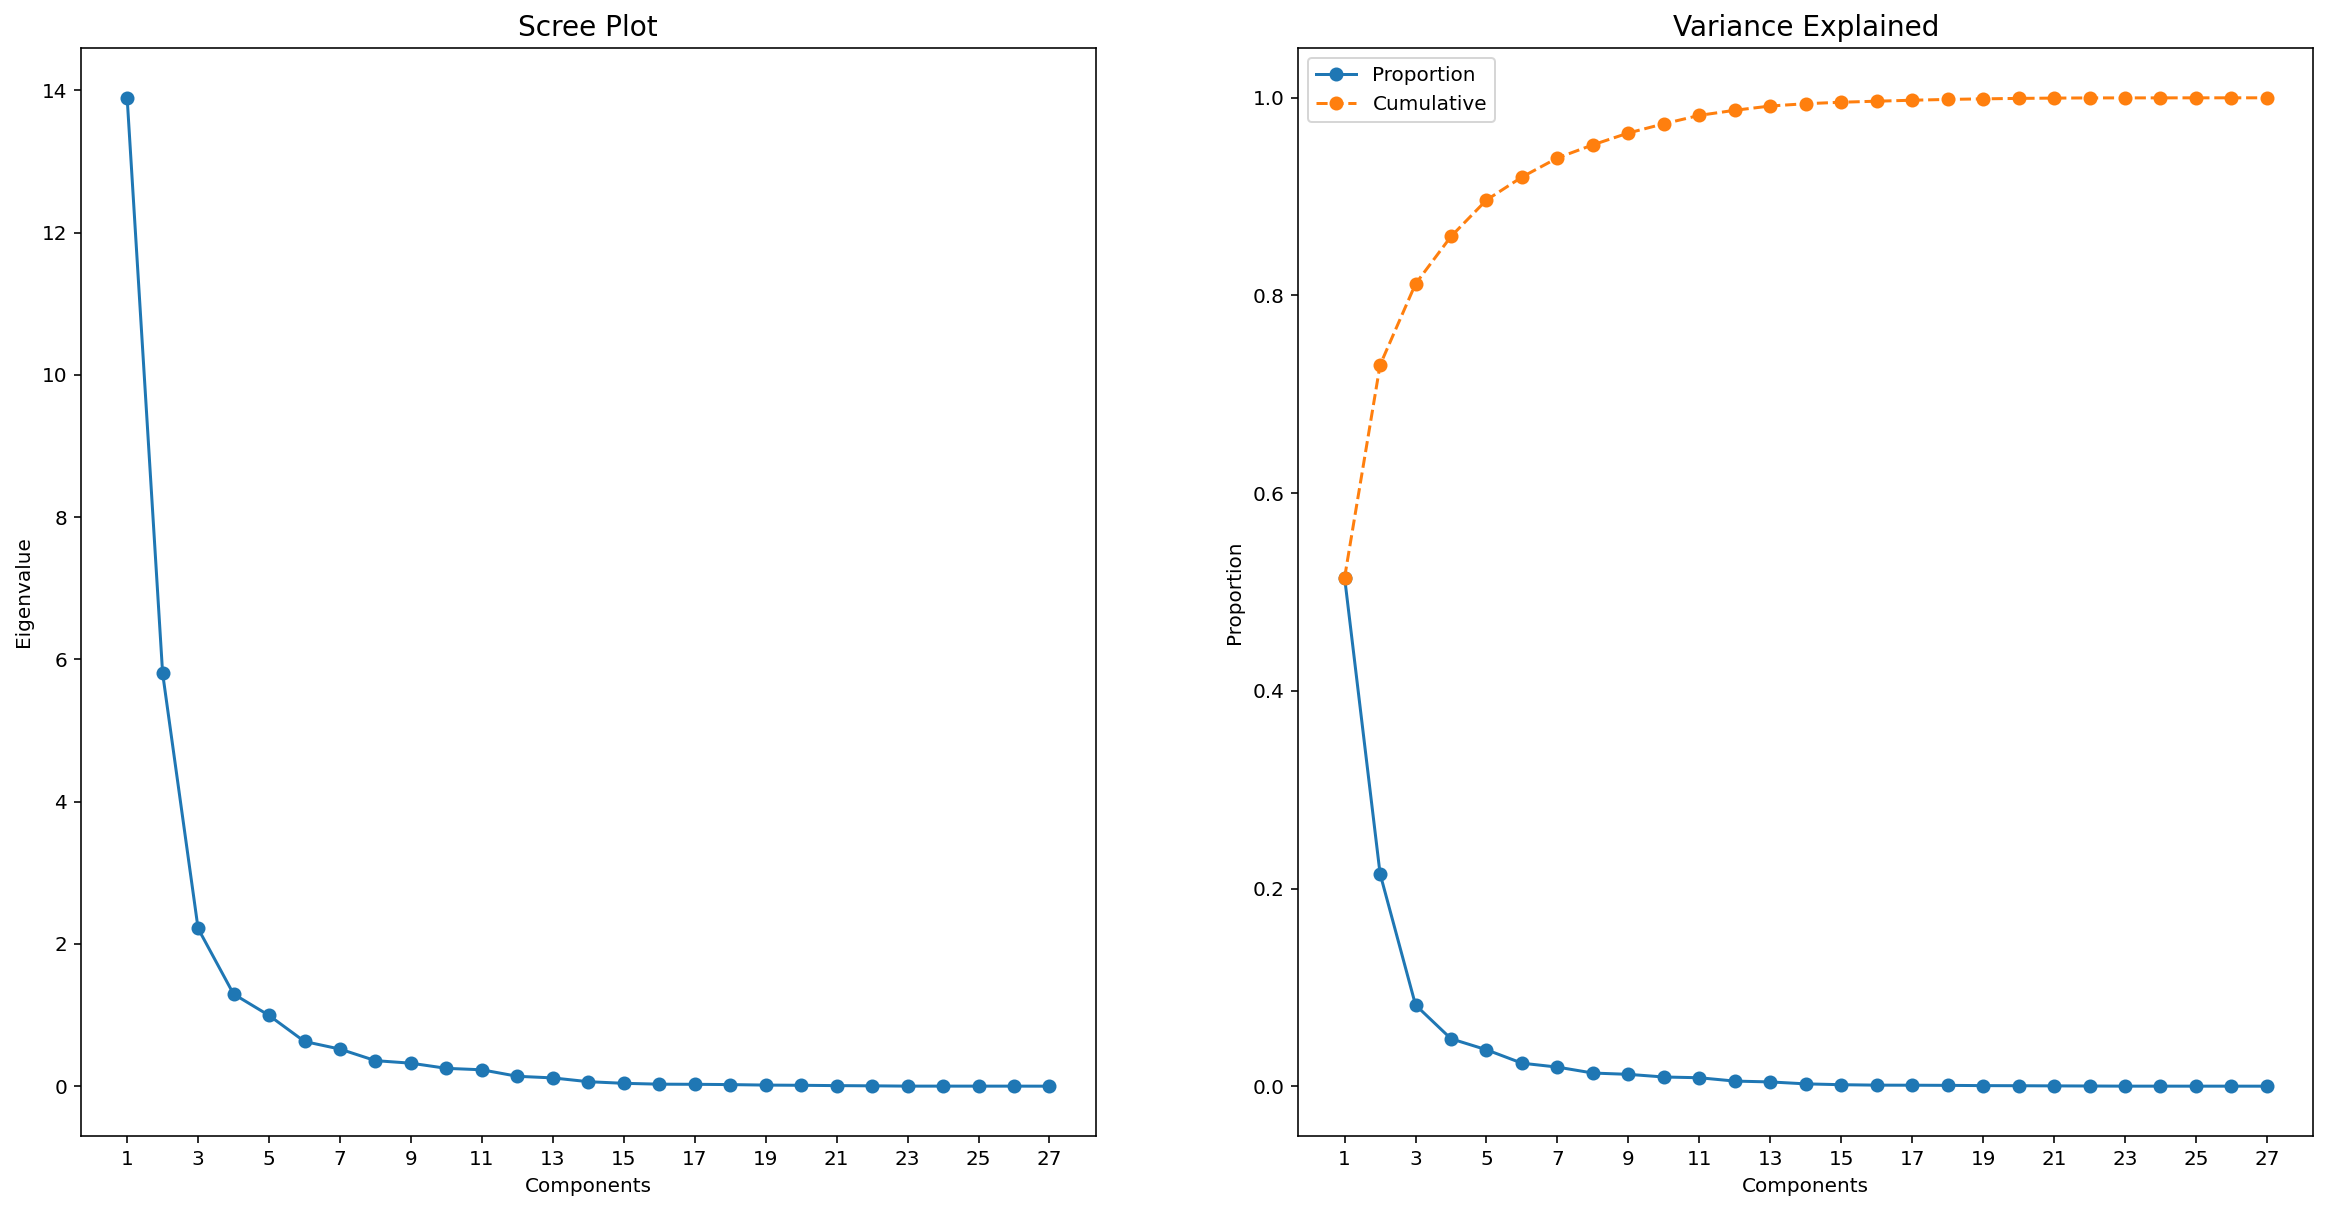

In [217]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")


ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [218]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=3)
pca_feat = pca.fit_transform(neighbourhood_fam[['AGE904', 'AGE907', 'HHN1', 'HHN2', 'HHN3','MARR1', 'VOC3', 'RHP2','RHP4','HHAGE2','HHAGE3','HHN4','HHN5','HHN6','HHP1',
                                                    'HHD1','HHD2','HHD3','HHD4','HHD5','HHD6','HHD7','HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12']])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=neighbourhood_fam.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2
0,-1.112020,-0.996797,-0.406053
1,-7.875590,-0.827296,1.061199
2,-0.312987,-0.833177,-0.102501
3,-1.057830,0.891450,0.124929
4,-2.618005,3.858981,-3.226103
...,...,...,...
94124,-1.208387,1.749740,1.315433
94125,-7.402873,-0.940473,1.117081
94126,0.322946,3.413146,0.256910
94127,-3.772510,0.180993,0.710802


In [219]:
df_pca = pd.concat([neighbourhood_fam, pca_df], axis=1)

In [220]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[list((neighbourhood_fam[['AGE904', 'AGE907', 'HHN1', 'HHN2', 'HHN3','MARR1', 'VOC3', 'RHP2','RHP4','HHAGE2','HHAGE3','HHN4','HHN5','HHN6','HHP1',
                                                    'HHD1','HHD2','HHD3','HHD4','HHD5','HHD6','HHD7','HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12']]).columns) + pca_feat_names].corr().loc[list((neighbourhood_fam[['AGE904', 'AGE907', 'HHN1', 'HHN2', 'HHN3','MARR1', 'VOC3', 'RHP2','RHP4','HHAGE2','HHAGE3','HHN4','HHN5','HHN6','HHP1',
                                                    'HHD1','HHD2','HHD3','HHD4','HHD5','HHD6','HHD7','HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12']]).columns), pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2
AGE904,0.646887,-0.532085,-0.423467
AGE907,-0.845250,0.327699,-0.076981
HHN1,0.919148,0.225537,-0.057162
HHN2,0.378509,-0.691482,0.001172
HHN3,-0.959169,0.187907,0.046399
MARR1,-0.587170,-0.742891,-0.019128
VOC3,-0.625916,-0.319135,0.218651
RHP2,-0.594712,-0.560983,0.122314
RHP4,-0.383562,0.678872,-0.128127
HHAGE2,0.679675,-0.098361,-0.583992


In [221]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(pca_df)
scaled_feat

array([[-0.29832109, -0.4137058 , -0.27269051],
       [-2.11278119, -0.34335704,  0.71266318],
       [-0.08396496, -0.34579787, -0.06883608],
       ...,
       [ 0.08663646,  1.41657609,  0.17253131],
       [-1.01204975,  0.07511854,  0.47734932],
       [-1.065167  , -0.88966538,  0.53538542]])

In [222]:
pca_df = scaled_feat
pca_df = pd.DataFrame(pca_df)
pca_names=['Single Adults Neighbourhood','Single Parents Neighbourhood','Younger Neighbourhood']
pca_df.columns = pca_names
pca_df

,Single Adults Neighbourhood,Single Parents Neighbourhood,Younger Neighbourhood
0,-0.298321,-0.413706,-0.272691
1,-2.112781,-0.343357,0.712663
2,-0.083965,-0.345798,-0.068836
3,-0.283784,0.369983,0.083898
4,-0.702331,1.601614,-2.166535
...,...,...,...
94124,-0.324173,0.726204,0.883397
94125,-1.985966,-0.390329,0.750191
94126,0.086636,1.416576,0.172531
94127,-1.012050,0.075119,0.477349


In [223]:
neighbourhood.drop(columns=['AGE904', 'AGE907', 'HHN1', 'HHN2', 'HHN3','MARR1', 'VOC3', 'RHP2','RHP4','HHAGE2','HHAGE3','HHN4','HHN5','HHN6','HHP1',
                                                    'HHD1','HHD2','HHD3','HHD4','HHD5','HHD6','HHD7','HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12','POP90C4', 'HHAGE1', 'HHP2', 'HV1', 'HV3'], inplace=True)

In [224]:
neighbourhood = pd.concat([neighbourhood, pca_df], axis=1)

###### **PCA Housing condition** 

In [225]:
neighbourhood_hous = neighbourhood.copy()

In [226]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(neighbourhood_hous)
scaled_feat

array([[-0.39851444, -0.41732486, -0.42415535, ..., -0.29832109,
        -0.4137058 , -0.27269051],
       [ 0.05532717,  0.04420598, -0.11193866, ..., -2.11278119,
        -0.34335704,  0.71266318],
       [ 0.64277393,  0.79521771,  0.67141581, ..., -0.08396496,
        -0.34579787, -0.06883608],
       ...,
       [-0.47476122, -0.508129  , -0.48369216, ...,  0.08663646,
         1.41657609,  0.17253131],
       [-0.26785519, -0.30262488, -0.34164764, ..., -1.01204975,
         0.07511854,  0.47734932],
       [ 0.11147252,  0.21625594,  0.04932641, ..., -1.065167  ,
        -0.88966538,  0.53538542]])

In [227]:
neighbourhood_hous = scaled_feat
neighbourhood_hous = pd.DataFrame(neighbourhood_hous)
neighbourhood_hous.columns = neighbourhood.columns
neighbourhood_hous

,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C5,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE905,AGE906,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,DW1,DW2,DW3,...,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,CONTROLN,ICCHEAP,ICMEDIUM,ICEXPENSIVE,1stSECTOR,2ndSECTOR,3rdSECTOR,Less_Educated,High_School,University,Other_ETH,Black Communities,Hispanic Communities,Native white kids,Single Adults Neighbourhood,Single Parents Neighbourhood,Younger Neighbourhood
0,-0.398514,-0.417325,-0.424155,-1.248073,0.677184,0.961345,0.504836,-0.178914,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,0.514259,-0.236072,-0.102497,-0.453063,0.552570,0.788638,0.792845,0.881556,1.082027,-1.239120,0.639347,1.099206,-0.222012,-1.123765,-0.485686,0.688552,0.260710,0.062006,1.094168,-0.904786,-1.618324,0.475185,1.237677,0.527792,1.088394,1.104138,-0.172759,...,-0.360044,-0.389300,1.061382,-0.575141,-0.718174,-0.476344,-0.167552,-0.513084,-1.832769,1.853298,-0.929042,0.275068,0.666475,-0.638479,-0.426374,1.481241,0.304225,-0.190379,-0.218517,-0.140854,0.453316,0.742416,-0.789459,-0.001373,0.461439,-0.416111,-0.666863,-0.580652,2.374466,-1.643436,0.303420,0.97392,-0.811047,-0.493643,-0.297652,0.068654,0.600390,-0.298321,-0.413706,-0.272691
1,0.055327,0.044206,-0.111939,0.843770,-0.439140,-0.657564,-0.445552,0.717767,2.134531,1.485303,13.642978,-0.200177,-0.0583,-0.279361,-0.236072,0.207267,0.738417,-0.098791,-0.174966,-0.357974,-0.552821,-0.625826,-0.962174,1.422909,-0.035877,0.131723,-1.123765,2.074830,2.162053,-0.497708,-1.124087,-0.861844,-1.114075,-0.090241,0.939817,0.501568,-0.067698,1.171423,1.260271,-0.547748,...,-0.360044,-0.389300,1.230669,-0.575141,-0.933042,-0.476344,-0.167552,-0.513084,0.568871,-0.571650,0.753738,0.275068,0.666475,3.426939,1.967264,0.041236,-0.328177,-0.190379,-0.218517,-0.140854,-1.537576,-1.658287,-0.789459,0.958382,-3.031018,0.523540,4.162885,-0.448016,-0.413938,0.635445,-0.852294,-1.65264,1.765028,3.932922,0.288765,1.756141,-0.956876,-2.112781,-0.343357,0.712663
2,0.642774,0.795218,0.671416,-1.248073,-0.375350,1.783253,-0.128756,-0.178914,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,-0.279361,-0.236072,-0.102497,-0.453063,0.031481,0.100349,0.073584,-0.014930,0.133220,-0.685227,0.247566,0.720845,0.131723,-0.318800,-0.314985,0.442968,0.260710,-0.107436,0.040930,-0.276917,-0.701474,-0.454079,0.501568,0.726288,-0.074002,0.089271,-0.360253,...,-0.360044,-0.389300,-1.477915,-0.078737,0.177111,4.083996,-0.167552,0.927086,-2.233042,2.300980,-1.585040,-0.789149,-0.594265,0.232682,-0.426374,0.041236,-0.328177,-0.190379,-0.218517,-0.140854,-1.139398,-1.058112,-0.789459,-1.457422,0.617818,-0.560673,-0.666863,0.878338,1.577779,-1.896645,1.459135,-0.58256,-0.872382,-0.493643,-0.509058,-0.429923,0.663761,-0.083965,-0.345798,-0.068836
3,-0.459512,-0.488330,-0.477129,-1.248073,-0.183980,1.633815,-1.712736,0.717767,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,2.277860,-0.236072,-0.102497,-0.155193,-0.359335,-0.312623,-0.214121,-0.373524,-0.246303,0.699506,-0.731887,-0.225057,0.485458,0.352005,-0.656387,0.688552,0.007904,-0.615761,-0.109532,0.769530,0.215375,-0.454079,-1.461390,0.726288,0.590225,0.635738,0.014736,...,-0.360044,-0.389300,-0.208266,1.245008,-0.467494,-0.476344,-0.167552,1.023098,-2.196654,2.300980,-1.442432,-2.917584,-1.134583,2.265391,-0.426374,0.041236,-0.011976,-0.190379,-0.218517,-0.140854,-0.542130,-0.858053,-0.789459,1.393204,-0.216202,0.378978,-0.666863,4.990038,-1.409797,-2.149854,1.314670,-0.87440,-0.627042,1.656403,0.665066,2.338052,1.029111,-0.283784,0.369983,0.083898
4,-0.133730,-0.169491,-0.223043,0.843770,-0.439140,-0.657564,0.821632,-0.178914,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,-0.455721,-0.236072,-0.102497,-0.453063,-0.229063,0.375665,0.648993,0.164367,0.322981,-0.823700,0.835238,0.342484,0.308590,-0.184639,-1.339192,0.197385,2.030353,0

**Bartlett’s Test**

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, we should not employ a factor analysis.

**Interpretability:** Small values *(less than 0.05)* of the significance level indicate that a factor analysis may be useful with your data


In [228]:
chi_square_value,p_value = calculate_bartlett_sphericity(neighbourhood_hous[['HC1', 'HC2', 'HC4', 'HC5', 'HC10', 'HC11', 'HC12', 'HC13',  'HC16', 'HC17', 'HC18', 'HC19', 'HC21','DW1','DW2','DW3','DW4','DW5']])
chi_square_value,p_value

(2365480.8127842657, 0.0)

**Kaiser-Meyer-Olkin (KMO) Test**

It's a statistic that indicates the proportion of variance in our variables that might be caused by underlying factors. High values (close to 1.0) generally indicate that a factor analysis may be useful with our data. 

**Interpretability:** If the value is *less than 0.60*, the results of the factor analysis probably won’t be very useful.


In [229]:
kmo_all,kmo_model = calculate_kmo(neighbourhood_hous[['HU3',
       'HU5','HUR1','HUR2','HC1', 'HC2', 'HC4', 'HC5', 'HC11', 'HC12', 'HC13',  'HC16', 'HC17', 'HC18', 'HC19','DW1','DW2','DW4','DW5', 'MC1','MC2','MC3', 'DW6']])
kmo_model

0.8072901680140492

In [230]:
pca = PCA()
pca_feat = pca.fit_transform(neighbourhood_hous[['HU3',
       'HU5','HUR1','HUR2','HC1', 'HC2', 'HC4', 'HC5', 'HC11', 'HC12', 'HC13',  'HC16', 'HC17', 'HC18', 'HC19','DW1','DW2','DW4','DW5', 'MC1','MC2','MC3', 'DW6']])
pca_feat  

array([[-3.13710909e+00, -1.94804243e-01,  4.73783015e-02, ...,
        -2.09561977e-02,  5.13118857e-02, -9.06112706e-05],
       [-1.15656979e+00, -5.25340016e-01,  3.59733395e+00, ...,
        -1.22706493e-02,  1.58867586e-02, -7.85371725e-05],
       [-2.05649924e+00,  2.42715425e+00, -1.78433392e+00, ...,
         3.04357048e-02, -7.50632568e-02, -2.26126722e-05],
       ...,
       [-1.86229134e+00, -2.71918378e+00,  1.66283760e-01, ...,
         8.31565473e-02, -7.83106661e-04, -2.01813174e-04],
       [-2.36415968e+00, -2.47370889e+00,  1.78772985e+00, ...,
         1.62208698e-02,  1.95900688e-02, -9.74527606e-05],
       [ 3.54699465e-01,  2.25120227e+00,  4.17356246e+00, ...,
        -9.19153758e-03,  4.97759717e-03,  7.74995018e-05]])

In [231]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)).head(20)

,Eigenvalue,Difference,Proportion,Cumulative
1,7.381450,0.000000,0.320929,0.320929
2,4.815280,-2.566171,0.209358,0.530287
3,3.407764,-1.407516,0.148162,0.678449
4,1.286209,-2.121554,0.055922,0.734371
5,1.154370,-0.131839,0.050189,0.784560
6,0.768022,-0.386349,0.033392,0.817952
7,0.691937,-0.076085,0.030084,0.848036
8,0.595584,-0.096353,0.025895,0.873931
9,0.515469,-0.080115,0.022411,0.896342
10,0.451861,-0.063607,0.019646,0.915988


In [232]:
%matplotlib inline

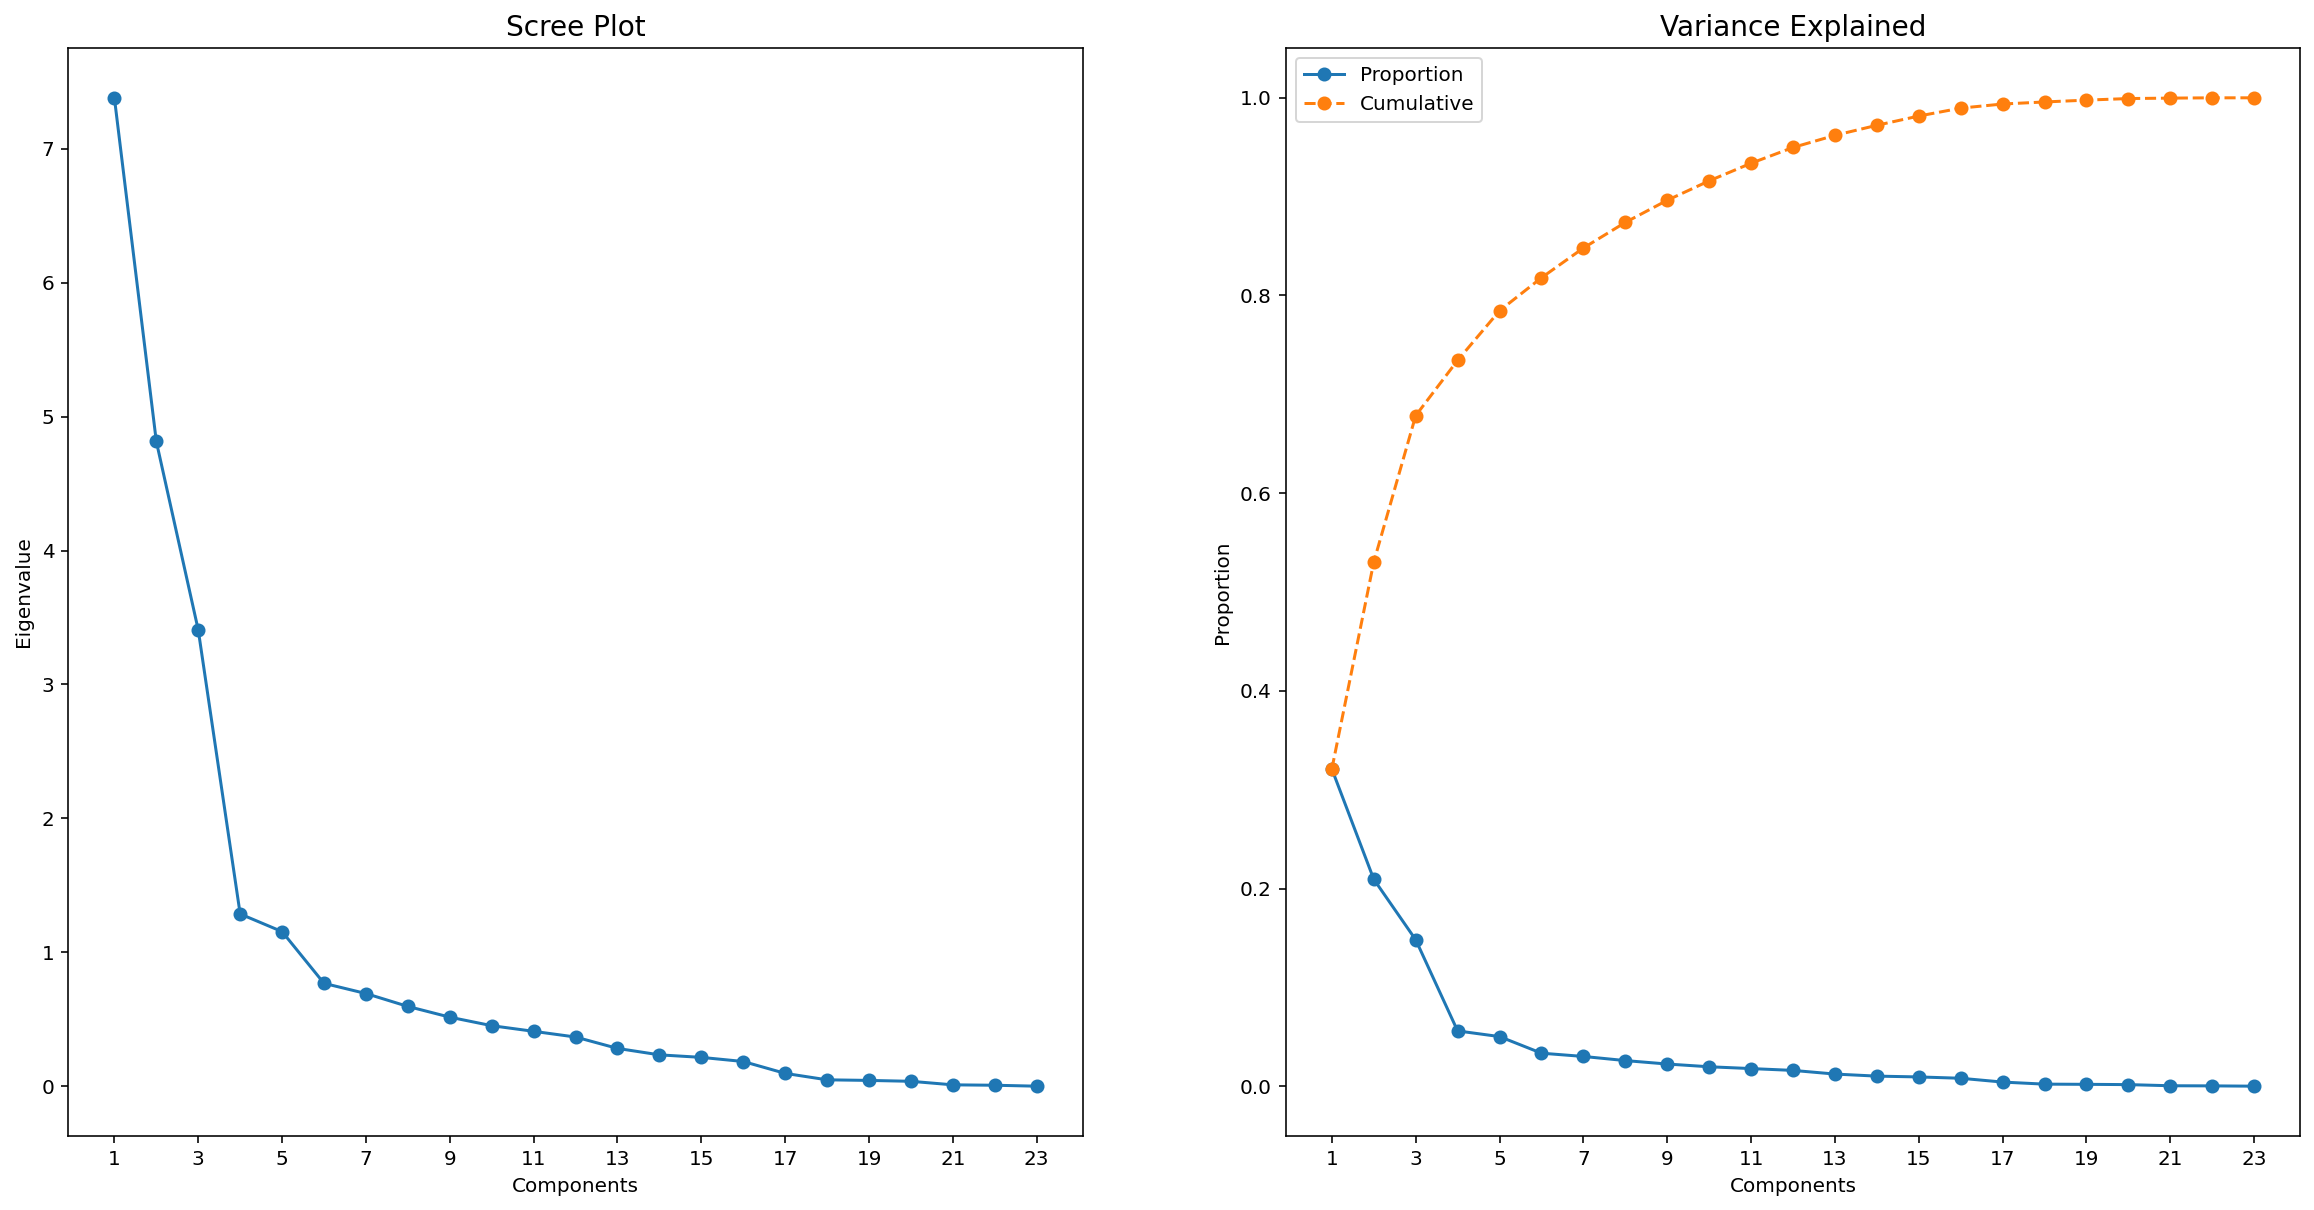

In [233]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")


ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [234]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=3)
pca_feat = pca.fit_transform(neighbourhood_hous[['HU3',
       'HU5','HUR1','HUR2','HC1', 'HC2', 'HC4', 'HC5', 'HC11', 'HC12', 'HC13',  'HC16', 'HC17', 'HC18', 'HC19','DW1','DW2','DW4','DW5', 'MC1','MC2','MC3', 'DW6']])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=neighbourhood_hous.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2
0,-3.137110,-0.194808,0.047383
1,-1.156570,-0.525341,3.597337
2,-2.056499,2.427154,-1.784334
3,-2.146795,1.783914,-1.814892
4,-3.931952,-1.249767,-1.304466
...,...,...,...
94124,2.274975,-0.342405,1.018374
94125,0.640162,2.417903,5.151025
94126,-1.862290,-2.719175,0.166265
94127,-2.364161,-2.473718,1.787749


In [235]:
df_pca = pd.concat([neighbourhood_hous, pca_df], axis=1)

In [236]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[list((neighbourhood_hous[[ 'HU3',
       'HU5','HUR1','HUR2','HC1', 'HC2', 'HC4', 'HC5', 'HC11', 'HC12', 'HC13',  'HC16', 'HC17', 'HC18', 'HC19','DW1','DW2','DW4','DW5', 'MC1','MC2','MC3', 'DW6']]).columns) +
                  pca_feat_names].corr().loc[list((neighbourhood_hous[['HU3',
       'HU5','HUR1','HUR2','HC1', 'HC2', 'HC4', 'HC5', 'HC11', 'HC12', 'HC13',  'HC16', 'HC17', 'HC18', 'HC19','DW1','DW2','DW4','DW5', 'MC1','MC2','MC3', 'DW6']]).columns), pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2
HU3,-0.146022,-0.504220,0.329789
HU5,-0.062869,0.557358,-0.286324
HUR1,0.603283,-0.037655,-0.413404
HUR2,-0.605147,-0.078007,0.554454
HC1,-0.694524,-0.342696,-0.265967
HC2,-0.228313,-0.613728,-0.454913
HC4,0.190599,0.570785,0.629027
HC5,0.219173,0.643239,0.587814
HC11,-0.061895,-0.751740,0.245043
HC12,-0.327577,0.554263,-0.358012


In [237]:
# HU3                         Percent Occupied Housing Units
# HU5                         Percent Seasonal/Recreational Vacant Units
# HUR1                        $ 1 or 2 Room Housing Units
# HUR2                        Percent >= 6 Room Housing Units
# HC1                         Percent Median Length of Residence
# HC2                         Percent Median Age of Occupied Dwellings in years
# HC4                         Percent Owner Occupied Structures Built Since 2005
# HC5                         Percent Owner Occupied Structures Built Since 2000
# HC11                        Percent Occupied Housing Units Heated by Utility Gas
# HC12                        Percent Occupied Housing Units Heated by Bottled, Tank or LP
# HC13                        Percent Occupied Housing Units Heated by Electricity
# HC16                        Percent Occupied Housing Units Heated by Coal, Wood, Other
# HC17                        Percent Housing Units w/ Public Water Source
# HC18                        Percent Housing Units w/ Well Water Source
# HC19                        Percent Housing Units w/ Public Sewer Source
# DW1                         Percent Single Unit Structure
# DW2                         Percent Detached Single Unit Structure
# DW4                         Percent Multi (2+) Unit Structures
# DW5                         Percent 3+ Unit Structures
# MC1                         Percent Persons Move in Since 2005
# MC2                         Percent Persons in Same House in 2005
# MC3                         Percent Persons in Different State/Country in 2005
# DW6                         Percent Housing Units in 5+ Unit Structure

In [238]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(pca_df)
scaled_feat

array([[-1.15467868, -0.08877673,  0.02566804],
       [-0.42569973, -0.23940482,  1.9487169 ],
       [-0.75693746,  1.10608596, -0.96659309],
       ...,
       [-0.6854548 , -1.23916358,  0.09006734],
       [-0.87017864, -1.12730569,  0.96844297],
       [ 0.13055442,  1.02590192,  2.26086748]])

In [239]:
pca_df = scaled_feat
pca_df = pd.DataFrame(pca_df)
pca_names=['Modern Flats','Rustic Conditions', 'Old Dwelling']
pca_df.columns = pca_names
pca_df

,Modern Flats,Rustic Conditions,Old Dwelling
0,-1.154679,-0.088777,0.025668
1,-0.425700,-0.239405,1.948717
2,-0.756937,1.106086,-0.966593
3,-0.790173,0.812953,-0.983147
4,-1.447237,-0.569535,-0.706644
...,...,...,...
94124,0.837352,-0.156038,0.551664
94125,0.235625,1.101870,2.790366
94126,-0.685455,-1.239164,0.090067
94127,-0.870179,-1.127306,0.968443


In [240]:
neighbourhood.drop(columns=[ 'HU3',
       'HU5','HUR1','HUR2','HC1', 'HC2', 'HC4', 'HC5',  'HC11', 'HC12', 'HC13',  'HC16', 'HC17', 'HC18', 'HC19','HC20', 'DW1','DW2','DW4','DW5','MC1','MC2','MC3',  'DW6'], inplace=True)

In [241]:
neighbourhood = pd.concat([neighbourhood, pca_df], axis=1)

###### **PCA Development**

In [242]:
neighbourhood_develop = neighbourhood.copy()

In [243]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(neighbourhood_develop)
scaled_feat

array([[-0.39851444, -0.41732486, -0.42415535, ..., -1.15467868,
        -0.08877673,  0.02566804],
       [ 0.05532717,  0.04420598, -0.11193866, ..., -0.42569973,
        -0.23940482,  1.9487169 ],
       [ 0.64277393,  0.79521771,  0.67141581, ..., -0.75693746,
         1.10608596, -0.96659309],
       ...,
       [-0.47476122, -0.508129  , -0.48369216, ..., -0.6854548 ,
        -1.23916358,  0.09006734],
       [-0.26785519, -0.30262488, -0.34164764, ..., -0.87017864,
        -1.12730569,  0.96844297],
       [ 0.11147252,  0.21625594,  0.04932641, ...,  0.13055442,
         1.02590192,  2.26086748]])

In [244]:
neighbourhood_develop = scaled_feat
neighbourhood_develop = pd.DataFrame(neighbourhood_develop)
neighbourhood_develop.columns = neighbourhood.columns
neighbourhood_develop

,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C5,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE905,AGE906,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,DW3,DW7,DW8,...,VOC2,HC3,HC6,HC7,HC8,HC9,HC10,HC14,HC15,HC21,MHUC1,MHUC2,AC1,AC2,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,CONTROLN,ICCHEAP,ICMEDIUM,ICEXPENSIVE,1stSECTOR,2ndSECTOR,3rdSECTOR,Less_Educated,High_School,University,Other_ETH,Black Communities,Hispanic Communities,Native white kids,Single Adults Neighbourhood,Single Parents Neighbourhood,Younger Neighbourhood,Modern Flats,Rustic Conditions,Old Dwelling
0,-0.398514,-0.417325,-0.424155,-1.248073,0.677184,0.961345,0.504836,-0.178914,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,0.514259,-0.236072,-0.102497,-0.453063,0.552570,0.788638,0.792845,0.881556,1.082027,-1.239120,0.639347,1.099206,-0.222012,-1.123765,-0.485686,0.688552,0.260710,0.062006,1.094168,-0.904786,-1.618324,0.475185,1.237677,0.527792,-0.172759,1.037227,1.498178,...,0.896090,0.450058,-0.486003,-0.289291,0.304570,-0.360044,-0.389300,-0.476344,-0.167552,0.666475,-0.638479,-0.426374,1.481241,0.304225,-0.190379,-0.218517,-0.140854,0.453316,0.742416,-0.789459,-0.001373,0.461439,-0.416111,-0.666863,-0.580652,2.374466,-1.643436,0.303420,0.97392,-0.811047,-0.493643,-0.297652,0.068654,0.600390,-0.298321,-0.413706,-0.272691,-1.154679,-0.088777,0.025668
1,0.055327,0.044206,-0.111939,0.843770,-0.439140,-0.657564,-0.445552,0.717767,2.134531,1.485303,13.642978,-0.200177,-0.0583,-0.279361,-0.236072,0.207267,0.738417,-0.098791,-0.174966,-0.357974,-0.552821,-0.625826,-0.962174,1.422909,-0.035877,0.131723,-1.123765,2.074830,2.162053,-0.497708,-1.124087,-0.861844,-1.114075,-0.090241,0.939817,0.501568,-0.067698,-0.547748,-0.330247,-0.289876,...,1.737192,-0.100675,1.588327,1.151003,-1.171981,-0.360044,-0.389300,-0.476344,-0.167552,0.666475,3.426939,1.967264,0.041236,-0.328177,-0.190379,-0.218517,-0.140854,-1.537576,-1.658287,-0.789459,0.958382,-3.031018,0.523540,4.162885,-0.448016,-0.413938,0.635445,-0.852294,-1.65264,1.765028,3.932922,0.288765,1.756141,-0.956876,-2.112781,-0.343357,0.712663,-0.425700,-0.239405,1.948717
2,0.642774,0.795218,0.671416,-1.248073,-0.375350,1.783253,-0.128756,-0.178914,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,-0.279361,-0.236072,-0.102497,-0.453063,0.031481,0.100349,0.073584,-0.014930,0.133220,-0.685227,0.247566,0.720845,0.131723,-0.318800,-0.314985,0.442968,0.260710,-0.107436,0.040930,-0.276917,-0.701474,-0.454079,0.501568,0.726288,-0.360253,0.255813,0.476433,...,0.223208,0.082902,0.111153,0.190807,-0.176914,-0.360044,-0.389300,4.083996,-0.167552,-0.594265,0.232682,-0.426374,0.041236,-0.328177,-0.190379,-0.218517,-0.140854,-1.139398,-1.058112,-0.789459,-1.457422,0.617818,-0.560673,-0.666863,0.878338,1.577779,-1.896645,1.459135,-0.58256,-0.872382,-0.493643,-0.509058,-0.429923,0.663761,-0.083965,-0.345798,-0.068836,-0.756937,1.106086,-0.966593
3,-0.459512,-0.488330,-0.477129,-1.248073,-0.183980,1.633815,-1.712736,0.717767,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,2.277860,-0.236072,-0.102497,-0.155193,-0.359335,-0.312623,-0.214121,-0.373524,-0.246303,0.699506,-0.731887,-0.225057,0.485458,0.352005,-0.656387,0.688552,0.007904,-0.615761,-0.109532,0.769530,0.215375,-0.454079,-1.461390,0.726288,0.014736,0.060460,-0.289876,...,-1.010407,-0.467831,-0.234569,-0.577349,0.593461,-0.360044,-0.389300,-0.476344,-0.167552,-1.134583,2.265391,-0.426374,0.041236,-0.011976,-0.190379,-0.218517,-0.140854,-0.542130,-0.858053,-0.789459,1.393204,-0.216202,0.378978,-0.666863,4.990038,-1.409797,-2.149854,1.314670,-0.87440,-0.627042,1.656403,0.665066,2.338052,1.029111,-0.283784,0.369983,0.083898,-0.790173,0.812953,-0.983147
4,-0.133730,-0.169491,-0.223043,0.843770,-0.439140,-0.657564,0.821632,-0.178914,-0.244005,-0.244222,-0.250757,-0.200177,-0.0583,-0.455721,-0.236072,-0.102497,-0.453063,-0.229063,0.375665,0.648993,0.164367,0.322981,-0.823700,0.835238,0.342484,0.308590,-0.184639,-1.3

**Bartlett’s Test**

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, we should not employ a factor analysis.

**Interpretability:** Small values *(less than 0.05)* of the significance level indicate that a factor analysis may be useful with your data


In [245]:
chi_square_value,p_value = calculate_bartlett_sphericity(neighbourhood_develop[['1stSECTOR',
#  '2ndSECTOR',
 '3rdSECTOR',
'ICMEDIUM',
 'ICEXPENSIVE',
 'POP90C1',
 'POP90C2',
 'POP90C3',
 'IC14',
'IC3',
 'IC4',
 'IC5',
'Less_Educated',
#  'High_School',
 'University','HHAS2',
 'HHAS3',
 'HHAS4','HV2',
 'HV4','SEC1',	'SEC5', 'TPE11','HVP1','HVP2','HVP3','HVP4','HVP5','RP2','RP3','MHUC1','MHUC2']])
chi_square_value,p_value

(4334260.94885765, 0.0)

**Kaiser-Meyer-Olkin (KMO) Test**

It's a statistic that indicates the proportion of variance in our variables that might be caused by underlying factors. High values (close to 1.0) generally indicate that a factor analysis may be useful with our data. 

**Interpretability:** If the value is *less than 0.60*, the results of the factor analysis probably won’t be very useful.


In [246]:
kmo_all,kmo_model = calculate_kmo(neighbourhood_develop[['1stSECTOR',
#  '2ndSECTOR',
 '3rdSECTOR',
'ICMEDIUM',
 'ICEXPENSIVE',
 'POP90C1',
 'POP90C2',
 'POP90C3',
 'IC14',
'IC3',
 'IC4',
 'IC5',
'Less_Educated',
#  'High_School',
 'University',
 'HHAS3',
 'HHAS4','HV2',
 'HV4','HVP1','HVP2','HVP3','HVP4','HVP5','RP2','RP3','MHUC1','RP1', 'ICCHEAP']])
kmo_model

0.8802273797125698

In [247]:
pca = PCA()
pca_feat = pca.fit_transform(neighbourhood_develop[['1stSECTOR',
#  '2ndSECTOR',
 '3rdSECTOR',
'ICMEDIUM',
 'ICEXPENSIVE',
 'POP90C1',
 'POP90C2',
 'POP90C3',
 'IC14',
'IC3',
 'IC4',
 'IC5',
'Less_Educated',
#  'High_School',
 'University',
 'HHAS3',
 'HHAS4','HV2',
 'HV4','HVP1','HVP2','HVP3','HVP4','HVP5','RP2','RP3','MHUC1','RP1','ICCHEAP' ]])
pca_feat  

array([[-2.78623958e+00,  1.47382612e+00, -1.27956408e+00, ...,
         9.69165863e-02,  3.71338502e-02,  7.95939174e-03],
       [ 1.13233300e+01,  4.56695548e+00,  1.29444059e+00, ...,
        -1.57563157e-01,  1.07268243e-02, -2.03116953e-03],
       [-3.98528903e+00,  2.38270362e+00,  1.33253827e-01, ...,
        -4.86120591e-02, -3.45272668e-03,  8.81143285e-03],
       ...,
       [-2.45634246e+00, -1.79982116e+00, -9.38785461e-02, ...,
         1.35878853e-01, -3.06657748e-03,  4.76047993e-05],
       [ 5.97217333e+00, -4.75156756e-01,  2.15627964e+00, ...,
        -8.22362988e-02, -3.94425002e-02, -1.52943865e-03],
       [ 2.48786405e+00, -1.47907688e+00, -1.48832317e+00, ...,
         6.01355229e-02,  4.00686233e-02, -2.48153633e-03]])

In [248]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)).head(5)

,Eigenvalue,Difference,Proportion,Cumulative
1,14.746484,0.000000,0.546160,0.546160
2,2.669560,-12.076925,0.098872,0.645032
3,1.932311,-0.737248,0.071566,0.716598
4,1.572272,-0.360039,0.058232,0.774830
5,1.167118,-0.405154,0.043226,0.818056


In [249]:
%matplotlib inline

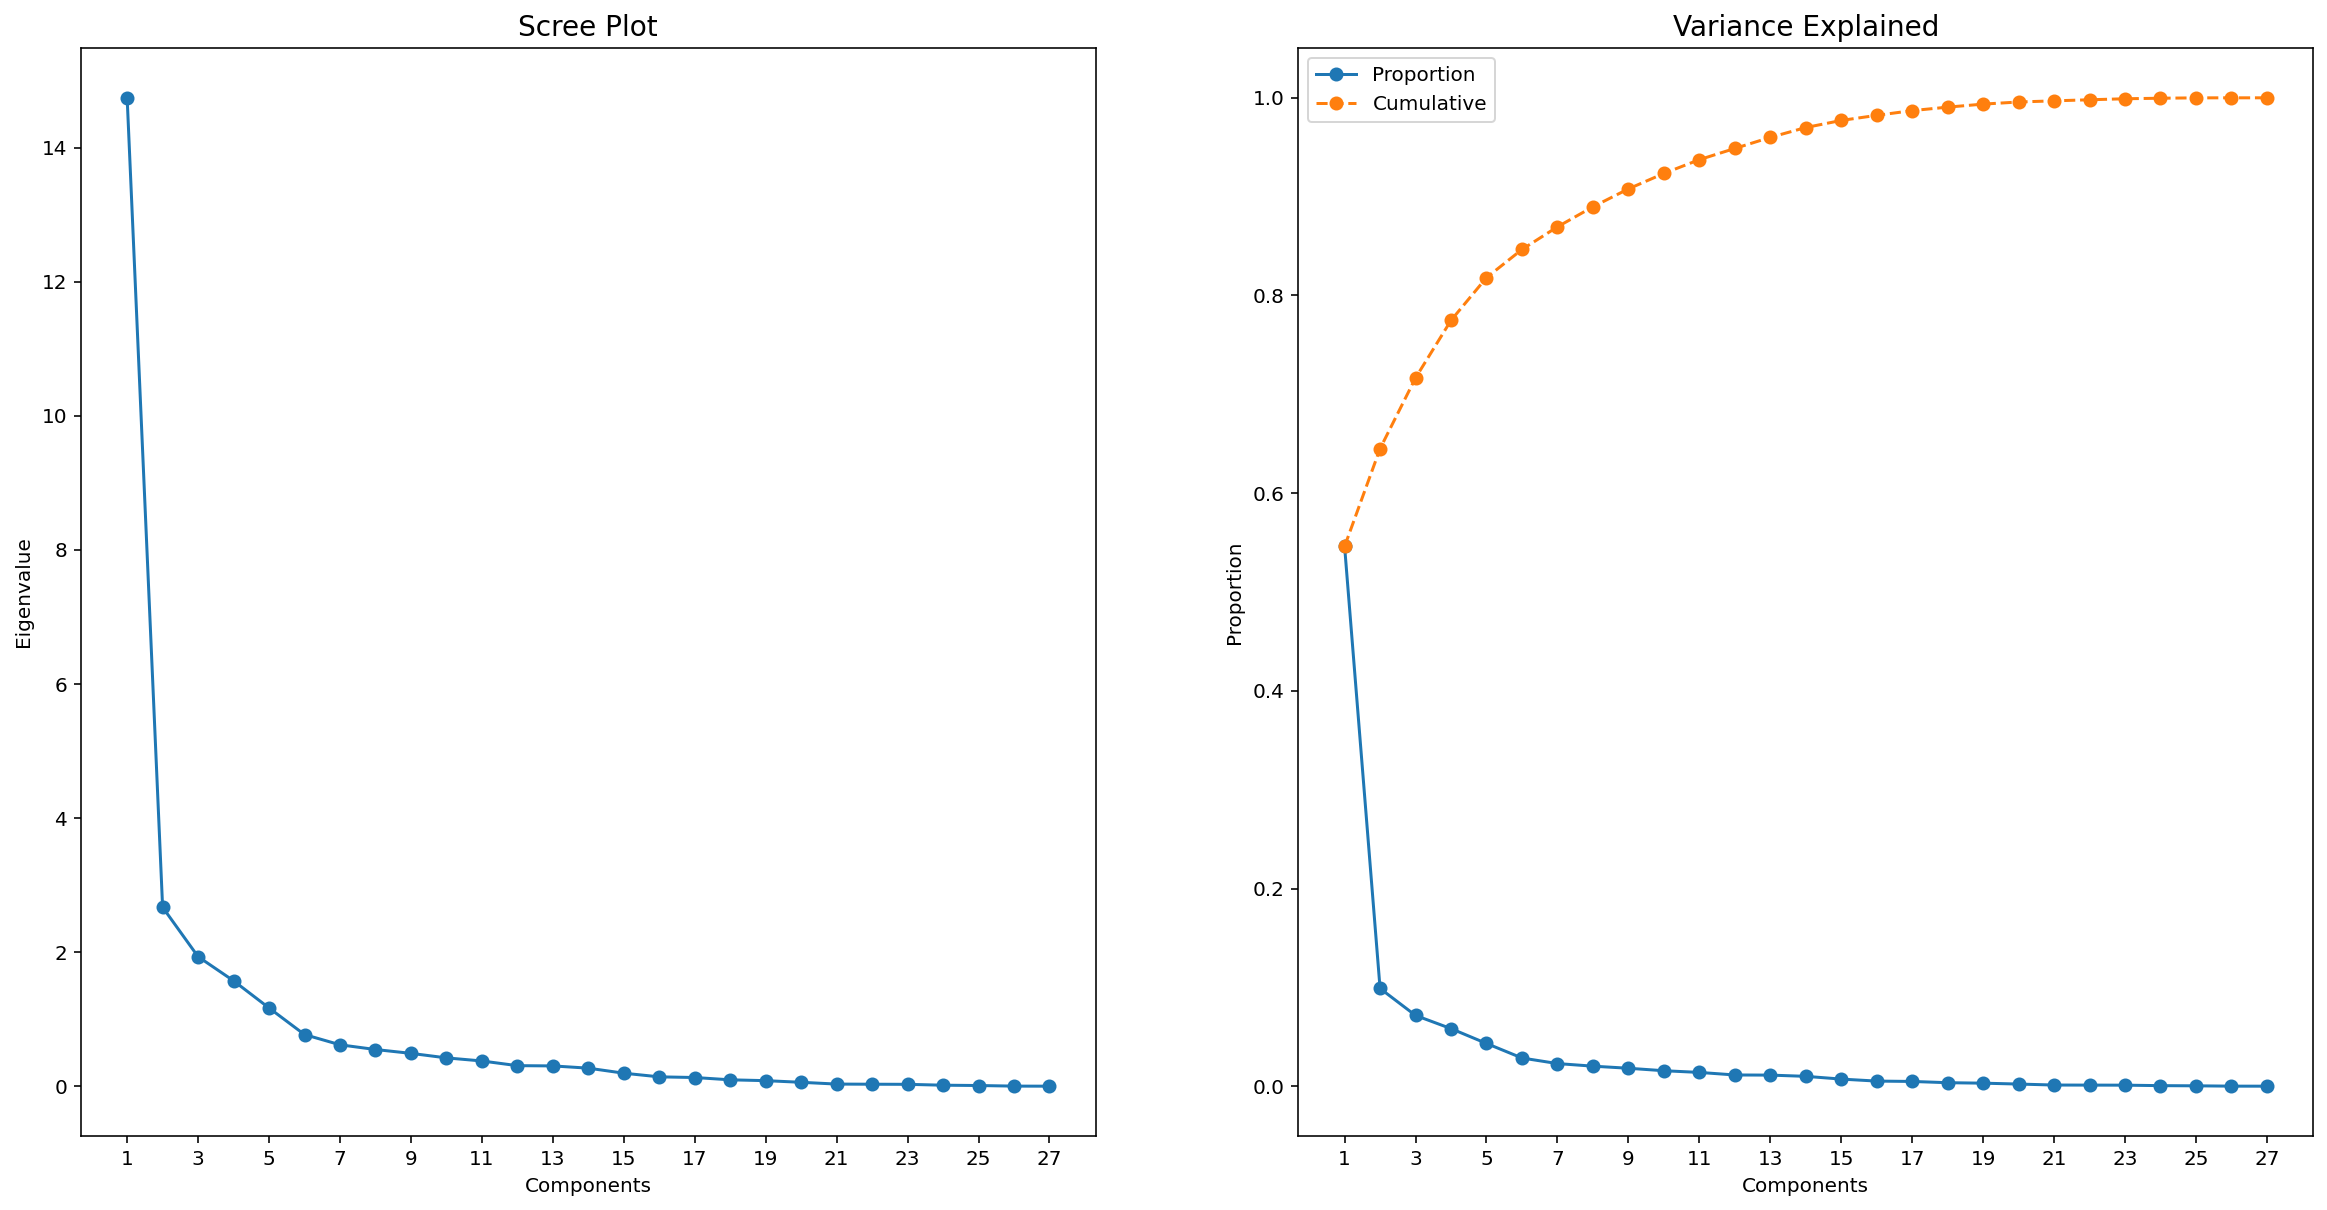

In [250]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")


ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [251]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=3)
pca_feat = pca.fit_transform(neighbourhood_develop[['1stSECTOR',
#  '2ndSECTOR',
 '3rdSECTOR',
'ICMEDIUM',
 'ICEXPENSIVE',
 'POP90C1',
 'POP90C2',
 'POP90C3',
 'IC14',
'IC3',
 'IC4',
 'IC5',
'Less_Educated',
#  'High_School',
 'University',
 'HHAS3',
 'HHAS4','HV2',
 'HV4','HVP1','HVP2','HVP3','HVP4','HVP5','RP2','RP3','MHUC1','RP1','ICCHEAP']])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=neighbourhood_develop.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2
0,-2.786240,1.473832,-1.279613
1,11.323330,4.566969,1.294576
2,-3.985289,2.382699,0.133218
3,-1.935443,4.539244,1.665501
4,-2.155680,-2.276927,0.863988
...,...,...,...
94124,3.281363,-0.989552,-0.876142
94125,5.522119,3.355219,-1.221589
94126,-2.456342,-1.799797,-0.093801
94127,5.972173,-0.475187,2.156240


In [252]:
df_pca = pd.concat([neighbourhood_develop, pca_df], axis=1)

In [253]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[list((neighbourhood_develop[['1stSECTOR',
#  '2ndSECTOR',
 '3rdSECTOR',
'ICMEDIUM',
 'ICEXPENSIVE',
 'POP90C1',
 'POP90C2',
 'POP90C3',
 'IC14',
'IC3',
 'IC4',
 'IC5',
'Less_Educated',
#  'High_School',
 'University',
 'HHAS3',
 'HHAS4','HV2',
 'HV4','HVP1','HVP2','HVP3','HVP4','HVP5','RP2','RP3','MHUC1','RP1','ICCHEAP']]).columns) + pca_feat_names].corr().loc[list((neighbourhood_develop[['1stSECTOR',
#  '2ndSECTOR',
 '3rdSECTOR',
'ICMEDIUM',
 'ICEXPENSIVE',
 'POP90C1',
 'POP90C2',
 'POP90C3',
 'IC14',
'IC3',
 'IC4',
 'IC5',
'Less_Educated',
#  'High_School',
 'University',
 'HHAS3',
 'HHAS4','HV2',
 'HV4','HVP1','HVP2','HVP3','HVP4','HVP5','RP2','RP3','MHUC1','RP1','ICCHEAP']]).columns), pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2
1stSECTOR,-0.376153,0.498649,0.158486
3rdSECTOR,0.446049,-0.470015,-0.142007
ICMEDIUM,0.775350,-0.008543,-0.245460
ICEXPENSIVE,0.764541,0.345595,-0.044738
POP90C1,0.513520,-0.638179,0.172304
POP90C2,-0.252519,0.119781,-0.150685
POP90C3,-0.409658,0.660784,-0.086829
IC14,0.607244,0.445544,-0.041344
IC3,0.911717,0.247511,-0.204459
IC4,0.916768,0.244081,-0.209133


In [254]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(pca_df)
scaled_feat

array([[-0.72556532,  0.90204947, -0.92053981],
       [ 2.94871108,  2.79518478,  0.9313039 ],
       [-1.03781008,  1.45831602,  0.09583522],
       ...,
       [-0.63965673, -1.1015545 , -0.06747972],
       [ 1.55521508, -0.29083528,  1.55117519],
       [ 0.64786527, -0.90526163, -1.07070361]])

In [255]:
pca_df = scaled_feat
pca_df = pd.DataFrame(pca_df)
pca_names=['Wealthier Areas','Rural Areas', 'Gentrified Areas']
pca_df.columns = pca_names
pca_df

,Wealthier Areas,Rural Areas,Gentrified Areas
0,-0.725565,0.902049,-0.920540
1,2.948711,2.795185,0.931304
2,-1.037810,1.458316,0.095835
3,-0.504009,2.778216,1.198143
4,-0.561361,-1.393579,0.621543
...,...,...,...
94124,0.854501,-0.605649,-0.630287
94125,1.438016,2.053541,-0.878798
94126,-0.639657,-1.101554,-0.067480
94127,1.555215,-0.290835,1.551175


In [256]:
neighbourhood.drop(columns=['1stSECTOR',
#  '2ndSECTOR',
 '3rdSECTOR',
'ICMEDIUM',
 'ICEXPENSIVE',
 'POP90C1',
 'POP90C2',
 'POP90C3',
 'IC14',
'IC3',
 'IC4',
 'IC5',
'Less_Educated',
  'High_School',
 'University','HHAS2',
 'HHAS3',
 'HHAS4','HV2',
 'HV4','SEC1',	'SEC5', 'TPE11','HVP1','HVP2','HVP3','HVP4','HVP5','RP2','RP3','MHUC1','MHUC2','RP1','ICCHEAP','2ndSECTOR'], inplace=True)

In [257]:
neighbourhood = pd.concat([neighbourhood, pca_df], axis=1)

###### **Impute Missing Values**

In [258]:
#WE DIDNT NEED TO DO IMPUTATION IN THIS SECTION

###### **Correlation Matrix**

In [259]:
neighbourhood=neighbourhood.drop(columns=['AGE903','AGE902','AGE901','AGE906','CHIL1','CHIL2','CHIL3','AGEC1','AGEC2','AGEC1', 'AGEC2', 
                                          'AGEC3','AGEC4', 'AGEC5', 'AGEC6', 'AGEC7', 'CHILC1', 'CHILC2', 'CHILC3','CHILC4', 'CHILC5','HUPA1', 'HUPA2', 'HUPA3', 'HUPA4', 'HUPA5','HUPA6', 'HUPA7',
                                          'RHP1','RHP3','RP4','HHAS1','LFC3',  'IC2','IC1','IC15', 'IC16', 'IC17','IC18', 'IC19', 'IC20', 'IC21', 'IC22', 'IC23', 'TPE1', 'TPE2', 'PEC1','PEC2',
                                          'TPE3','TPE4', 'TPE5', 'TPE6', 'TPE7', 'TPE8', 'TPE9','TPE10','TPE13','TPE12',
                                          # 'MC1','MC2','MC3',
                                          #'HVP1','HVP2','HVP3','HVP4','HVP5','RP2','RP3','MHUC1','MHUC2'
                                          'LFC4','LFC5','LFC6','OCC1','OCC2','OCC3','OCC4','OCC5',
                                          'OCC6','OCC7','OCC8','OCC9','OCC10','OCC11','OCC12','OCC13','ETH7',"ETH13",'LFC1', 'LFC7', 'LFC8', 'LFC9','ETHC3','ETH8','ETH9','ETH10','ETH11','ETH12','ETH14','ETH15',
 'ETH16','EC1','POP90C5', 'OEDC1', 'OEDC2', 'OEDC3', 'OEDC4','OEDC5', 'OEDC6', 'OEDC7','SEC2','SEC3','ANC1', 'ANC2', 'ANC3', 'ANC4', 'ANC5', 'ANC6','ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13','ANC14', 'ANC15','VOC1','VOC2','AC1','AC2'])

In [260]:
neighbourhood.head()

,POP901,POP902,POP903,AGE905,DW3,DW7,DW8,DW9,HU1,HU2,HU4,HVP6,LFC2,LFC10,SEC4,VC1,VC2,VC3,VC4,LSC3,LSC4,HC3,HC6,HC7,HC8,HC9,HC10,HC14,HC15,HC21,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,CONTROLN,Other_ETH,Black Communities,Hispanic Communities,Native white kids,Single Adults Neighbourhood,Single Parents Neighbourhood,Younger Neighbourhood,Modern Flats,Rustic Conditions,Old Dwelling,Wealthier Areas,Rural Areas,Gentrified Areas
0,992,264,332,50,2,7,7,0,86,14,4,0,64,0,19,34,23,18,16,0,4,5,31,54,46,0,0,0,0,99,0,0,0,18,39,0,95515,0,-0.297652,0.068654,0.600390,-0.298321,-0.413706,-0.272691,-1.154679,-0.088777,0.025668,-0.725565,0.902049,-0.920540
1,3611,940,998,42,0,0,0,0,96,4,3,94,83,0,24,55,10,11,0,27,16,2,97,99,0,0,0,0,0,99,0,0,0,8,15,0,148535,35,0.288765,1.756141,-0.956876,-2.112781,-0.343357,0.712663,-0.425700,-0.239405,1.948717,2.948711,2.795185,0.931304
2,7001,2040,2669,45,1,3,3,0,78,22,7,0,73,4,16,28,23,32,8,0,0,3,50,69,31,0,0,44,0,92,0,0,0,10,21,0,15078,0,-0.509058,-0.429923,0.663761,-0.083965,-0.345798,-0.068836,-0.756937,1.106086,-0.966593,-1.037810,1.458316,0.095835
3,640,160,219,43,3,2,0,2,48,52,7,10,81,23,17,14,40,31,16,3,0,0,39,45,55,0,0,0,0,89,0,0,0,13,23,0,172556,17,0.665066,2.338052,1.029111,-0.283784,0.369983,0.083898,-0.790173,0.812953,-0.983147,-0.504009,2.778216,1.198143
4,2520,627,761,46,0,0,0,0,90,10,3,0,73,10,20,9,16,53,20,0,0,0,6,33,67,0,0,3,0,96,1,1,1,15,28,4,7112,0,4.902744,-2.253036,0.115851,-0.702331,1.601614,-2.166535,-1.447237,-0.569535,-0.706644,-0.561361,-1.393579,0.621543


In [261]:
neighbourhood = corr_df(neighbourhood, 0.85)

POP903 | POP901 | 0.98
HC8 | HC6 | -0.86


In [262]:
neighbourhood.head()

,POP901,POP902,AGE905,DW3,DW7,DW8,DW9,HU1,HU2,HU4,HVP6,LFC2,LFC10,SEC4,VC1,VC2,VC3,VC4,LSC3,LSC4,HC3,HC6,HC7,HC9,HC10,HC14,HC15,HC21,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,CONTROLN,Other_ETH,Black Communities,Hispanic Communities,Native white kids,Single Adults Neighbourhood,Single Parents Neighbourhood,Younger Neighbourhood,Modern Flats,Rustic Conditions,Old Dwelling,Wealthier Areas,Rural Areas,Gentrified Areas
0,992,264,50,2,7,7,0,86,14,4,0,64,0,19,34,23,18,16,0,4,5,31,54,0,0,0,0,99,0,0,0,18,39,0,95515,0,-0.297652,0.068654,0.600390,-0.298321,-0.413706,-0.272691,-1.154679,-0.088777,0.025668,-0.725565,0.902049,-0.920540
1,3611,940,42,0,0,0,0,96,4,3,94,83,0,24,55,10,11,0,27,16,2,97,99,0,0,0,0,99,0,0,0,8,15,0,148535,35,0.288765,1.756141,-0.956876,-2.112781,-0.343357,0.712663,-0.425700,-0.239405,1.948717,2.948711,2.795185,0.931304
2,7001,2040,45,1,3,3,0,78,22,7,0,73,4,16,28,23,32,8,0,0,3,50,69,0,0,44,0,92,0,0,0,10,21,0,15078,0,-0.509058,-0.429923,0.663761,-0.083965,-0.345798,-0.068836,-0.756937,1.106086,-0.966593,-1.037810,1.458316,0.095835
3,640,160,43,3,2,0,2,48,52,7,10,81,23,17,14,40,31,16,3,0,0,39,45,0,0,0,0,89,0,0,0,13,23,0,172556,17,0.665066,2.338052,1.029111,-0.283784,0.369983,0.083898,-0.790173,0.812953,-0.983147,-0.504009,2.778216,1.198143
4,2520,627,46,0,0,0,0,90,10,3,0,73,10,20,9,16,53,20,0,0,0,6,33,0,0,3,0,96,1,1,1,15,28,4,7112,0,4.902744,-2.253036,0.115851,-0.702331,1.601614,-2.166535,-1.447237,-0.569535,-0.706644,-0.561361,-1.393579,0.621543


In [263]:
def maskecreator(Y):
    mask=Y[(Y>=0.65)|(Y<=-0.65)]
    return mask

#e preciso passa uma matriz de correlação pa isto funcionar btw por isso passem so a função corrmat como argumento q e mais facil
def THE_HEAT(Data):
    plt.subplots(figsize=(50,50))
    mask=Data #nã sei pq isto n ta a funcionar como deve ser
    mask.dropna(thresh=2)#isto remove tudo o q tiver menos de 2 valores ou seja n manteem variaveis q n tenham pelo menos uma correlação com outra variavel diferente
    mask2 = np.zeros_like(mask, dtype=np.bool) #isto e so para fazer uma mask para n representar nan
    mask2[np.triu_indices_from(mask2)] = True
    
    sns.heatmap(mask, mask=mask2   ,vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5,cmap=sns.diverging_palette(220, 10, as_cmap=True),annot=True)

###### **Scaling**

In [264]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
neighbourhood_numericas = neighbourhood.select_dtypes(include=numerics).drop(columns='CONTROLN')

In [265]:
neighbourhood_minmax = neighbourhood_numericas.copy()

In [266]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(neighbourhood_numericas)
scaled_feat

array([[-0.39851444, -0.41732486,  0.88155567, ..., -0.72556532,
         0.90204947, -0.92053981],
       [ 0.05532717,  0.04420598, -0.55282114, ...,  2.94871108,
         2.79518478,  0.9313039 ],
       [ 0.64277393,  0.79521771, -0.01492984, ..., -1.03781008,
         1.45831602,  0.09583522],
       ...,
       [-0.47476122, -0.508129  , -0.73211824, ..., -0.63965673,
        -1.1015545 , -0.06747972],
       [-0.26785519, -0.30262488, -0.01492984, ...,  1.55521508,
        -0.29083528,  1.55117519],
       [ 0.11147252,  0.21625594, -0.37352404, ...,  0.64786527,
        -0.90526163, -1.07070361]])

In [267]:
neighbourhood_minmax = scaled_feat
neighbourhood_minmax = pd.DataFrame(neighbourhood_minmax)
neighbourhood_minmax.columns = neighbourhood.drop(columns='CONTROLN').columns
neighbourhood_minmax

,POP901,POP902,AGE905,DW3,DW7,DW8,DW9,HU1,HU2,HU4,HVP6,LFC2,LFC10,SEC4,VC1,VC2,VC3,VC4,LSC3,LSC4,HC3,HC6,HC7,HC9,HC10,HC14,HC15,HC21,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,Other_ETH,Black Communities,Hispanic Communities,Native white kids,Single Adults Neighbourhood,Single Parents Neighbourhood,Younger Neighbourhood,Modern Flats,Rustic Conditions,Old Dwelling,Wealthier Areas,Rural Areas,Gentrified Areas
0,-0.398514,-0.417325,0.881556,-0.172759,1.037227,1.498178,-0.172814,0.754797,-0.755010,-0.529024,-0.358564,-0.836246,-0.727656,0.275449,0.218267,0.511868,-0.937612,0.436376,-0.385534,0.121161,0.450058,-0.486003,-0.289291,-0.360044,-0.389300,-0.476344,-0.167552,0.666475,-0.190379,-0.218517,-0.140854,0.453316,0.742416,-0.789459,-0.493643,-0.297652,0.068654,0.600390,-0.298321,-0.413706,-0.272691,-1.154679,-0.088777,0.025668,-0.725565,0.902049,-0.920540
1,0.055327,0.044206,-0.552821,-0.547748,-0.330247,-0.289876,-0.172814,1.239504,-1.239857,-0.630609,4.832187,0.660824,-0.727656,1.091864,1.697897,-0.847187,-1.355943,-1.076605,5.130804,2.857042,-0.100675,1.588327,1.151003,-0.360044,-0.389300,-0.476344,-0.167552,0.666475,-0.190379,-0.218517,-0.140854,-1.537576,-1.658287,-0.789459,3.932922,0.288765,1.756141,-0.956876,-2.112781,-0.343357,0.712663,-0.425700,-0.239405,1.948717,2.948711,2.795185,0.931304
2,0.642774,0.795218,-0.014930,-0.360253,0.255813,0.476433,-0.172814,0.367032,-0.367132,-0.224270,-0.358564,-0.127107,-0.292157,-0.214400,-0.204485,0.511868,-0.100949,-0.320114,-0.385534,-0.790800,0.082902,0.111153,0.190807,-0.360044,-0.389300,4.083996,-0.167552,-0.594265,-0.190379,-0.218517,-0.140854,-1.139398,-1.058112,-0.789459,-0.493643,-0.509058,-0.429923,0.663761,-0.083965,-0.345798,-0.068836,-0.756937,1.106086,-0.966593,-1.037810,1.458316,0.095835
3,-0.459512,-0.488330,-0.373524,0.014736,0.060460,-0.289876,0.458761,-1.087087,1.087408,-0.224270,0.193644,0.503238,1.776464,-0.051117,-1.190905,2.289094,-0.160711,0.436376,0.227392,-0.790800,-0.467831,-0.234569,-0.577349,-0.360044,-0.389300,-0.476344,-0.167552,-1.134583,-0.190379,-0.218517,-0.140854,-0.542130,-0.858053,-0.789459,1.656403,0.665066,2.338052,1.029111,-0.283784,0.369983,0.083898,-0.790173,0.812953,-0.983147,-0.504009,2.778216,1.198143
4,-0.133730,-0.169491,0.164367,-0.547748,-0.330247,-0.289876,-0.172814,0.948680,-0.948948,-0.630609,-0.358564,-0.127107,0.361092,0.438732,-1.543198,-0.219931,1.154046,0.814621,-0.385534,-0.790800,-0.467831,-1.271734,-0.961427,-0.360044,-0.389300,-0.165412,-0.167552,0.126158,0.126394,-0.014381,0.823189,-0.143952,-0.357906,1.655483,-0.493643,4.902744,-2.253036,0.115851,-0.702331,1.601614,-2.166535,-1.447237,-0.569535,-0.706644,-0.561361,-1.393579,0.621543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94124,4.174213,4.353648,-1.270010,0.952209,-0.330247,-0.289876,-0.172814,-0.699322,0.699531,0.182069,-0.358564,1.133583,0.034467,0.275449,1.204687,-0.324473,-1.355943,1.287428,0.023083,0.121161,-0.467831,0.991171,0.894950,0.422181,1.077558,-0.476344,-0.167552,0.486369,2.343806,2.843523,1.787232,0.851495,0.342299,2.266719,0.771090,-0.011849,-0.075562,-0.937125,-0.324173,0.726204,0.883397,0.837352,-0.156038,0.551664,0.854501,-0.605649,-0.630287
94125,-0.353113,-0.377726,-0.732118,-0.360253,-0.330247,-0.289876,-0.172814,0.851739,-0.851979,-0.630609,-0.082460,1.054790,-0.727656,2.398129,0.852394,-1.369900,-0.877850,0.341815,-0.385534,-0.334819,-0.100675,1.494039,0.990970,-0.360044,-0.389300,-0.476344,-0.167552,0.306263,-0.190379,-0.218517,-0.140854,1.050584,-0.057818,4.100425,-0.114224,-0.523305,-0.236143,0.445888,-1.985966,-0.390329,0.750191,0.235625,1.101870,2.790366,1.438016,2.053541,-0.878798
94126,-0.474761,-0.508129,-0.732118,-0.360253,-0.330247,-0.289876,-0.172814,-0.214616,0.214684,-0.427440,-0.358564,-0.363487,1.994213,1.581714,1.063770,-1.892614,-0.818089,0.814621,0.227392,-0.790800,-0.467831,-1.460309,-2.01764

In [268]:
threshold_n=0.001
selector = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n)))
intermedio =selector.fit_transform(neighbourhood_minmax)
chosen_variables = neighbourhood_minmax[neighbourhood_minmax.columns[selector.get_support(indices=True)]] 

In [269]:
chosen_variables.shape

(94129, 47)

In [270]:
chosen_variables.columns

Index(['POP901', 'POP902', 'AGE905', 'DW3', 'DW7', 'DW8', 'DW9', 'HU1', 'HU2',
       'HU4', 'HVP6', 'LFC2', 'LFC10', 'SEC4', 'VC1', 'VC2', 'VC3', 'VC4',
       'LSC3', 'LSC4', 'HC3', 'HC6', 'HC7', 'HC9', 'HC10', 'HC14', 'HC15',
       'HC21', 'AFC1', 'AFC2', 'AFC3', 'AFC4', 'AFC5', 'AFC6', 'Other_ETH',
       'Black Communities', 'Hispanic Communities', 'Native white kids',
       'Single Adults Neighbourhood', 'Single Parents Neighbourhood',
       'Younger Neighbourhood', 'Modern Flats', 'Rustic Conditions',
       'Old Dwelling', 'Wealthier Areas', 'Rural Areas', 'Gentrified Areas'],
      dtype='object')

In [271]:
chosen_variables.shape

(94129, 47)

###### **Outros**

In [272]:
chosen_variables = corr_df(chosen_variables, 0.85)

In [273]:
#Our function is not removing 100% of the highly correlated variables so we will do it by hand
chosen_variables.drop(columns = ['POP902','AGE905', 'HU4', 'LFC2','SEC4', 'POP901'], inplace= True)

In [274]:
chosen_variables.drop(columns=['VC1','VC2',	'VC3','VC4','AFC1','AFC2',	'AFC5','AFC6', 'LSC3', 'LSC4', 'LFC10'], inplace=True)	

In [275]:
chosen_variables.drop(columns=['DW3', 'DW7', 'DW8', 'DW9', 'HU1', 'HU2', 'HVP6', 'HC3', 'HC6', 'HC7',
        'HC9', 'HC10', 'HC14', 'HC21', 'AFC4',],inplace=True)

In [276]:
chosen_variables['CONTROLN']=neighbourhood['CONTROLN']

In [277]:
# juntar = pd.concat([oquevaisair, chosen_variables], axis=1 , join='inner', on ='CONTROLN')

In [278]:
juntar=chosen_variables.copy()

In [279]:
oquevaisair['CONTROLN']=users_data['CONTROLN']

In [280]:
oquevaisair.set_index('CONTROLN',inplace=True)

In [281]:
juntar.set_index('CONTROLN',inplace=True)

In [282]:
juntar=juntar.join(oquevaisair,on='CONTROLN')

In [283]:
(juntar.isna().sum() > 1).sum()

0

# **Clusters**

In [284]:
hopkins(juntar,10000)

0.04642041336242374

In [285]:
juntar.columns.to_list()

['HC15',
 'AFC3',
 'Other_ETH',
 'Black Communities',
 'Hispanic Communities',
 'Native white kids',
 'Single Adults Neighbourhood',
 'Single Parents Neighbourhood',
 'Younger Neighbourhood',
 'Modern Flats',
 'Rustic Conditions',
 'Old Dwelling',
 'Wealthier Areas',
 'Rural Areas',
 'Gentrified Areas',
 'NUMCHLD',
 'HIT',
 'MALEVET',
 'VIETVETS',
 'WWIIVETS',
 'LOCALGOV',
 'AGE',
 'MALEMILI']

In [286]:
juntar['allvets']=juntar[['VIETVETS', 'WWIIVETS','MALEMILI']].sum(axis=1)

In [288]:
social_economic_cenas=juntar[['Gentrified Areas','Black Communities','allvets','Single Parents Neighbourhood',
 'Younger Neighbourhood','Modern Flats','Wealthier Areas']]

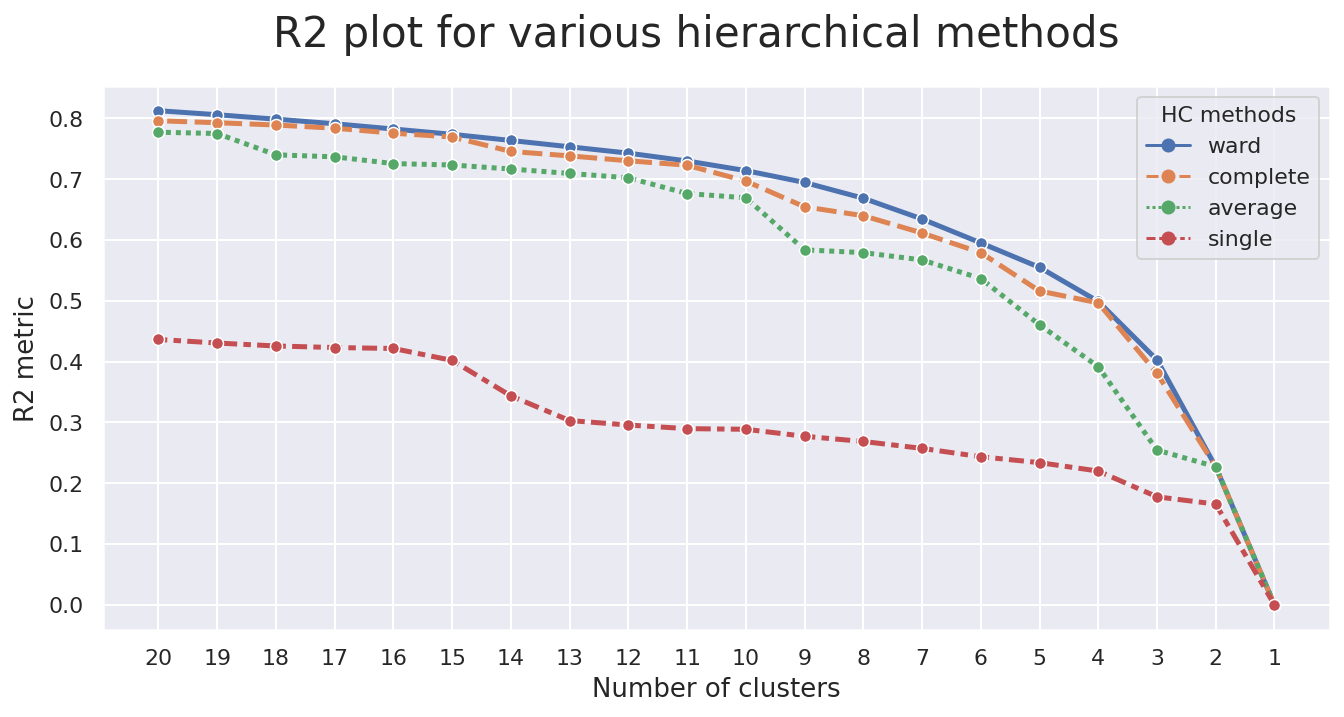

In [289]:
hierarchical_ontop_of_kmeans1(social_economic_cenas)

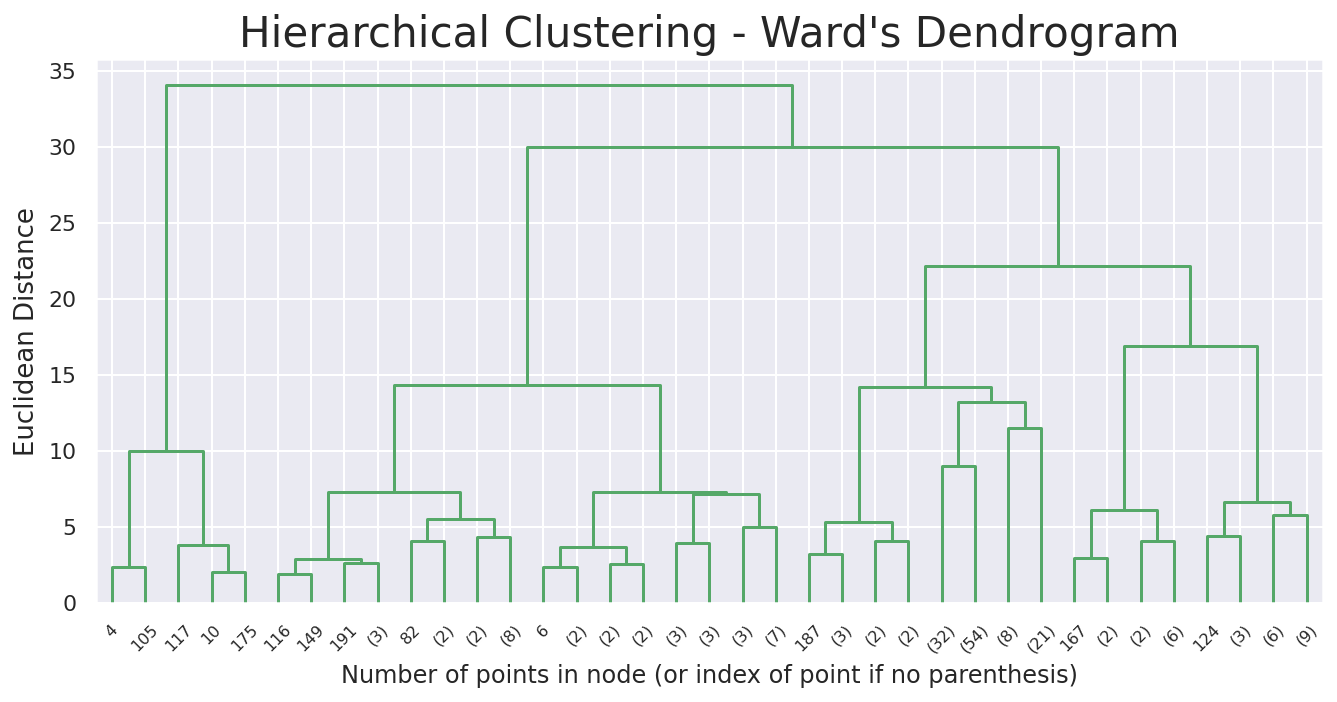

In [290]:
hierarchical_ontop_of_kmeans2(social_economic_cenas,'ward')

In [291]:
Social_economic_clust_solution, Social_economic_description = hierarchical_ontop_of_kmeans3(social_economic_cenas, 4)

In [292]:
Social_economic_clust_solution.isna().any()

Gentrified Areas                False
Black Communities               False
allvets                         False
Single Parents Neighbourhood    False
Younger Neighbourhood           False
Modern Flats                    False
Wealthier Areas                 False
Labels                          False
dtype: bool

In [293]:
Social_economic_description

,Gentrified Areas,Black Communities,allvets,Single Parents Neighbourhood,Younger Neighbourhood,Modern Flats,Wealthier Areas
Labels,,,,,,,
0,0.674054,0.071259,-0.455153,0.699798,1.003712,1.312904,0.545253
1,1.259392,2.392695,-0.224911,1.720771,-1.278985,0.145812,-0.716526
2,-0.446283,-0.313009,0.827775,-0.671785,0.245488,-0.169213,0.872686
3,-0.247976,-0.327867,-0.257106,-0.211763,-0.288222,-0.445441,-0.618573
